TMA4320 Project 3 - Industrial Mathematics

Group 1980

Candidate numbers: 10117, 10106, 10060

# <strong>Dimensionality reduction, and its application on CryptoPunks </strong>

## 0.0 - Motivation
Machine learning has in recent years - through services like smart-assistants and personalized Netflix suggestions - become an important part of our daily lives. One can easily assume that most consumers simply use this technology to their advantage without thinking much of it. Yet, within the field of computer science and mathematics, scientists are constantly working towards improving the methods for how machines analyse different types of data. This will hopefully lead to computers being able to withdraw useful information and insight in a more efficient and sophisticated manner. Images are one of the most common types of data-sets to analyze. Here, the machine learning can for example be used to find similarities between large amounts of images or restore noisy images to a more viewable state. 

In this project, we will use a simple form of machine learning to analyze CryptoPunks. These are a family of images with blockchain verified ownership called NFTs, which to put it simply is a trendy form of cryptocurrency. While the CryptoPunks and NFT-technology in itself is not the focus of this project, the pixelated images work nicely as a dataset that we can use in our analysis. Each CryptoPunck consists of a randomly generated image, depicting a pixelated face with unique set of facial-features and attire.  Although every CryptoPunk is unique, some of their features and clothes are shared among multiple characters. This results in some similarities and looks that often reoccur throughout the dataset, and we can use our machine learning to analyse these similarities.

The method of machine learning that we will work with in this project is called dimensionality reduction. This methods goal is to transform high-dimensional data into lower dimensional data, while keeping important features intact. There are in fact many forms of dimensionality reduction - such as linear discriminant analysis, canonical correlation analysis, and various matrix factorization techniques - but we will focus on the matrix factorization technique called non-negative matrix factorization (NMF).

It is worth mentioning that within the field of matrix factorization, there are many different options besides NMF. We for example have eigenvalue decomposition and singular value decomposition (SVD), each with their own advantages and disadvantages. There are a couple of reasons for why the NMF is to be preferred for this project. The non-negativity of NMF is a desired property when working with pictures. This constraint can help with overfitting, as it would make no sense to have negatively valued pixels. Additionally, we will later see that the basis-vectors in NMF have very interesting properties.

## 0.1 Numerical groundwork

We are going to need some tools. Numpy is a useful library for scientific calculations written in C, this means that using Numpy functions vastly reduces the runtime of our code. In addition, we use Numpy to save calculated data. This is so that we don’t have to run the same calculations more than once. We will also be using the pyplot and IPython.display libraries for visualization purposes, and time to manage progress on large computations. Scipy is another library for scientific calculations, and later we will make use of the function `ndimage.label()`. Tabulate helps with formatting matrices in tables, and itertools is used to create an unusual plot later.

In [120]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from tabulate import tabulate

import cv2

from IPython.display import display, Latex, Math

import os
import itertools

plt.rcParams['figure.dpi'] = 250



# 1 Non-negative matrix factorization

The idea behind NMF is that a given non-negative $m \times n$ matrix A can be decomposed into two smaller matrices such that $A \approx W H = A_{NMF}$. Here, $W$ and $H$ are real valued $m \times d$ and $d \times n$ matrices respectively, very often with $d << m,n$ such that the total amount of components in $WH$ is significantly smaller than $A$. We also have that $d$ will be the amount of basis vectors in $W$. For the purposes of this project, the columns of A will always represent a data point, while the rows represent a property of interest. 


The NMF is obtained by minimizing the distance between $A$ and $A_{NMF}$. We will use the Frobenius norm to measure this distance. In other words, solving the equation


$$
    \min\limits_{W,H} \Vert A-WH\Vert_F, W, H \geq 0,
$$

where $F$ is the Frobenius norm: 

$$
    \Vert A - B \Vert _F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n \vert a_{ij} - b_{ij} \vert ^2}
$$

These constrained optimization problems are often impossible to solve analytically, and even numerically it can be very challenging. For our particular problem, we will implement Lee and Seung's multiplicative rule

$$
    H_{k+1} = H_{k} \odot (W_K^T A) \oslash (W_K^T W_k H_k) 
$$
$$
    W_{k+1} = H_k \odot (A H_{k+1}^T)\oslash (W_k H_{k+1}H_{k+1}^T),
$$
Where $\odot$ and $\oslash$ is the Hadamard product and division respectively. It can be shown that this algorithm satisfies 
$$
\Vert  A - W_{k+1} H_{K+1}\Vert_F \leq\Vert  A - W_{k} H_{K}\Vert_F 
$$

This means that the algorithm converges, although  it may converge to a local minima, so it's only an approximate solution. Depending on the initial conditions, the convergence can be quite slow, which we will see examples of later. Additionally, it's worth mentioning that the NMF is not unique.

## 1.1 Ensuring non-negativity of the matrices

As the name suggests, it is important that our algorithm ensures positivity in the matrices. It turns out that if we assume $A$ to be non-negative and $W_0$, $H_0$ to be positive, then we are certain that each $H_{k}$, $W_{k}$ is non-negative for $k\in\{ 0, 1, 2, ... \}$. 

#### The case of $H_{k}$
This can be shown by examining the expression for each element in $H_{k+1}$:
$$
    (H_{k+1})_{ij} = (H_k)_{ij} \frac{  (W_{k}^{T} A)_{ij} }{   (W_{k}^{T}W_{k}H_{k})_{ij} }
$$
We have by assumption, that $(H_k)_{ij} > 0$, $(W_{k})_{ij} > 0$ and $A_{ij} \geq 0$ for all $i, j$. This implies that any product between them is ensured to be greater that, or equal to zero. Thus $H_k$ is a non-negative matrix for all $k \geq 0$, given the constraints described above. 


#### The case of $W_{k}$
To show that $W_{k}$ is also non-negative for all $k \geq 0 $, we must use the result derived above. The element-wise expression for $W_{k+1}$ is given as: 
$$
    (W_{k+1})_{ij} = (W_k)_{ij} \frac{  (A H_{k+1}^{T})_{ij} }{   (W_{k}H_{k+1}H_{k+1}^{T})_{ij} }
$$
From the previous result, we know that $(H_{k+1})_{ij} \geq0$ for all $i, j$. Thus by the same logic,  $W_k$ is also a non-negative for all $k \geq 0 $. 

$ \square $


The way we take care of this in practice is simply by initializing the matrices to random numbers between 0 and 1 and then normalizing the values, making use of Numpy's random integer function.






## 1.2 Avoiding division by zero

If we initialize $H_0$ or $W_0$ to a matrix of zeros, we will end up either dividing by zero, or a $0/0$-expression. In either case, this is problematic. We can get around this by adding a small $\delta \in [10^{-6},10^{-9}]$ to the denominator. This ensures that one never divides by zero, as well as slightly promoting sparsity in the matrices due to the fact that the components may occasionally be rounded off due to the larger denominator. This alteration has some noteworthy consequences that will be discussed later.



## 1.3 Convergence
There exist convergence criterions for the algorithm, but they are costly and difficult to calculate, so for simplicity’s sake, we will run 1000 iterations. With that said, after having finished the iterations, in some circumstances we can check if we have reached a fixed point by checking if $(W^{T}A)\oslash(W^{T}WH)$ is a matrix of ones. We will use this fact later in the discussion. 

We can show this by assuming that $ (W^{T}A)\oslash(W^{T}WH) $ is a matrix only consisting of ones, then $H_{k}$ will be a fixed point (which means that $H_{k+1} = H_{k}$). We can easily show this by substituting a matrix of ones, which we will call $M_{1}$, into our algorithm update for $H$.
$$
    H_{k+1} = H_{k}\odot(W^{T}A)\oslash(W^{T}WH) =  H_{k}\odot M_{1} = H_{k} \Rightarrow H_{k+1} = H_{k}
$$
The equality $H_{k}\odot M_{1} = H_{k}$ obviously holds since multiplying an element in $H_{k}$ by one will result in the same value.

$(W^{T}A)\oslash(W^{T}WH)$ will be a matrix of ones if $WH = A$, which can be shown by substitution.
$$
    (W^{T}A)\oslash(W^{T}WH) = (W^{T}A)\oslash(W^{T}A) = (A)\oslash(A) = M_{1}
$$
 



## 1.4 Implementation

We are now ready to implement the previously described NMF-algorithm.


In [121]:
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0, store_norms = False):
    """
    Calculate the decomposition WH according to Lee and Seung's multiplicative rule.
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
    """

    if seed != 0:
        np.random.seed(seed)
    
    norms = np.zeros(maxiter)

    #Initialize W and H to random numbers between 0 and 1 with the correct shape
    m = np.shape(V)[0]
    n = np.shape(V)[1]
    W_0 = np.random.uniform(0.0, 1.0, m*d).reshape(m,d)
    H_0 = np.random.uniform(0.0, 1.0, d*n).reshape(d,n)

    #Scale the matrixes
    W_0 = np.sqrt(np.mean(V)/d)*W_0
    H_0 = np.sqrt(np.mean(V)/d)*H_0
    
    W_next = np.copy(W_0)
    W_prev = np.copy(W_0)
    H_next = np.copy(H_0)
    H_prev = np.copy(H_0)
    
    for k in range(maxiter):
        H_next = (H_prev * np.dot(W_prev.T,V)) / (np.linalg.multi_dot([W_prev.T,W_prev,H_prev])+delta)
        W_next = (W_prev * np.dot(V,H_next.T)) / (np.linalg.multi_dot([W_prev,H_next,H_next.T])+delta)
        H_prev = np.copy(H_next)
        W_prev = np.copy(W_next)
        norms[k] = np.linalg.norm(V- np.dot(W_next, H_next), 'fro')

    if store_norms == False:
        return W_next, H_next
    else:
        return W_next, H_next, norms

## 1.5 Test matrices and output formatting

To avoid copying significant amounts of code when printing the matrices, we create a function that formats the output nicely, with some help from the Tabulate library. We have chosen to round off at 5 decimals, but this could easily be changed.


In [122]:
def pretty_print(V, d,V_title, delta = 1e-9, maxiter = 1000, seed = 0):
    '''
    Calculates the NMF and prints information about a matrix in a nice format.

    input:
    V: (m,n) input array
    d: integer, Number of components we want to decompose V into
    delta, float, small number for safe division
    maxiter: integer, maximum number of iterations
    seed: integer, random seed

    output: none
    '''
    decimals = 5
    W, H = NMF(V, d, delta = delta, maxiter = maxiter, seed = seed)
    print(f"Matrix {V_title}, d =  {str(d)}" )
    data = [np.array(["W","H","WH","Norm","W.T A / W.T W H"]),
    [
    np.round(W,decimals),
    np.round(H,decimals),
    np.round(np.dot(W,H),),
    np.linalg.norm(V- np.dot(W,H), 'fro'),
    np.dot(W.T,V) / (np.linalg.multi_dot([W.T,W,H]))
    ]
    ]

    print(tabulate(data, headers='firstrow', tablefmt='fancy_grid'))


In order to test the NMF function, we create some test matrices of different sizes and with varying properties.

In [123]:
A_1 = np.array([
    [1, 0],
    [0, 1]
]) 

A_2 = np.array([
    [1, 2],
    [1, 1], 
    [1, 2]
])

A_3 = np.array([
    [2, 1, 1],
    [2, 1, 1], 
    [1, 1, 2]
])

A_4 = np.array([
    [2, 1, 0],
    [1, 2, 3], 
    [0, 3, 3]
])

## 1.6 Testing with one basis vector

Here, we test how our function decomposes $A_1$ and $A_2$ with one basis-vector. We test twice, to compare what values stay constant, and what changes depending on the random initialization of the algorithm.

In [124]:
def NMF_test():
    pretty_print(A_1,1,"A_1",delta = 1e-9, maxiter = 1000, seed = 0)
    pretty_print(A_1,1,"A_1 new seed",delta = 1e-9, maxiter = 1000, seed = 0)
    pretty_print(A_2,1,"A_2",delta = 1e-9, maxiter = 1000, seed = 0)
    pretty_print(A_2,1,"A_2 new seed",delta = 1e-9, maxiter = 1000, seed = 0)
    
    
NMF_test()

Matrix A_1, d =  1
╒═════════════╤═════════════════════╤═══════════╤════════╤═══════════════════╕
│ W           │ H                   │ WH        │   Norm │ W.T A / W.T W H   │
╞═════════════╪═════════════════════╪═══════════╪════════╪═══════════════════╡
│ [[0.54299]  │ [[1.55608 0.6666 ]] │ [[1. 0.]  │      1 │ [[1. 1.]]         │
│  [0.23261]] │                     │  [0. 0.]] │        │                   │
╘═════════════╧═════════════════════╧═══════════╧════════╧═══════════════════╛
Matrix A_1 new seed, d =  1
╒═════════════╤═════════════════════╤═══════════╤════════╤═══════════════════╕
│ W           │ H                   │ WH        │   Norm │ W.T A / W.T W H   │
╞═════════════╪═════════════════════╪═══════════╪════════╪═══════════════════╡
│ [[0.07131]  │ [[0.57463 2.77993]] │ [[0. 0.]  │      1 │ [[1. 1.]]         │
│  [0.34498]] │                     │  [0. 1.]] │        │                   │
╘═════════════╧═════════════════════╧═══════════╧════════╧═══════════════════╛
Matri

When running the test multiple times, we see that the decomposition of $A_1$ into $WH$ is not unique. We also see that W and H are non-unique, which is what we expected from the NMF theory. The norm is equal to $1$ in both instances, which is not particularly impressive. This is due to only having one basis vector, which is not enough for a perfect reconstruction. We can see this from the fact that the equation 

$$
    (a   b) {c\choose d} = {1 0 \choose 0 1}
$$
Does not have a solution.

From the last column, we can see that the algorithm has converged. Notice that the right diagonal of the WH matrix has the same components.

For $A_2$, the algorithm converges to the same result regardless of the random initialization of the matrix. The norm here is 0.411, so it's still not a very good approximation of the matrix. We will therefore try to decompose the two matrices again, now with two basis elements, which hopefully yields better results.


## 1.7 Increasing the amount of basis vectors
We run the same code, with `d=2`.


In [125]:
def test_NMF_more_basis():
    pretty_print(A_1,2,"A_1",delta = 1e-9, maxiter = 1000, seed = 9)
    pretty_print(A_2,2,"A_2",delta = 1e-9, maxiter = 1000, seed = 9)

test_NMF_more_basis()

Matrix A_1, d =  2
╒═════════════════════╤═════════════════════╤═══════════╤═════════════╤═══════════════════╕
│ W                   │ H                   │ WH        │        Norm │ W.T A / W.T W H   │
╞═════════════════════╪═════════════════════╪═══════════╪═════════════╪═══════════════════╡
│ [[0.      0.28027]  │ [[0.      3.18741]  │ [[1. 0.]  │ 4.20688e-10 │ [[nan  1.]        │
│  [0.31373 0.     ]] │  [3.56802 0.     ]] │  [0. 1.]] │             │  [ 1. nan]]       │
╘═════════════════════╧═════════════════════╧═══════════╧═════════════╧═══════════════════╛
Matrix A_2, d =  2
╒═════════════════════╤═════════════════════╤═══════════╤═════════════╤═══════════════════╕
│ W                   │ H                   │ WH        │        Norm │ W.T A / W.T W H   │
╞═════════════════════╪═════════════════════╪═══════════╪═════════════╪═══════════════════╡
│ [[0.04528 0.39557]  │ [[2.27653 1.93762]  │ [[1. 2.]  │ 2.04476e-06 │ [[1. 1.]          │
│  [0.38821 0.05126]  │  [2.26741 4.83419]

/var/folders/_k/ftngv5t159n1p3wmrs7nk3nc0000gn/T/ipykernel_35396/1779765783.py:23: RuntimeWarning: invalid value encountered in true_divide
  np.dot(W.T,V) / (np.linalg.multi_dot([W.T,W,H]))



Notice how the zeros in $W$ and $H$ result in our convergence criterion not being applicable in this instance, due to division by zero. This does not necessarily imply that the algorithm did not converge, it simply means that our test does not give us a definite answer for this particular problem.

We see that with two basis vectors, the norm is significantly smaller for both $A_1$ and $A_2$, which seems reasonable as we have now enough basis vectors to work with to expect a good approximation.



## 1.8 Studying the $ 3 \times 3$ matrices

We will now test the two $3 \times 3$ matrices, but first, we will look at their eigenvalues.


In [126]:
def eigenvalues():
    eigenvalues_A3,eigenvectors_A3 = np.linalg.eig(A_3)
    eigenvalues_A4,eigenvectors_A4 = np.linalg.eig(A_4)

    #Preparing to round off a the eigenvalue -4.04414586e-16 to 0 instead of -0. Caused by machine error.
    eigenvalues_A3[2] = np.abs(eigenvalues_A3[2])  

    display(Latex(f'The three eigenvalues of $A_{3}$ is {np.round(eigenvalues_A3,4)}.'))
    display(Latex(f'The three eigenvalues of $A_{4}$ is {(np.round(eigenvalues_A4,4))}.'))

eigenvalues()



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We see that one of the eigenvalues of $A_3$ is zero. This means that the rank is two, so even though it's a $3 \times 3$ matrix, we may only need $d=2$ basises. As for $A_4$, it has three nonzero eigenvalues.

With that in mind, we will plot the Frobenius norm as a function of the iteration number for both $A_3$ and $A_4$ with $d = 1,2,3$, in order to study how the algorithm converges.


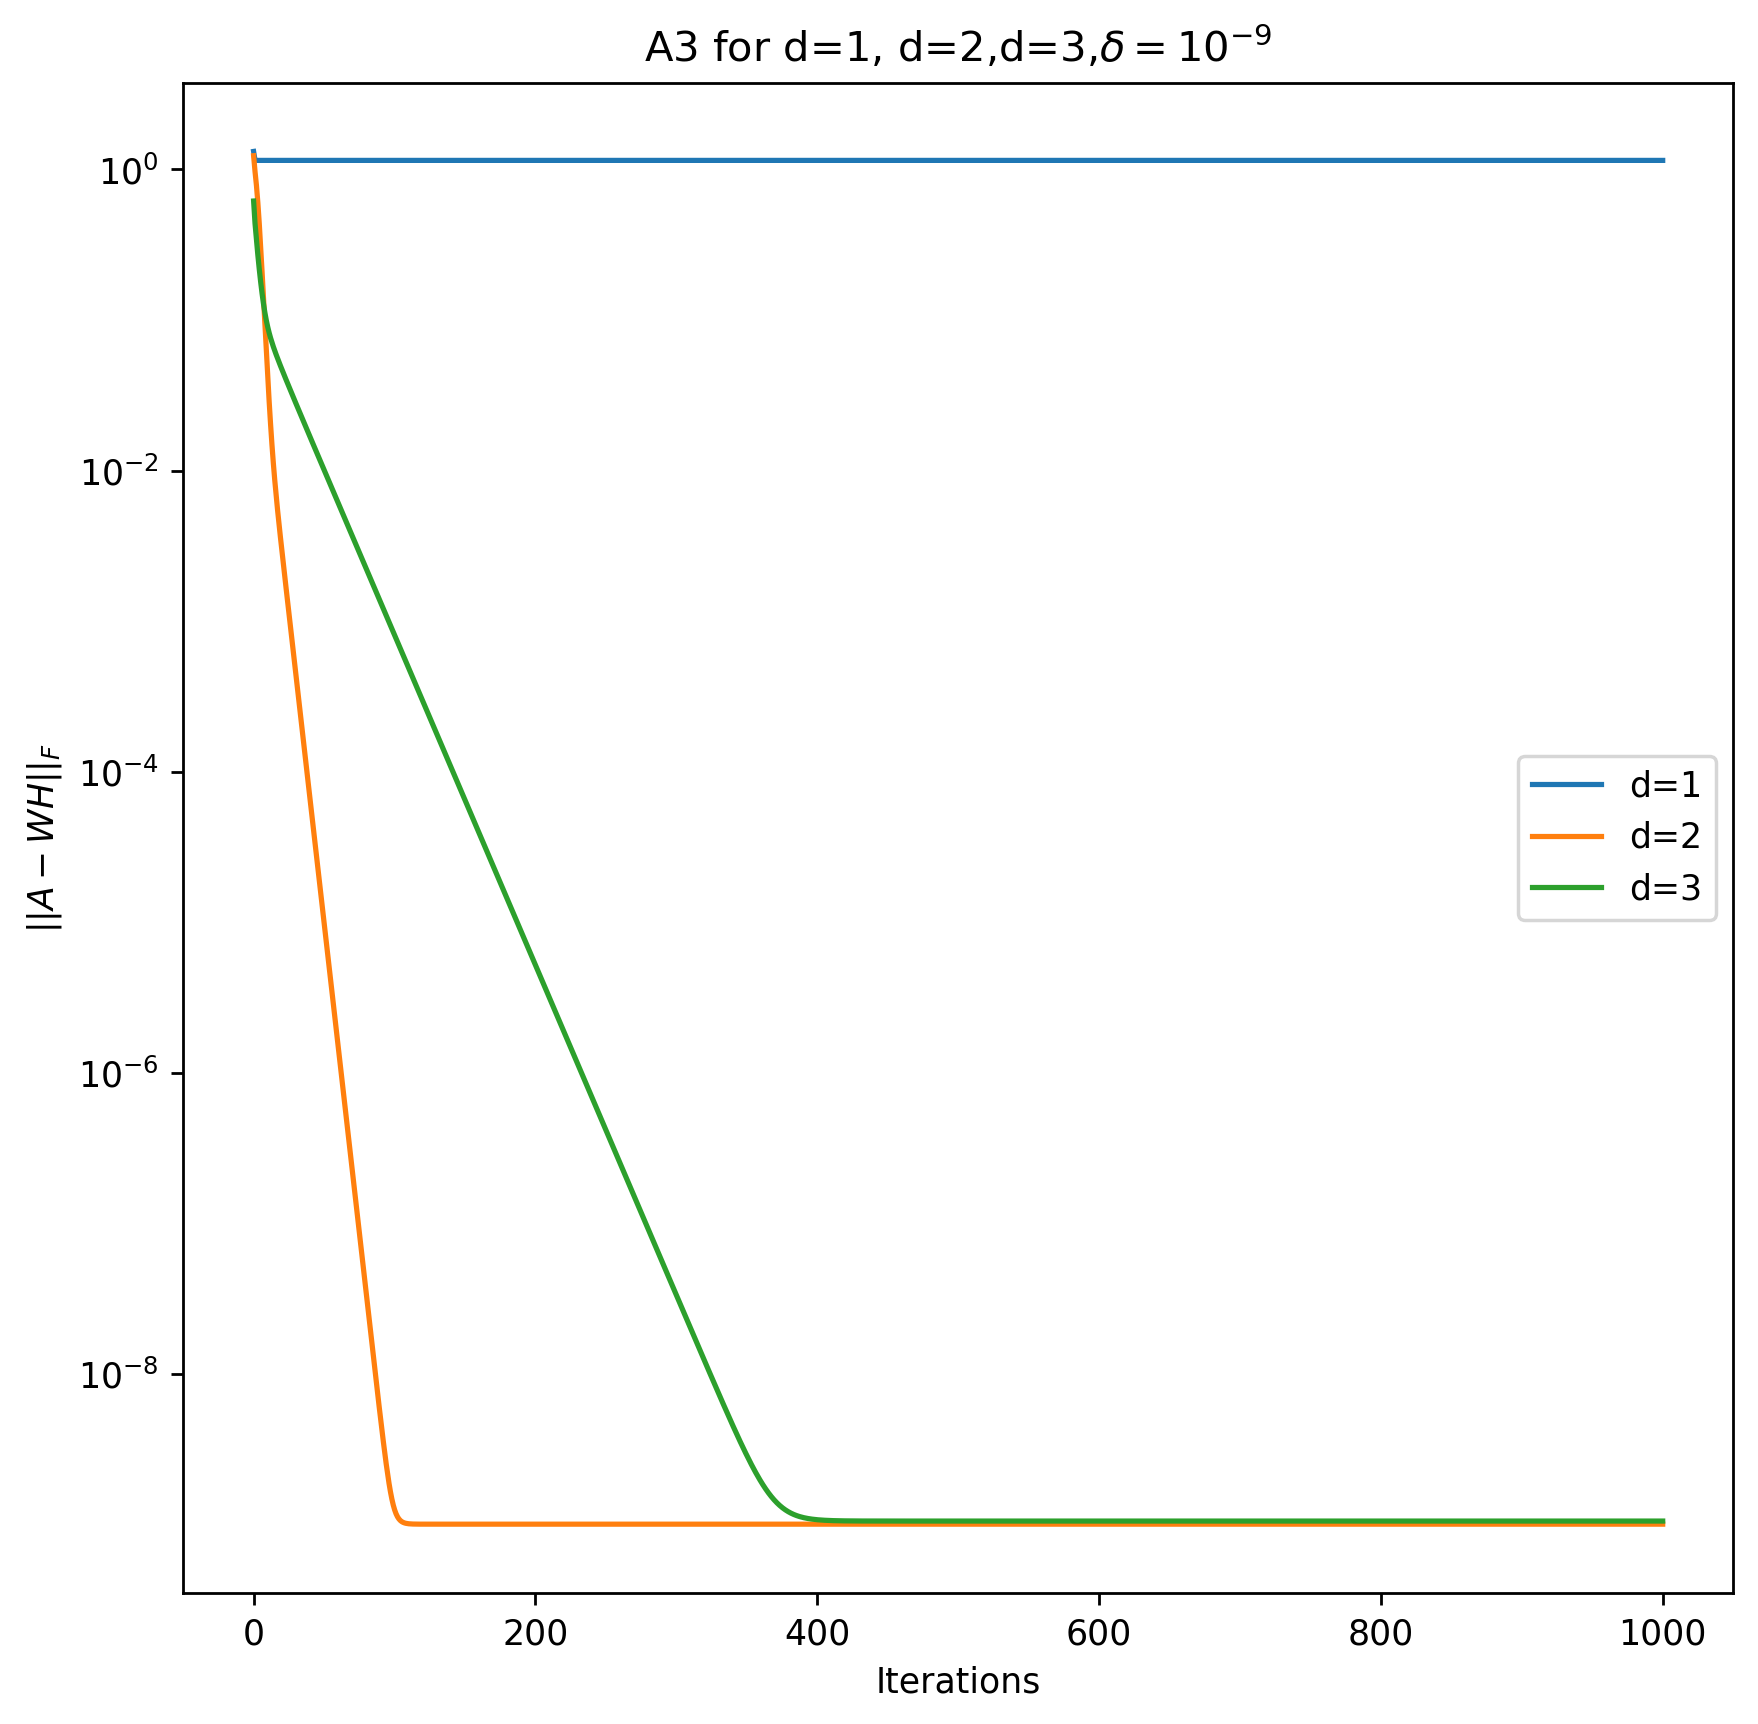

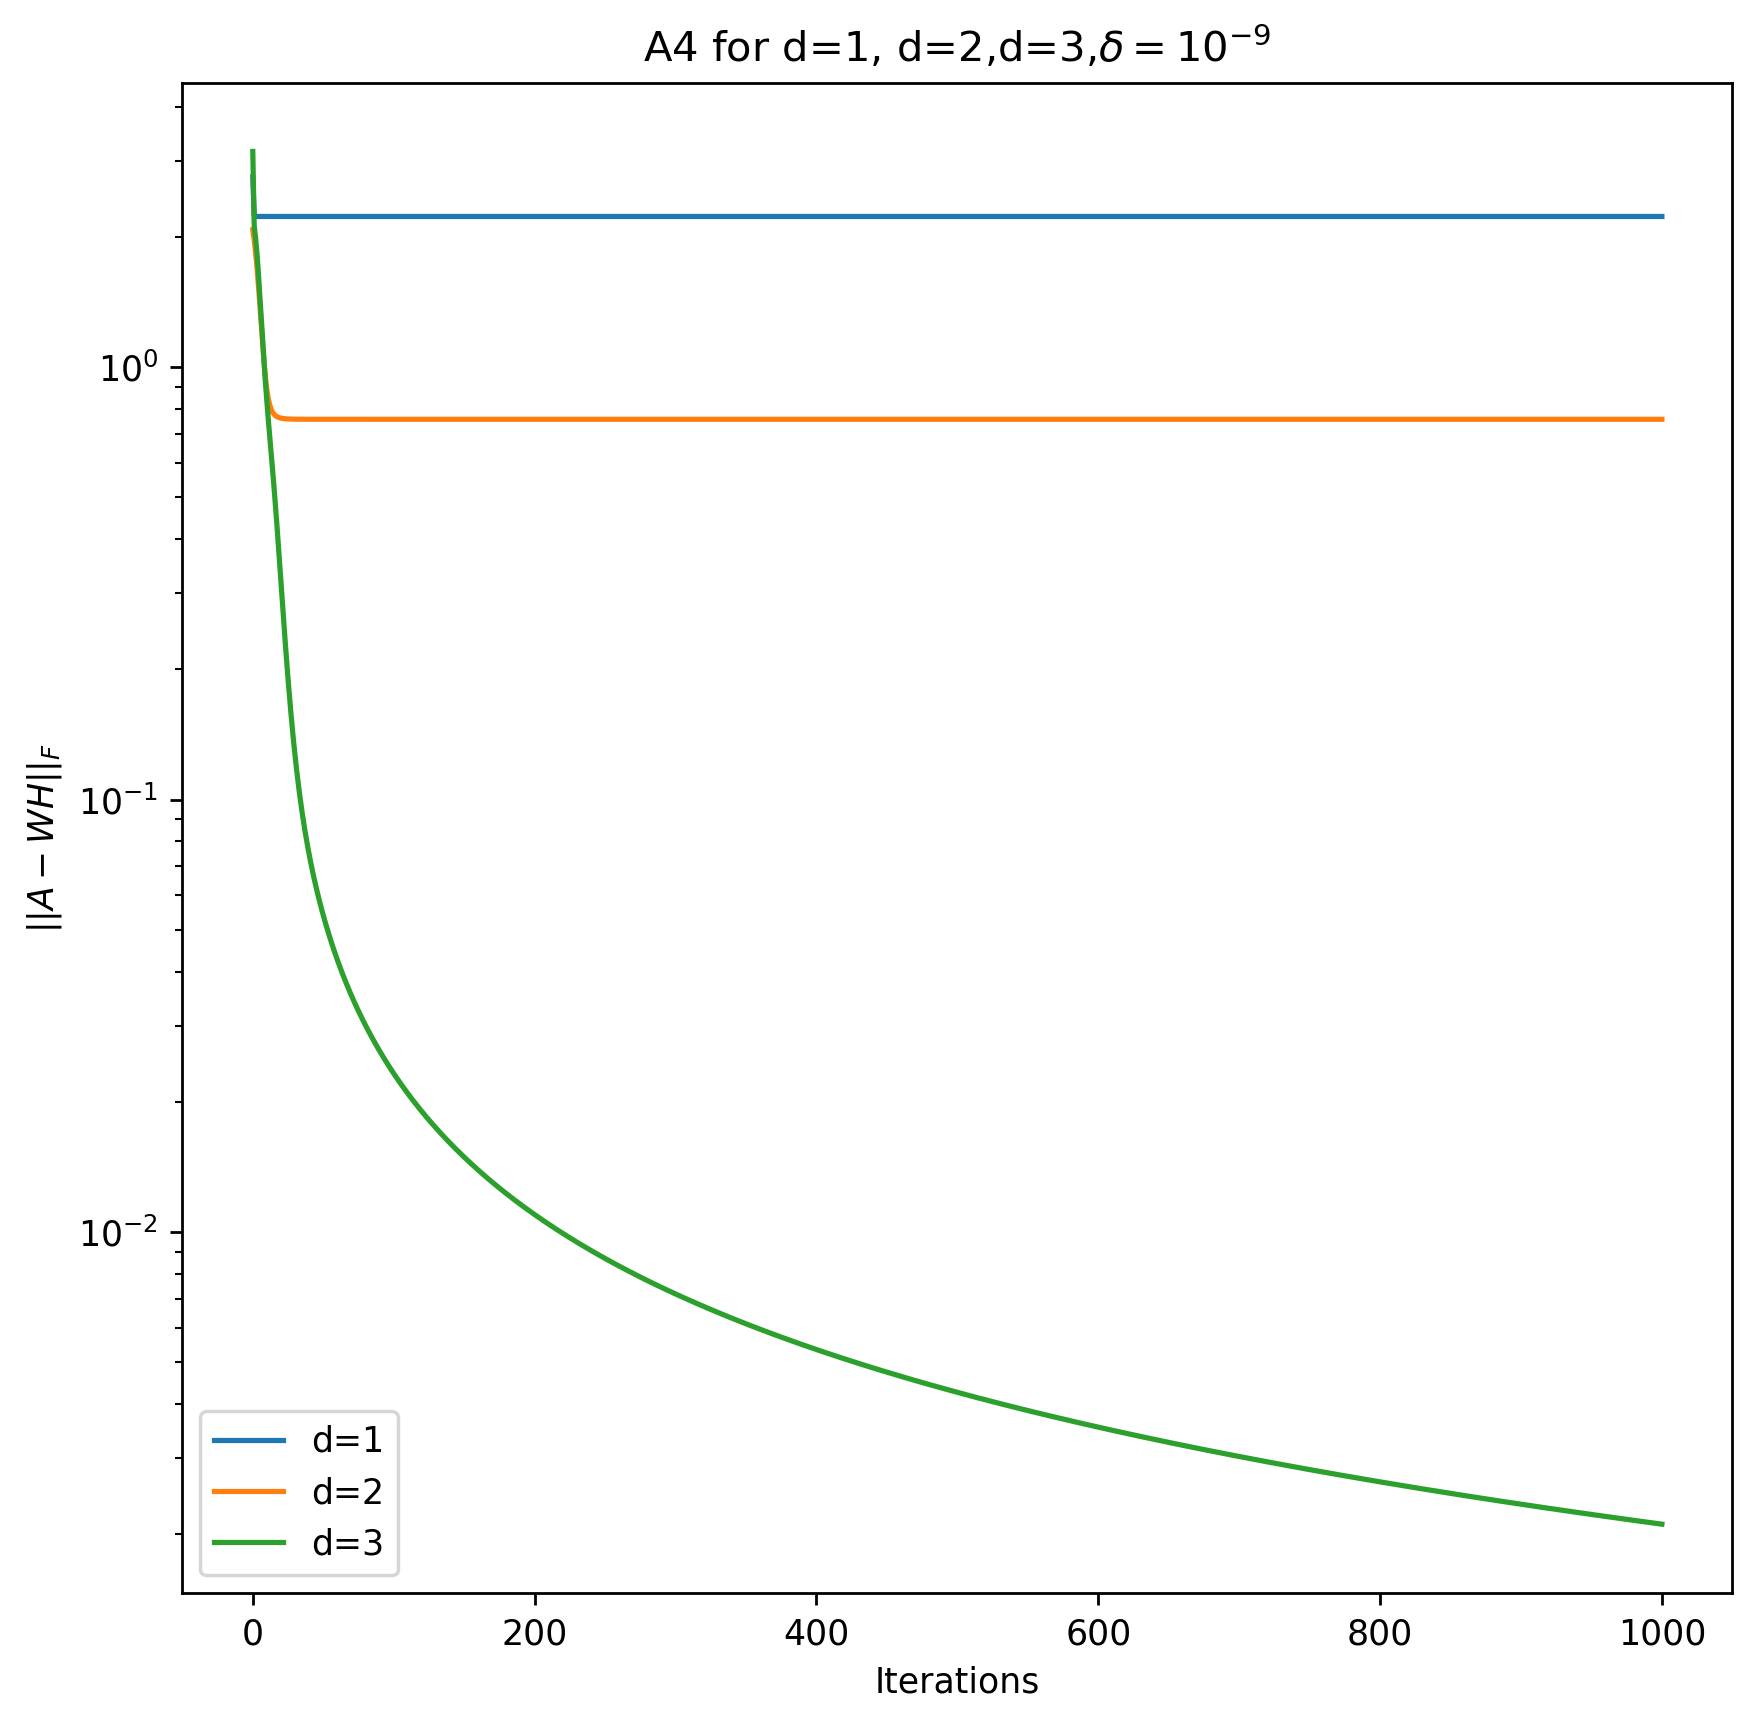

In [164]:
def norm_plotting():

    
    iters = np.linspace(0,1000,1000)
    #A3 data
    W_next_A3_1, H_next_A3_1, norms_A3_1 = NMF(A_3, 1, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_2, H_next_A3_2, norms_A3_2 = NMF(A_3, 2, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_3, H_next_A3_3, norms_A3_3 = NMF(A_3, 3, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    
    #A4 data
    W_next_A4_1, H_next_A4_1, norms_A4_1 = NMF(A_4, 1, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A4_2, H_next_A4_2, norms_A4_2 = NMF(A_4, 2, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A4_3, H_next_A4_3, norms_A4_3 = NMF(A_4, 3, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    
    #Plot A3
    plt.plot(iters,norms_A3_1,label = "d=1")
    plt.plot(iters,norms_A3_2,label= "d=2")
    plt.plot(iters,norms_A3_3,label = "d=3")
    plt.title(r"A3 for d=1, d=2,d=3,$\delta = 10^{-9}$")
    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel(r'$\vert\vert{A-WH}\vert\vert_F$')
    plt.legend()

    plt.show()

    #A4 plotting
    plt.figure(4)
    plt.plot(iters,norms_A4_1,label = "d=1")
    plt.plot(iters,norms_A4_2,label= "d=2")
    plt.plot(iters,norms_A4_3,label = "d=3")
    plt.title(r"A4 for d=1, d=2,d=3,$\delta = 10^{-9}$")
    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel(r'$\vert\vert{A-WH}\vert\vert_F$')
    plt.legend()

    plt.show()


norm_plotting()




As we just saw, the $A_3$ matrix has one of three eigenvalues equal to zero, which means that $d = 2$ is sufficient for the algorithm to converge to a small norm. Using $d = 3$ also works but takes more time to converge. $d = 3$ is also not very useful considering we are no longer reducing the number of dimensions but increasing it. d=1 converges to a large norm, meaning it's a bad approximation of the matrix. This seems reasonable enough, we would not expect one basis vector to yield a good approximation.  

As for $A_4$, all three eigenvalues are nonzero, so we need $d = 3$ to get a good approximation. $d = 3$ converges very slowly compared to $A_3$. We are not quite sure why, but presumably due to some property of the matrix in question. $d = 1$ and $d = 2$ converges to higher values, but with $d = 2$ giving a better approximation than $d = 1$, which seems reasonable as we have another basis vector to work with. 


It's certainly worth noting that for a few of the randomly initialized matrices, the norm increases slightly in the iterations prior to converging, as seen in this picture for $d = 2$:




![Picture title](image-20220401-114048.png)


This small bump at around $150$ iterations appears to be a consequence of the $\delta$ that we add to the divisor. For large values of delta, the phenomenon of slightly increasing norm before convergence is very clear. To show this, we have a plot with three different values for $\delta$.


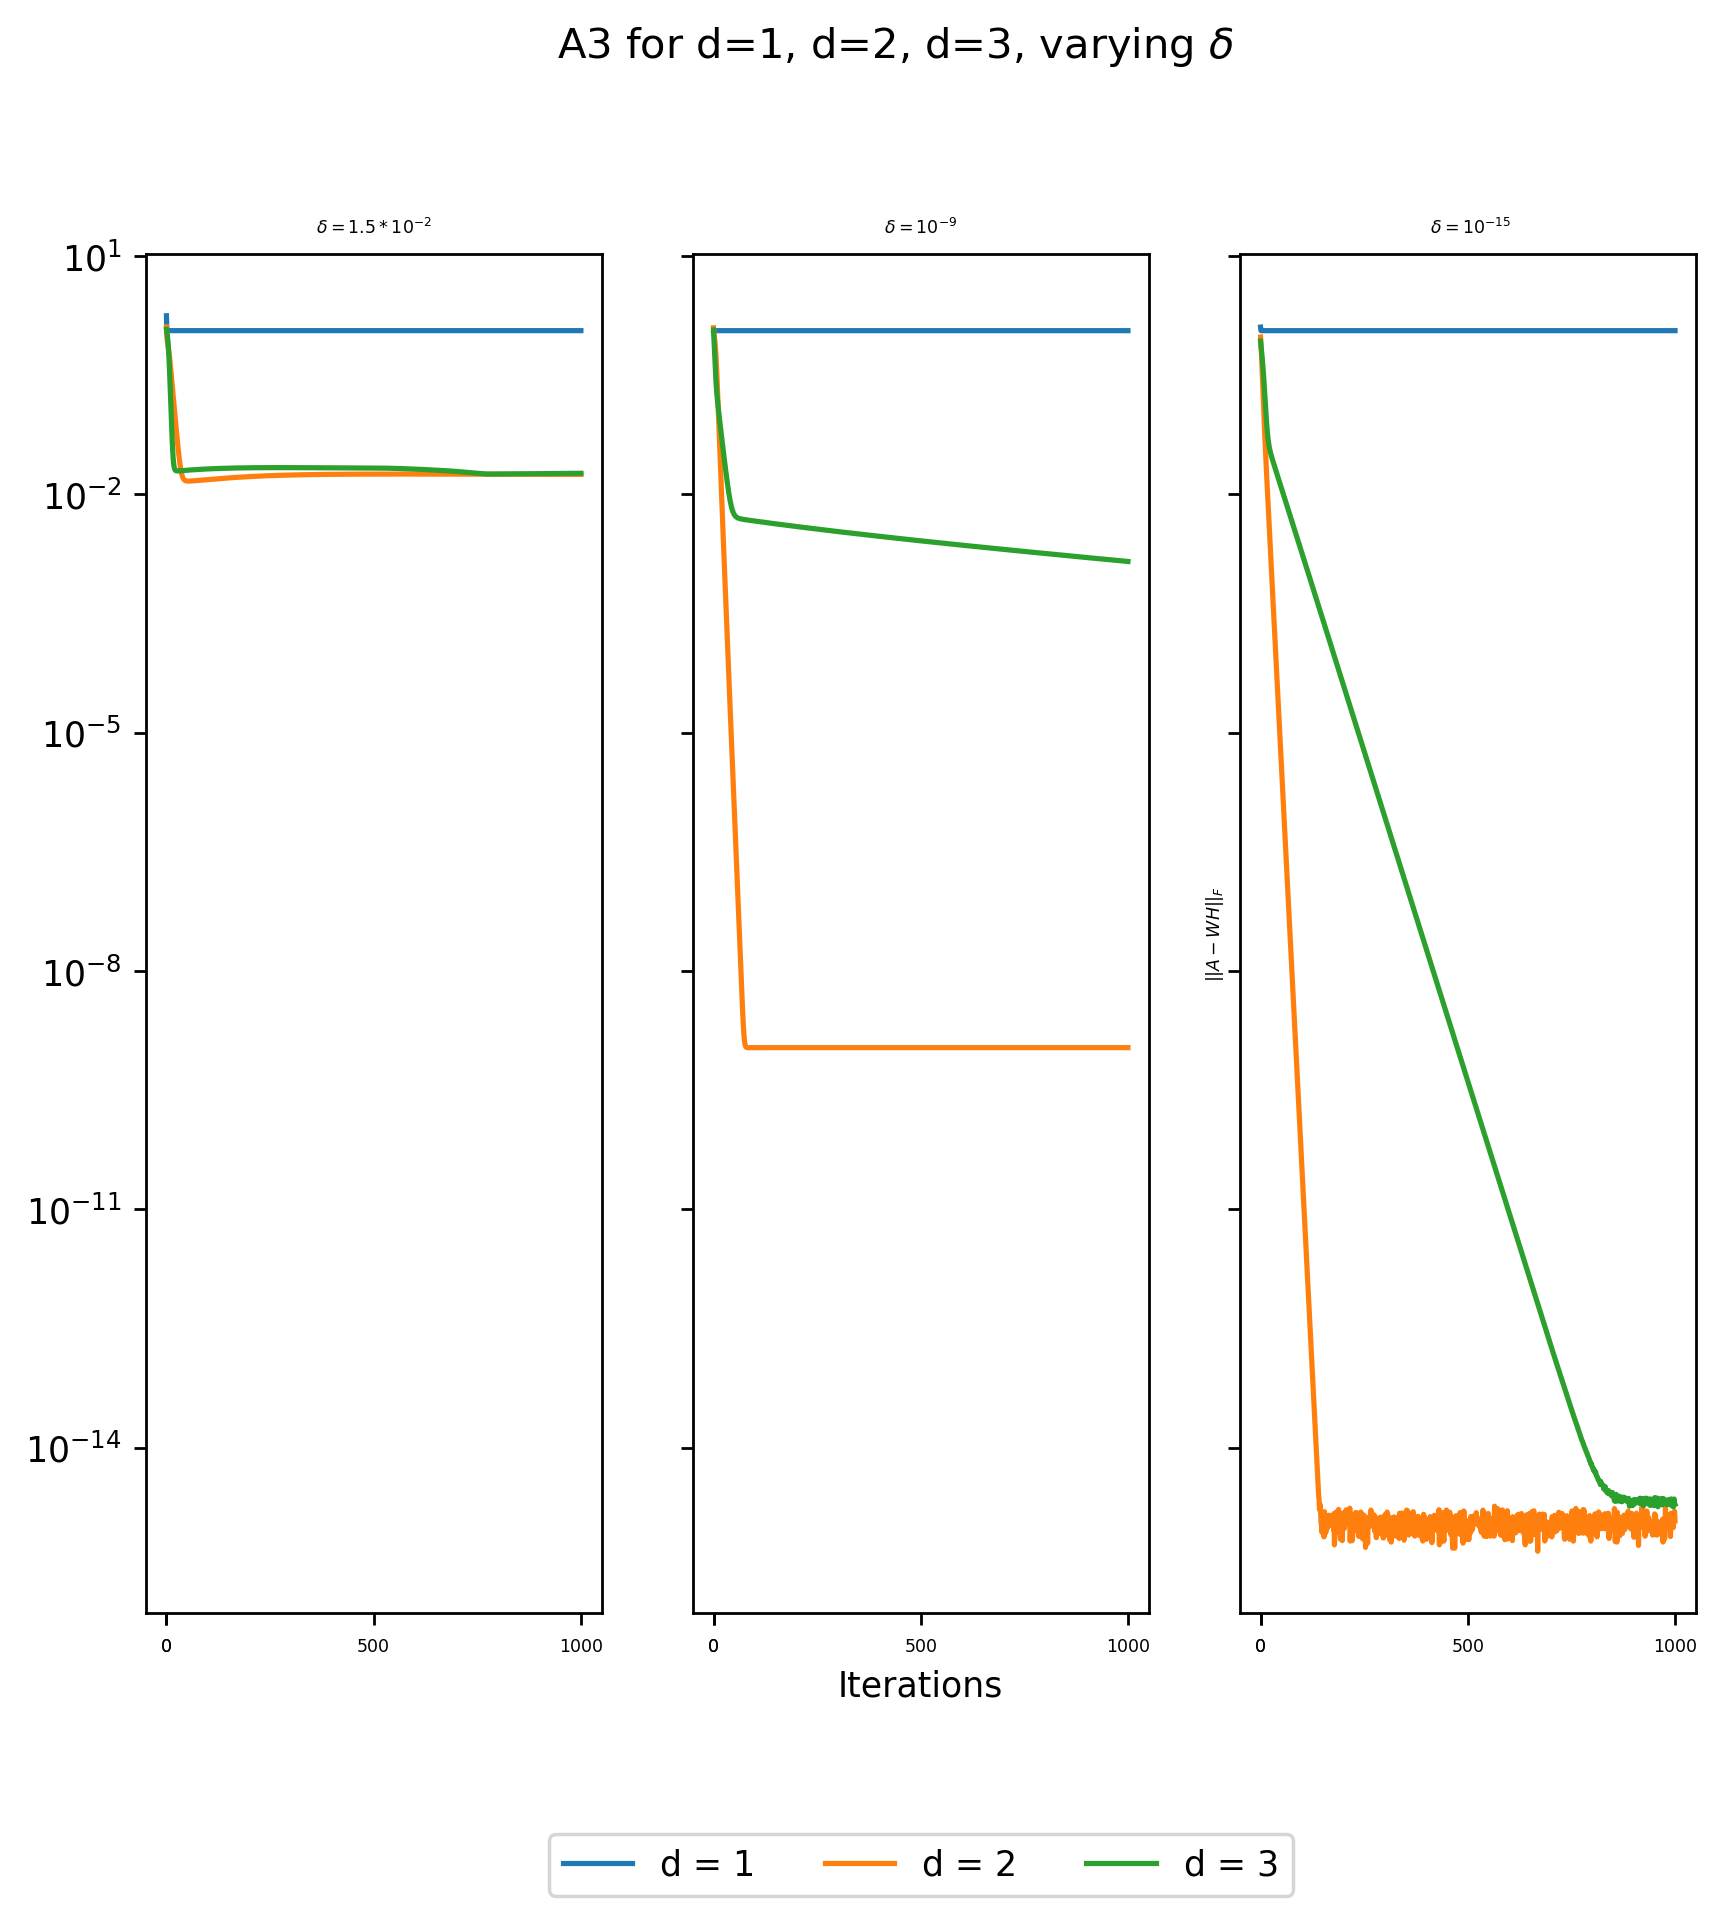

In [165]:
def different_deltas():
    iters = np.linspace(0,1000,1000)
    #A3 data
    W_next_A3_1, H_next_A3_1, norms_A3_1 = NMF(A_3, 1, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_2, H_next_A3_2, norms_A3_2 = NMF(A_3, 2, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_3, H_next_A3_3, norms_A3_3 = NMF(A_3, 3, delta = 1e-9, maxiter = 1000, seed = 0,store_norms=True)

    #A3 data, smaller delta
    W_next_A3_1_small, H_next_A3_1_small, norms_A3_1_small = NMF(A_3, 1, delta = 1e-15, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_2_small, H_next_A3_2_small, norms_A3_2_small = NMF(A_3, 2, delta = 1e-15, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_3_small, H_next_A3_3_small, norms_A3_3_small = NMF(A_3, 3, delta = 1e-15, maxiter = 1000, seed = 0,store_norms=True)
    
    #A3 data, larger delta
    W_next_A3_1_small, H_next_A3_1_small, norms_A3_1_big = NMF(A_3, 1, delta = 1.5e-2, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_2_small, H_next_A3_2_small, norms_A3_2_big = NMF(A_3, 2, delta = 1.5e-2, maxiter = 1000, seed = 0,store_norms=True)
    W_next_A3_3_small, H_next_A3_3_small, norms_A3_3_big = NMF(A_3, 3, delta = 1.5e-2, maxiter = 1000, seed = 0,store_norms=True)


    #Plot three subplots. 
    fig, (ax3, ax2,ax1) = plt.subplots(1, 3, constrained_layout=True, sharey=True,sharex=True)
    fig.suptitle("A3 for d=1, d=2, d=3, varying $\delta$")
    ax1.plot(iters, norms_A3_1_small,label = "d = 1")
    ax1.plot(iters, norms_A3_2_small,label = "d = 2")
    ax1.plot(iters, norms_A3_3_small,label = "d = 3")
    ax1.set_title(r" $\delta = 10^{-15}$",fontsize=5)
    ax1.set_ylabel(r'$\vert\vert{A-WH}\vert\vert_F$',fontsize=5)
    ax1.set_yscale('log')   
    
    ax2.plot(iters, norms_A3_1,label = "d = 1")
    ax2.plot(iters, norms_A3_2,label = "d = 2")
    ax2.plot(iters, norms_A3_3,label = "d = 3")
    ax2.set_title(r"$\delta = 10^{-9}$",fontsize=5)
    ax2.set_xlabel('Iterations')
    ax2.set_yscale('log')
    plt.yticks(fontsize=6)

    ax3.plot(iters, norms_A3_1_big,label = "d = 1")
    ax3.plot(iters, norms_A3_2_big,label = "d = 2")
    ax3.plot(iters, norms_A3_3_big,label = "d = 3")
    ax3.set_title(r"$\delta = 1.5 * 10^{-2}$",fontsize=5)
    ax3.set_yscale('log')

    # Reduce size of axis numbers. 
    # This is a strange solution, but it works. 
    x_axis_list = [0,0,500,1000]
    ax1.xaxis.set_ticks(x_axis_list)
    ax1.set_xticklabels(x_axis_list, fontsize=5) 
    ax2.set_xticklabels(x_axis_list, fontsize=5) 
    ax3.set_xticklabels(x_axis_list, fontsize=5) 
    ax1.yaxis.set_tick_params(labelsize=5)



    #shrink the plot to make place for a legend outside the plot 
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])

    # Put a legend below current axis. 
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=False, ncol=5)
    plt.show()
    



different_deltas()


The first of these plots show a very large $\delta$. This is of course only to demonstrate the phenomenon, one would never use such large values in practice. From this plot, we see clearly that the norm increases just before it converges.

From these three plots, we can also see that the $\delta$ is actually the limiter on how accurately we can factorize A. If we use $\delta = 1.5^{-2}$, the norm converges to around that value. If we were to set it to $10^{-15}$, we see that the norm oscillates somewhere around that value, due to machine precision issues.

So the theoretical result $\vert \vert A - W_{k+1} H_{K+1}\vert\vert_F \leq\vert \vert A - W_{k} H_{K}\vert\vert_F $ that holds for the original algorithm, does not always hold when we add the $\delta$. However, this is not a problem since it appears to hold as long as $\vert \vert A - W_{k} H_{K}\vert\vert_F > \delta $, and as long as our $\delta$ is large enough to avoid machine precision issues. 

In other words, the norm decreases right up to the equilibrium decided by the $\delta$, where it occasionally has a small dip, but this is fine. So overall this method works nicely, at least for factorizations that don't require uniqueness, or a global minima.



# 2 Analyzing CryptoPunks using NMF

Until now we have only used the factorization methods on randomly defined matrices. Although pure theoretical work is fun, the NMF method has many interesting real-world applications. For instance, analyzing pictures and finding common features is an extremely relevant use case where the NMF can be utilized. Since the CryptoPunks are constructed by adding different base features, we should be able to find these base features through the previously described method.


## 2.1 Observe the CryptoPunks

As mentioned, we will use CryptoPunks as the prime dataset to test the previously described matrix factorization method. Our dataset will include `10.000` algorithmically generated CryptoPunks, each with their unique set of traits. The following cell will be used to load the images from this dataset.


In [170]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces


For our analysis, we will mainly use `N = 500`. This means that we will just analyse `500` CryptoPunks out of the `10.000` in the dataset. To make sure we analyse the same set faces every time, we use the following function save these faces locally on our machine.


In [246]:
def generate_face_data():
    '''
    This funtion loads all images to numpy arrays and saves them to a selection of smaller arrays. This
    is to reduce runtime while testing the upcomming calculations.
    '''
    # Load all 10000 images
    faces = load_images(10000)

    # Select 500 random images
    N = 500
    choices = np.random.choice(faces.shape[-1],N, replace = False)
    faces_500 = faces[:,:,:,choices]
    assert (faces_500.shape == (24, 24, 4, 500))  # Make sure the dimensions are correct
    
    
    
    np.savez(
        'faces',
        faces = faces,
        faces_500 = faces_500,  # 500 faces
    )
generate_face_data()


These images have a dimension of `24x24` pixels, where each pixel is represented by four values (these values will also be referred to as channels). The first three channels (RGB) can present any colour by combining the additive base colours red, green, and blue. The last channel is called the alpha channel (A) and denotes the pixels opacity. All this information can then be packed into a `(24, 24, 4)` array which is fully able to represent a CryptoPunk. It is worth mentioning that by the nature of these pixelated images, the alpha values are either `0` or `1`. That is, either fully see-through or not at all see-through. As we are going be using a set of multiple images, the returned array will have another axis that differentiates the images.

It is convenient to view the image data, so we can create a function that takes in an array containing images and plots them in a grid.


In [247]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

To test that our loading- and plotting-functions work properly, we select and plot a subset of `64` CryptoPunks.

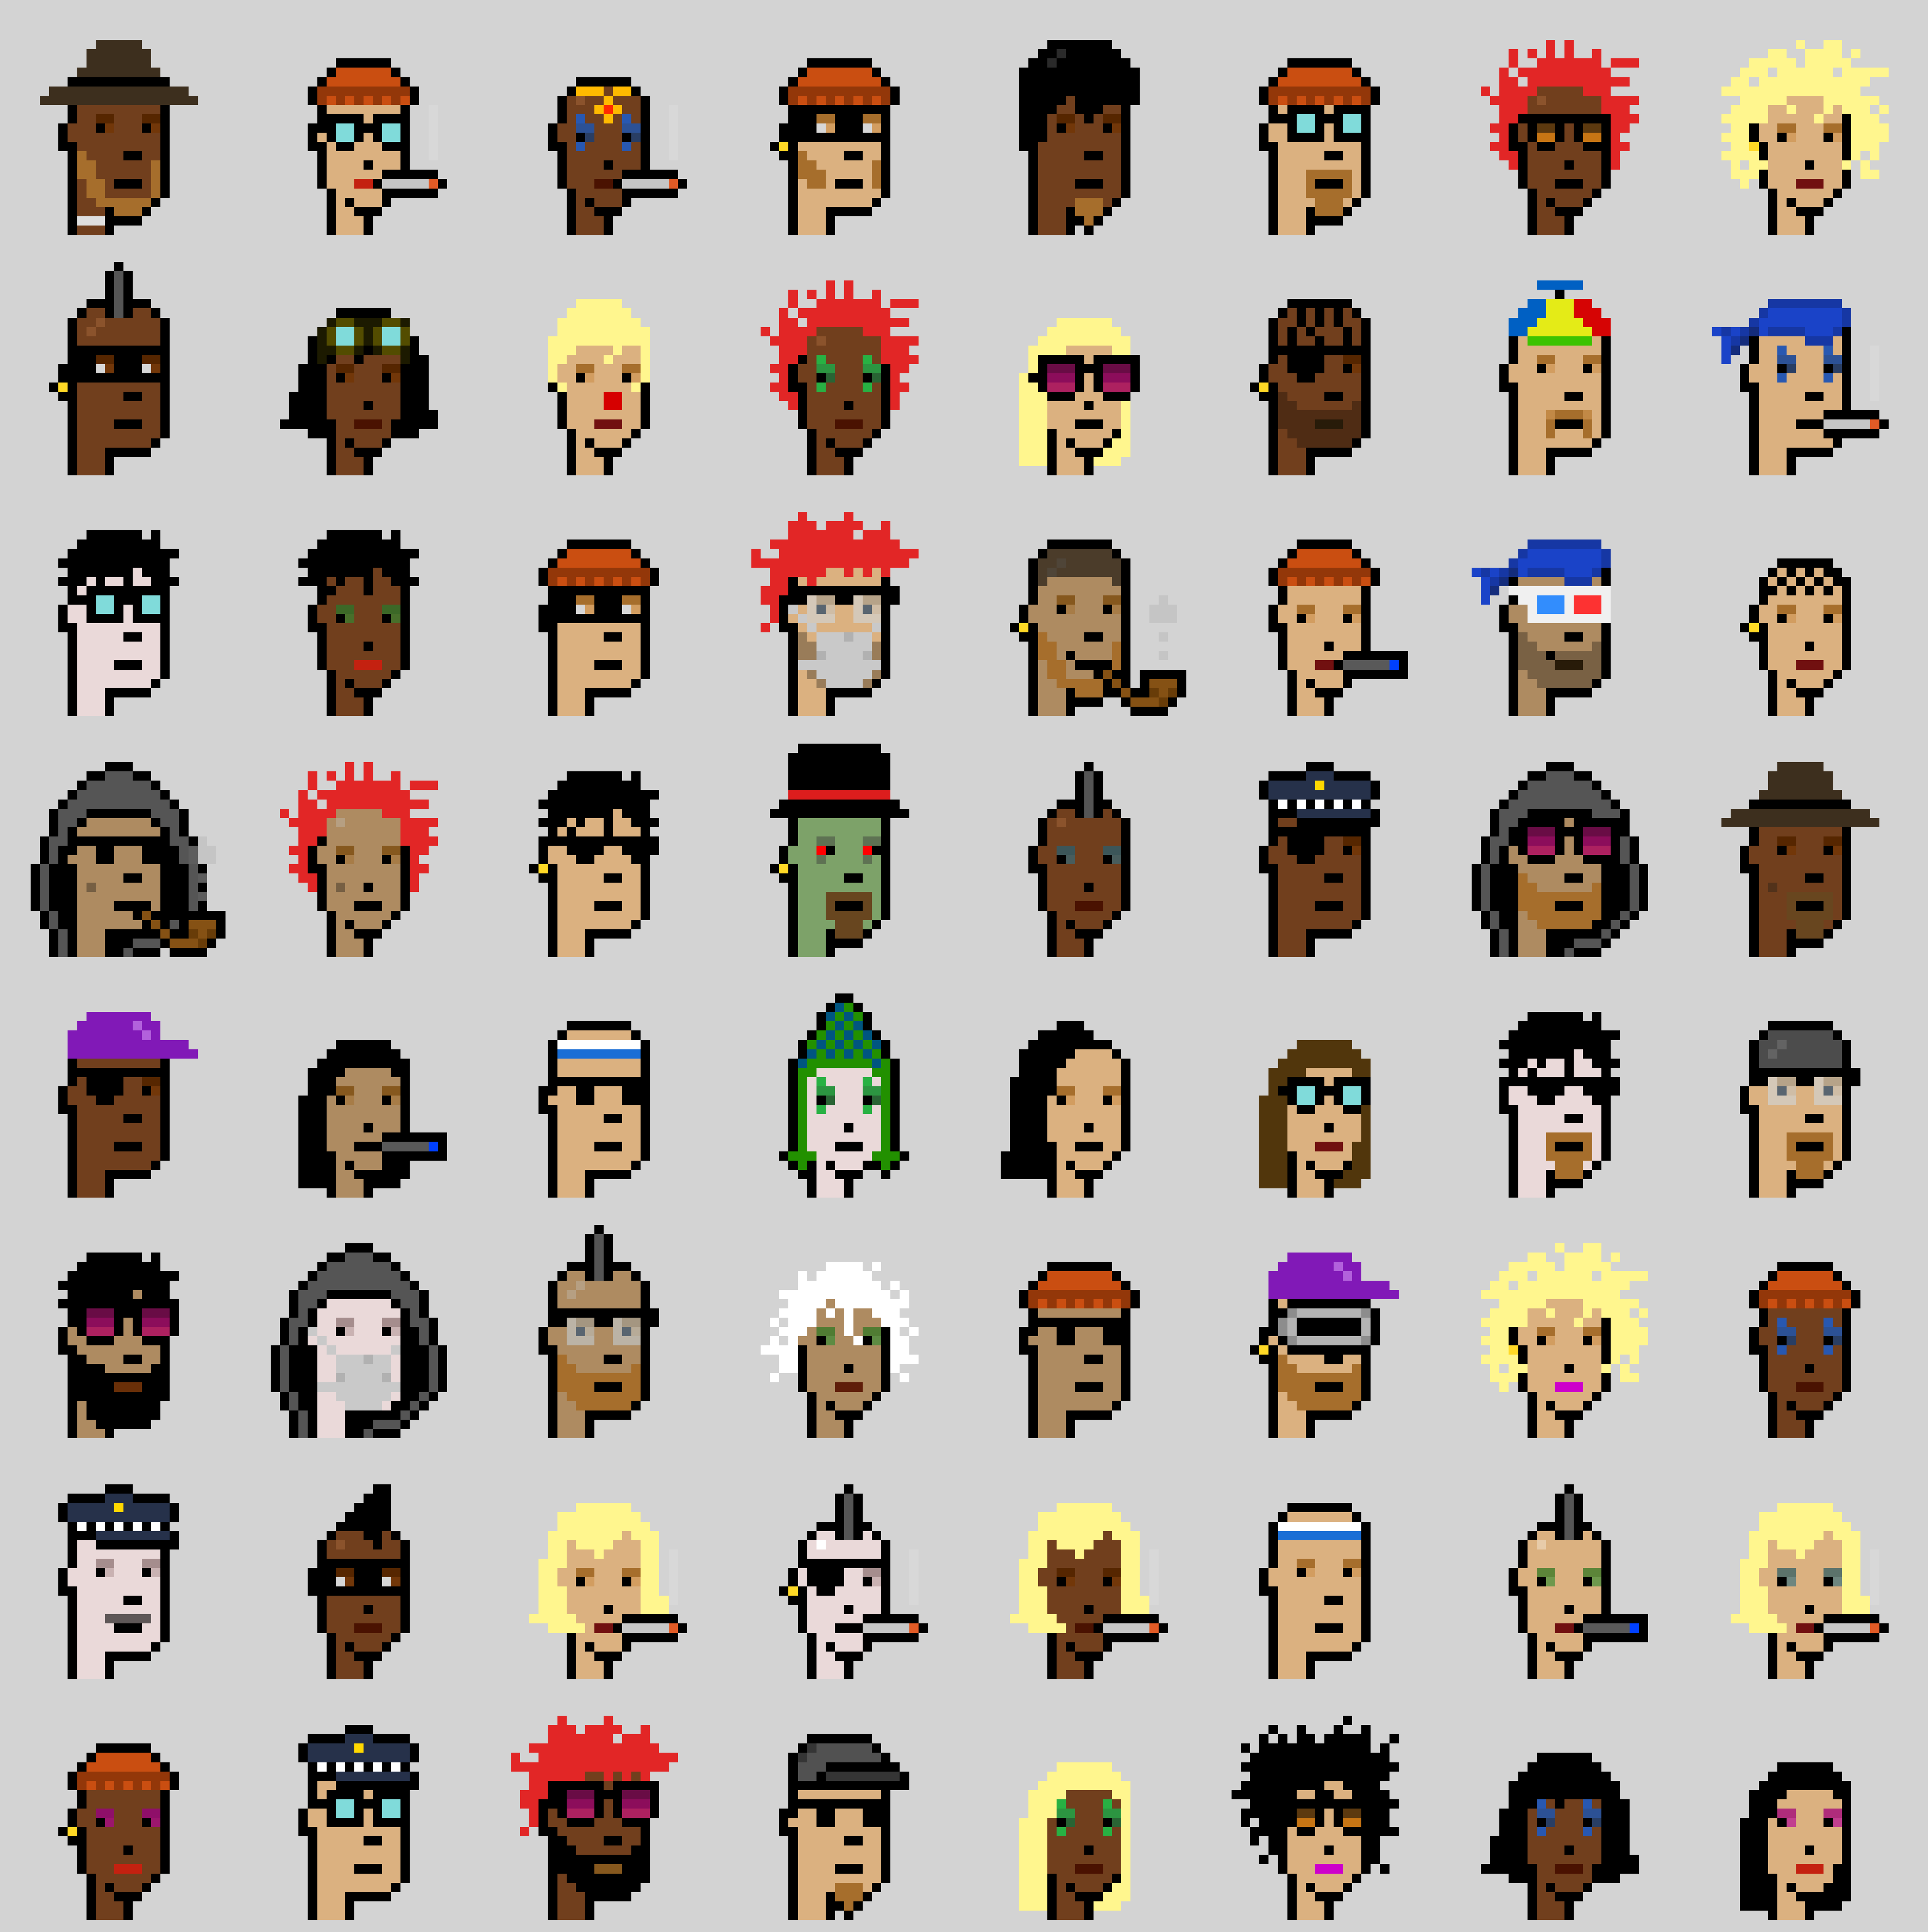

In [248]:
def plot_faces():
    # Load all 10000 images
    all_faces = np.load('faces.npz')

    faces = all_faces['faces_500']

    #Save the first face for later use
    first_face = faces[:,:,:,0]
    first_face_reshaped = np.reshape(first_face, (24, 24, 4, 1))   
    np.savez(
        "comparison_face_1",
        first_face_reshaped = first_face_reshaped
    )

    # Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
    plotimgs(faces, 8, filename="punks.png")
plot_faces()

## 2.2 Mean faces

Now that the CryptoPunks are acquired and properly loaded, and we can start analyzing them. Even though looking at a data sets average values is a rather savage approach to finding regularities, there still might arise some insightful information. The procedure we will use for finding the mean faces is to calculate the mean values for each channel over a set of `500` faces.


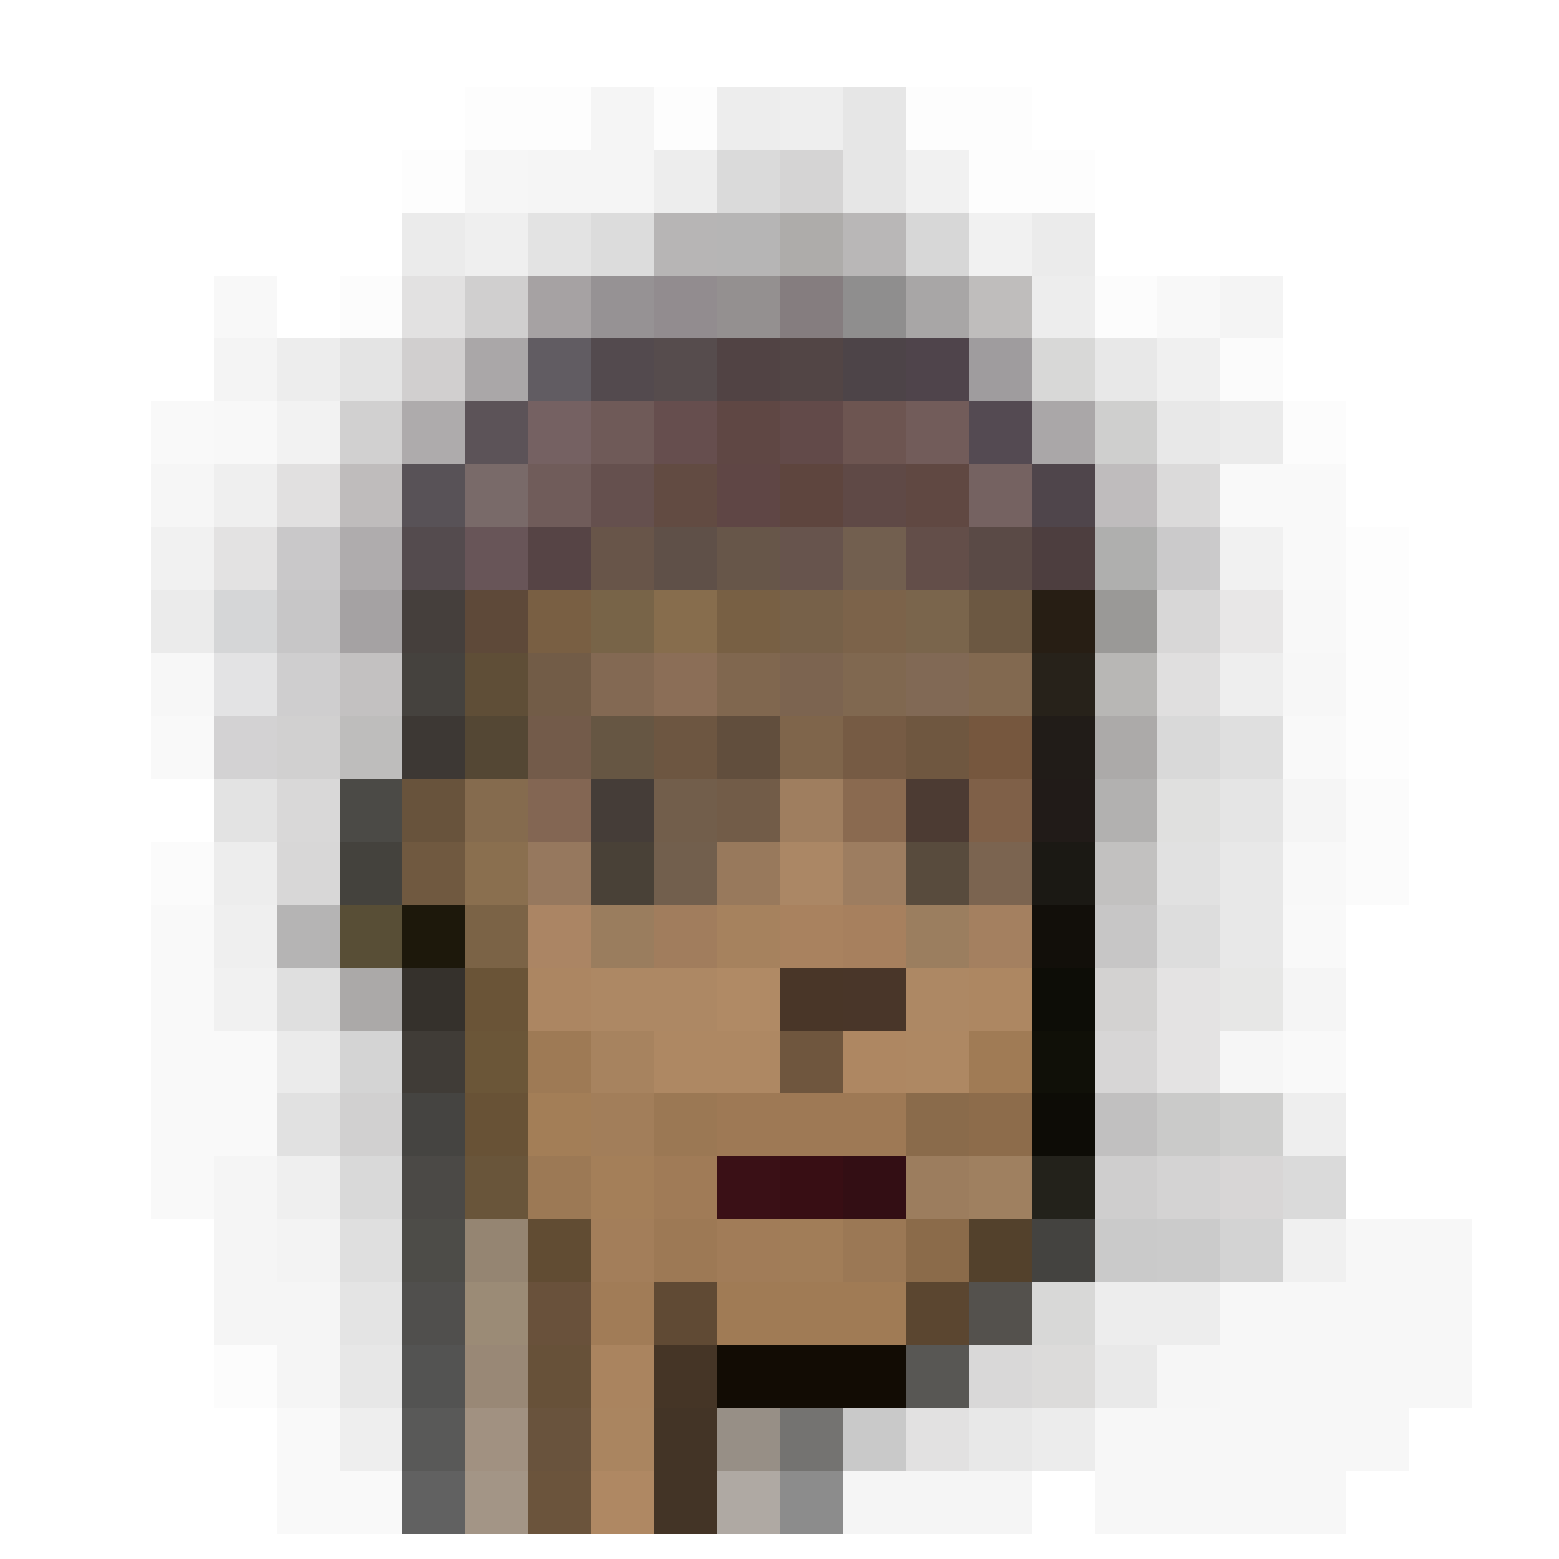

In [249]:
def find_mean_faces(face_data):
    '''
    Contrary to the name, this function does not actualy find 'mean' faces, but rather the mean value of each pixel
    in the faces dataset.
    Input:
        face_data: string, the face array for which we will calculate the mean
    The output is saved to a file as a 24*24*4 array:
        Filename:   mean_faces.npz
        Arraydata:  face_mean
    '''
    # Start by loading the faces that are to be used
    faces_data = np.load('faces.npz')
    faces = faces_data[face_data]

    # The images are stored on the last index of the faces array
    mean_face = np.mean(faces, axis = 3)
    assert(mean_face.shape == (24, 24, 4)) # assert the correct shape

    np.savez(
        'mean_face.npz',
        mean_face = mean_face
    )
    
    
    # Plotting
    plt.imshow(mean_face[:, :, :])
    plt.axis('off')
    plt.show()

find_mean_faces('faces')


From this image, we can see the what the 'average' face looks like. Features like the mouth and the contour of the head are quite clear since they don’t change much from face to face. On the other hand, areas like the top of the head are blurred and undefined. This tells us that this is a spot where there are a lot of differences between different characters. For example, one CryptoPunk might have a big red afro while another has a small blue cap. An average headpiece would then have to be something in between these two, which results of a quite undefined part of the image.



By plotting the mean face with a white background, one can easily - by looking at the opacity - tell that there most often appear pixels with opacity `1`. For example, spots where there only appears a light shade of grey tells us that these are areas where there rarely appear pixels with opacity. A common trend is that the further away from the centre of the face we go (except for downwards towards the neck), the pixels get more and more white. This makes sense intuitively, since most - if not all - of the CryptoPunks have pixels with opacity in the middle of their face, but fewer and fewer have it of a specific spot far away from the centre. It is hard to tell if there are any pixels that have no opacity for all images, because one could maybe misinterpret a pixel with a very light shade of grey as completely white. Yet, in the areas with the white colour, we can assume that there almost never appear pixels with opacity.

In order to gain even more information from this mean face, we can separate the different channels. To do so, we must first understand how the image is presented, and how the mean is calculated. We are calculating the "average colour" for each pixel, where every pixel is represented by four channels: red, green blue and opacity. So, the "average colour" is the average for each of these values, on every pixel in the image. It is relevant to ponder on the legitimacy of this presentation of colour, so we will present a small example.

Given a fully red `(1, 0, 0, 1)` and a fully green `(0, 1, 0, 1)` RGBA-pixel, their mean is calculated to be `(0.5, 0.5, 0, 1)`, which is represented as a darker yellow. This in and of itself is not a particularly interesting result. As we were interested in the "average colour" and got a completely new colour. If we however isolate the channels, then we might gain more insightful information. The opacity channel is also of particular interest, since we can expect its mean to represent the average amount of faces that use a given pixel.


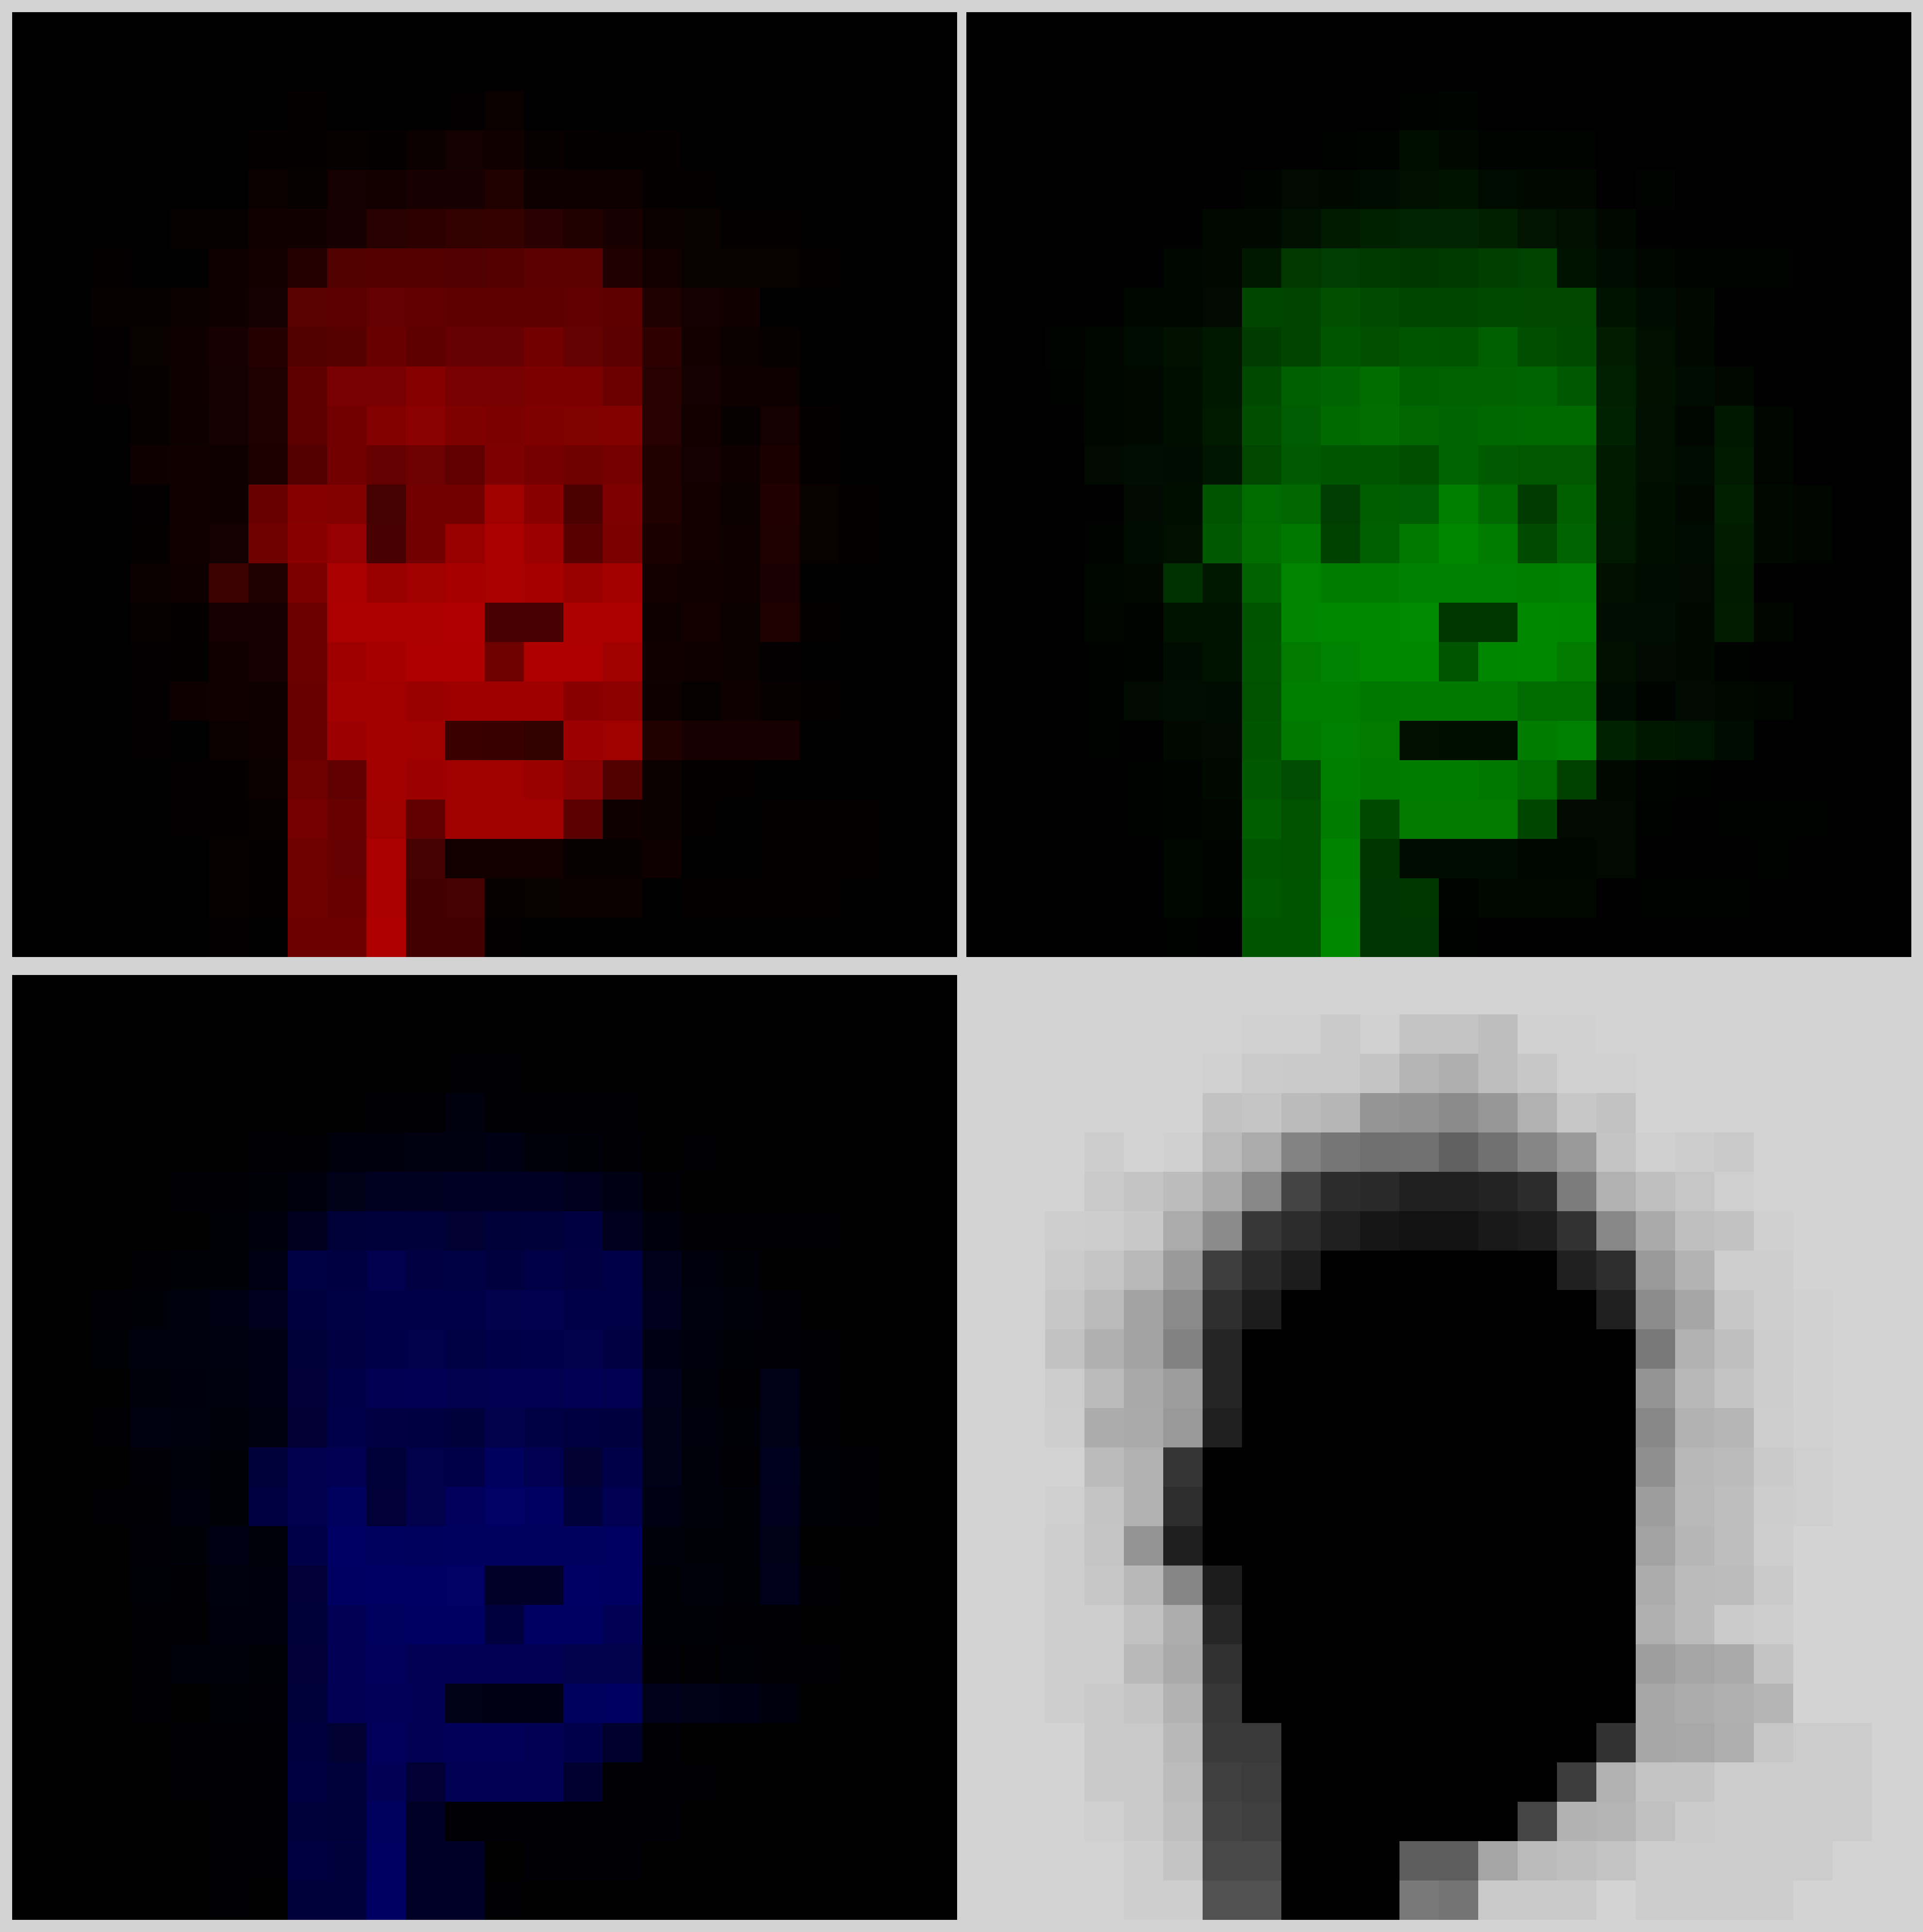

In [250]:
def mean_chanels():
    ####################################################
    # Load the relevant data
    face_data = np.load('mean_face.npz')
    mean_face = face_data['mean_face']
    assert(mean_face.shape == (24, 24, 4))
    
    # Array containing the four faces that are to be plotted
    faces = np.zeros(shape=(24, 24, 4, 4))

    
    #################################################### 
    #       Isolate the chanels

    # Red
    red_face = np.copy(mean_face)
    red_face[:,:,[1, 2]] = 0
    faces[:,:,:, 0] = red_face[:,:,:]
    
    # Green
    green_face = np.copy(mean_face)
    green_face[:,:,[0, 2]] = 0
    faces[:,:,:, 1] = green_face[:,:,:]
    

    # Blue
    blue_face = np.copy(mean_face)
    blue_face[:,:,[0, 1]] = 0
    faces[:,:,:, 2] = blue_face[:,:,:]
    
    # Want all the color channels to have full opacity
    faces[:, :, 3, [0, 1, 2]] = 1

    # Opacity
    opacity_face = np.copy(mean_face)
    opacity_face[:,:,[0, 1, 2]] = 0
    faces[:,:,:, 3] = opacity_face[:,:,:]

    ####################################################    
    #       Plot all four singular chanels
    plotimgs(faces, 2)

    
    
mean_chanels()



<strong>The colour channels</strong>

Here we can observe the average amount of colour for each channel. To little surprise, each of the colour channels look fairly similar, this indicates a fairly uniform distribution among the different RBG-values. However, one small distinction we are able to observe is the one pixel around the left ear of the face that is present among the red and green channels, but not the blue. This might be a fragment from the faces that have a yellow earring, as yellow is a product from adding RGB-red and -green.




<strong>The colour channels</strong>

Here we can observe the average amount of colour for each channel. To little surprise, each of the colour channels look fairly similar, this indicates a fairly uniform distribution among the different RBG-values. However, one small distinction we are able to observe is the one pixel around the left ear of the face that is present among the red and green channels, but not the blue. This might be a fragment from the faces that have a yellow earring, as yellow is a product from adding RGB-red and -green.



### 2.2.1 Repeating information
There's one more thing worth discussing about the mean face: The fact that the average image displays a face-like shape, tells us that there is a lot of repeating information in the dataset. One way to quantify the amount of repeating information in the matrix, is to investigate the rank of the matrix. The rank tells us how many independent face-vectors we have in the matrix.

A good method of finding the rank of a matrix is by using the known property from SVD, that the number of non-zero singular values of a matrix $A$ correspond to the rank of $A$. Using `numpy.linalg.svd()` we are able to acquire the singular value decomposition, and find the number of non-zero elements in $\Sigma$, note that we use a tolerance `tol=1e-12` similar to machine error.


In [251]:
def img_matrix_ranks(faces):
    '''
    This function will take in an array containing images represented by matrices, and return
    an array of the respective matrix ranks
    Input:
        faces: (24, 24, 4, N) array where N denotes the amount of images
    Output:
        ranks: N-array containing the resp. matrix ranks
    '''
    tol = 1e-12 # The tolerance for what we will count as zero

    # Find the Matrix containing the singular values of the current face 
    Sigma = np.linalg.svd(faces)[1]

    s = np.nonzero(Sigma > tol)
    ranks = np.shape(s)[1]
    return ranks

In [252]:
def find_ranks():

    # Load the relevant data
    face_data = np.load('faces.npz')
    faces = face_data['faces_500']

    # Calculate the ranks of the matrices
    N=500
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)
    ranks = img_matrix_ranks(faces_reshaped)
    print(f" Rank of matrix: {ranks}")
    
find_ranks()

 Rank of matrix: 385



We calculated that the rank with $500$ images is $385$. If we think of each image as a vector, all $500$ images can in theory be described as a linear combination of only $385$ images. Which in turn implies that we should be fairly successful in reducing the amount of data.


Up to this point we have managed to verify that NMF is a viable method of matrix factorization, the CryptoPunk images can be represented by non-negative matrices, and that the CryptoPunk faces are all positioned at the centre of the frame. It does not take a genius to figure out what we plan on doing next.


## 2.3 Face factorization

As previously suggested, we are now going to apply the NMF method on our CryptoPunk dataset. One of the motivations for doing so is to be able to store a large amount of the CryptoPunk-images using a much smaller amount of storage space than before. In addition, it will be interesting to observe which common properties the NMF algorithm can come up with.

An important caveat here is that the NMF approach only works because the CryptoPunk figures are perfectly centred, so if a shared feature such as a cap or hairstyle appears, it will be at the exact same position. If this was not the case, the method would not work at all. 

To make the calculations and plotting simpler, we first create a couple of utility-functions that can be called later in the code.



In [253]:
def split_and_reshape(faces, N):
    '''
    Splitting the faces into RGB- and opacity-channel, and reshaping the faces

    Input:
        faces: array
        N: number of faces
    
    Output:
        faces_rgb: array, the RBG-channel
        faces_opacity: array, the opacity-channel
        faces_reshaped: array, the reshaped faces-array
    '''
    # Split the images into opacity and rgb channels
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape

    # Clever reshape "trick". This is the matrix we will apply the NMF to
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

    return faces_rgb, faces_opacity, faces_reshaped

In [254]:
def plot_W_columns(W, d_val):
    '''
    Plot the columns of the W-matrix. This will reveal the important features of the faces.

    Input:
        W: array, the W-matrix
        d_val: int, the number of columns in the W-matrix
    '''
    # Reshaping the W-matrix
    W = np.reshape(W, (24, 24, 3, d_val))
    assert (W.shape == (24, 24, 3, d_val))

    # Plotting the columns of W 
    plotimgs(W, nplot = 8, rescale = True, filename = None)


The following cell calculates the $W$-matrix using NMF with `d` basis vectors. These columns will then be plotted to gain some visual insight into the main properties that often reoccur throughout the images. 



In [255]:
def calculate_and_plot_features(d_val = 64):
    '''
    Calculating and plotting the features of the previously generated faces. 
    '''
    # Importing the faces-data
    faces_data = np.load('faces.npz')
    faces = faces_data['faces_500']
  
    N = 500 # the number of faces imported

    # Splittiing the faces into different channels and reshaping
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)
    
    W, H = NMF(faces_reshaped, d_val)
    
    #Dynamic plotting to make it look nice for different values of d

    #For values over 10, we will make use of columns. 
    if d_val > 10:
        # Plotting the columns
        plot_W_columns(W, d_val)
        return


    fig, axes = plt.subplots(1,d_val,figsize=(16,16),dpi=100)
    
    W = np.reshape(W, (24, 24, 3, d_val))
    assert (W.shape == (24, 24, 3, d_val))

    #edge case for d=1
    if d_val == 1:
        scaled_img = np.copy(W[:,:,:,0])
        scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
        axes.imshow(scaled_img)
        axes.axis('off')
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.tight_layout()
        plt.show()

        #Comparison of rank 1 approximation and the mean face.
        # Not the best practice, but works fine for our needs.
        mean_face_file = np.load('mean_face.npz')
        mean_face = np.reshape(mean_face_file['mean_face'],(24,24,4,1))
        placeholder, placeholder, mean_face_reshaped = split_and_reshape(mean_face, 1)
        scaled_image_reshaped = scaled_img.reshape(np.prod(np.shape(scaled_img))//1, 1)
        diff = mean_face_reshaped - scaled_image_reshaped       
        norm = np.linalg.norm(diff,'fro')
        print(f"Frobenius distance between Rank 1 approximation and the mean: {norm:.4f}")
        return

    #For when 1<d<11
    for i in range(d_val):
        scaled_img = np.copy(W[:,:,:,i])
        scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
        axes[i].imshow(scaled_img)
        axes[i].axis('off')
        plt.tight_layout()
    plt.show()

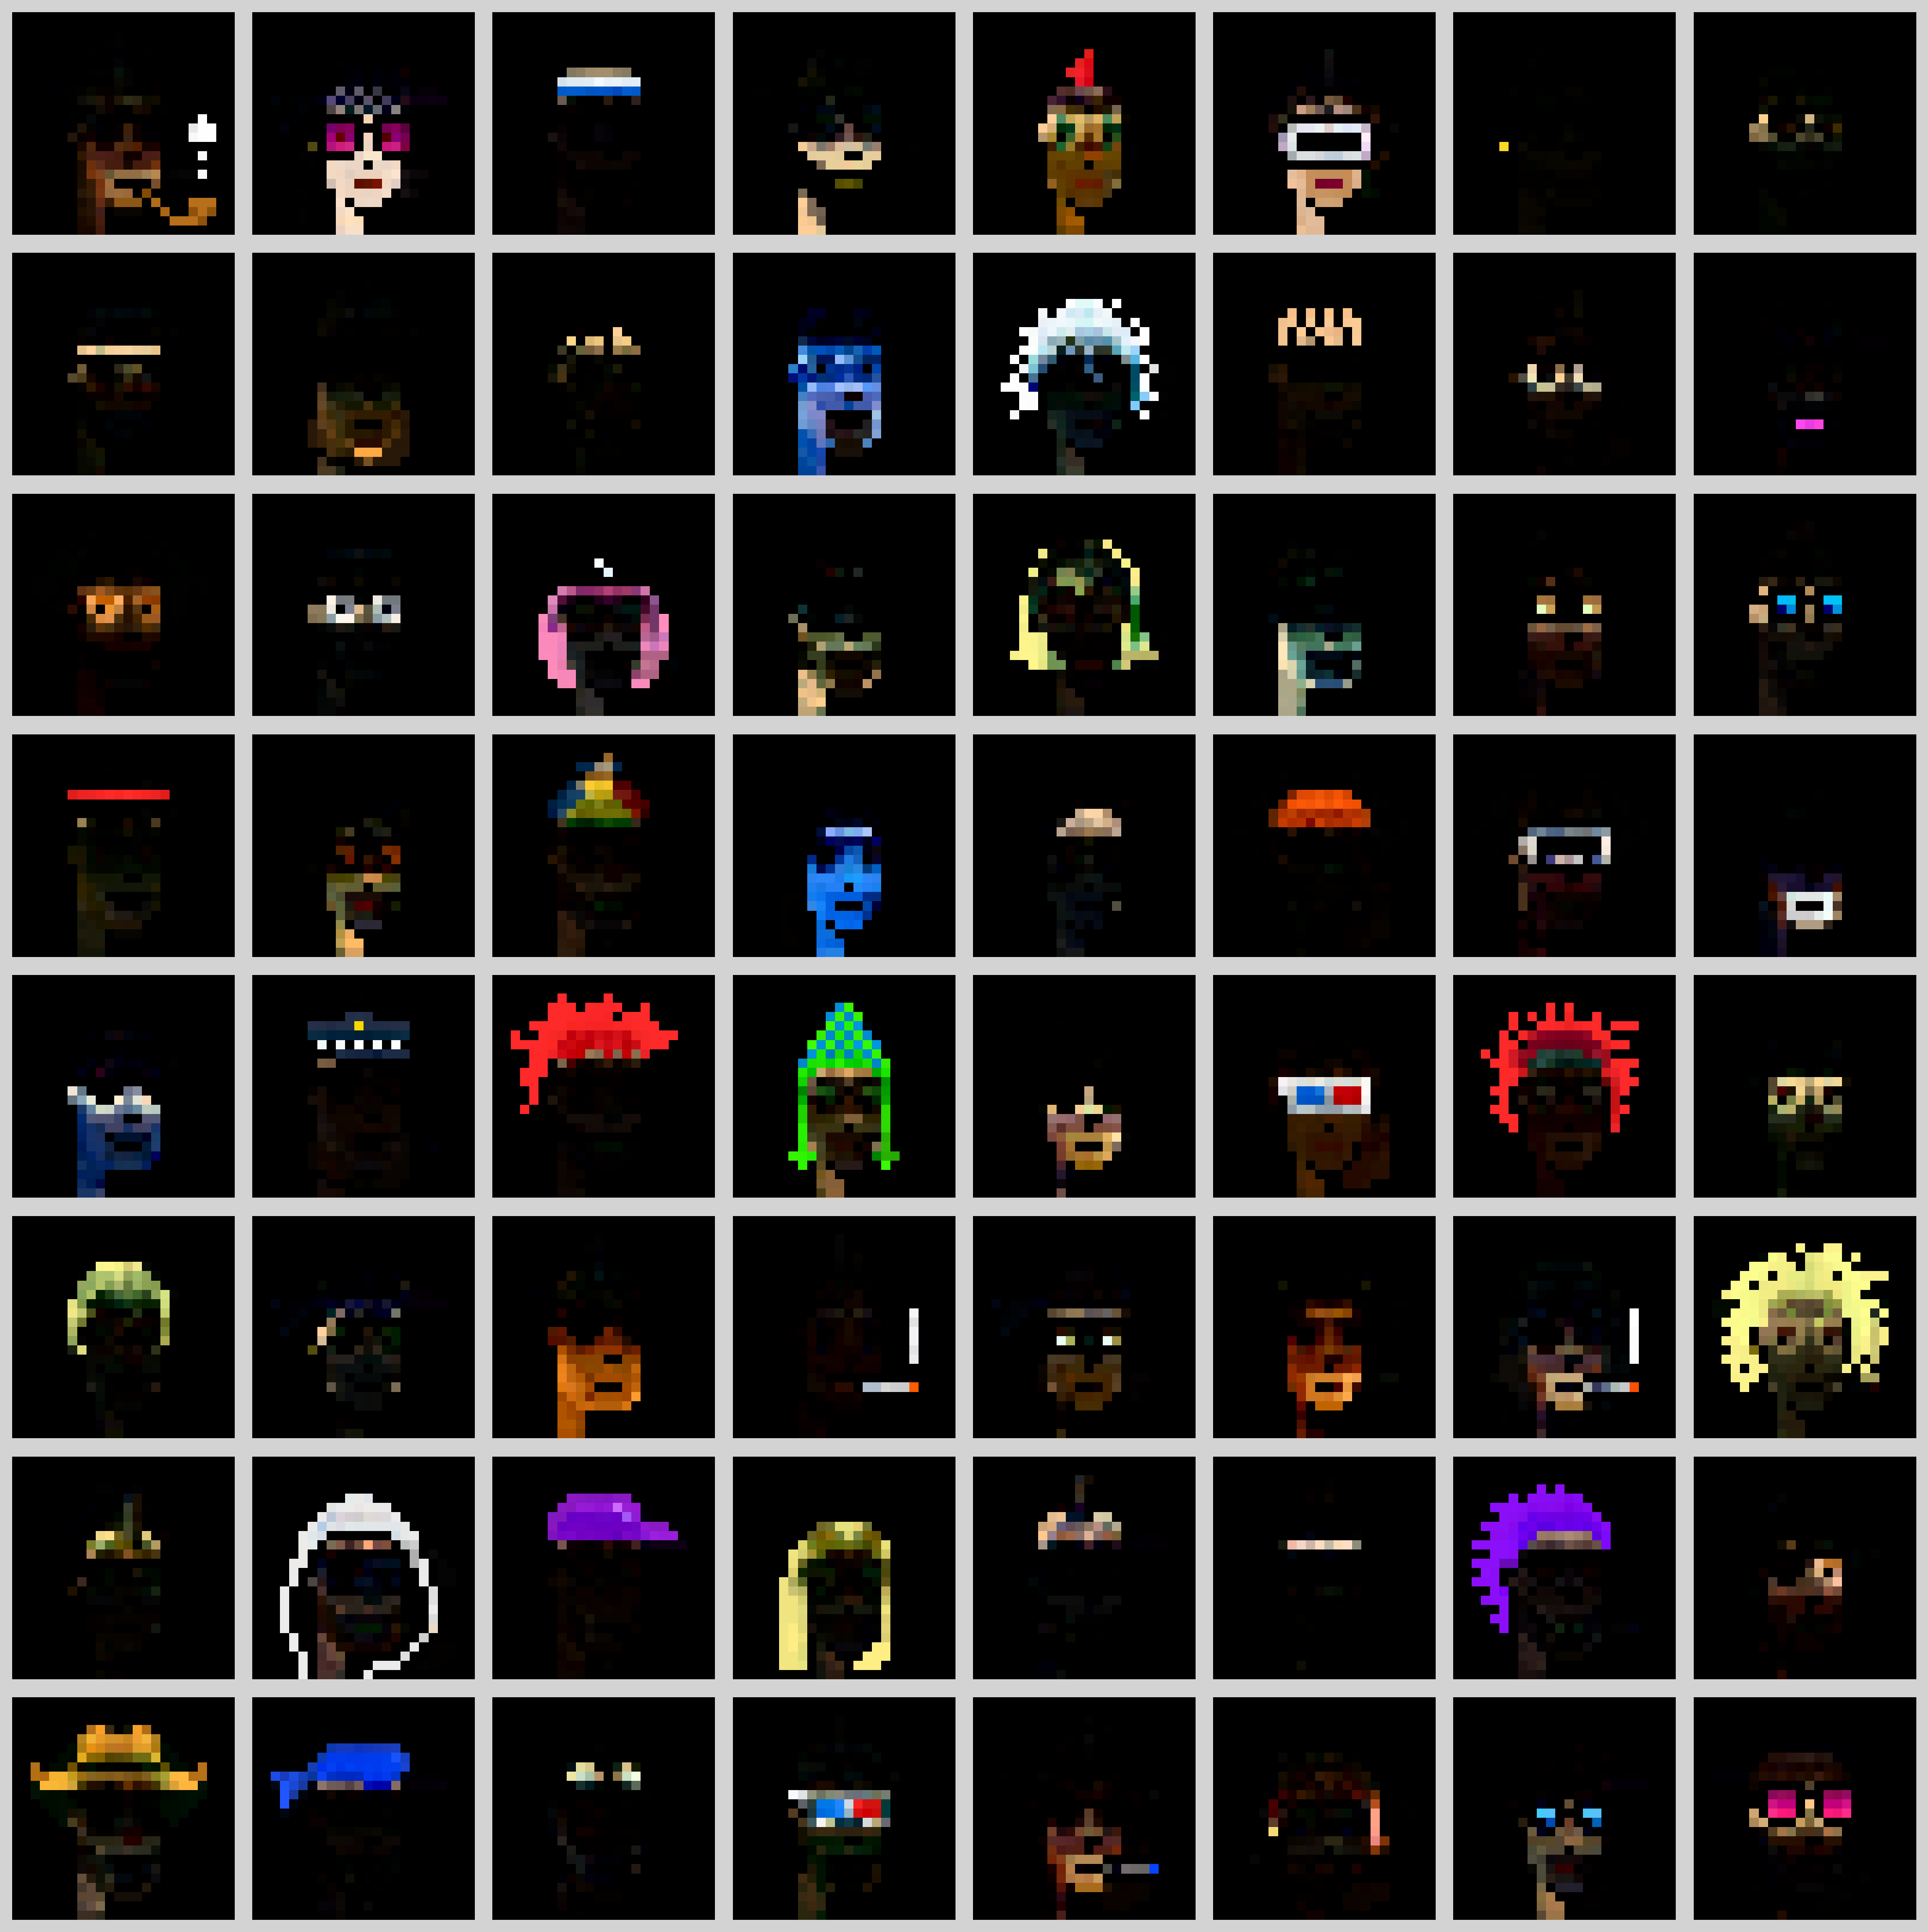

In [256]:
calculate_and_plot_features(64)


From the plot, we can tell that the basis vectors of $W$ are real components of the CryptoPunks. For example, you can see a cigarette, a green hat, a blue cap, different hairstyles, and some of the actual faces with a given skin colour. This is the way the algorithm has reduced the massive amount of data from all the images into specific components and features, which is very interesting!

The colours of the basis vectors are a bit extra vibrant compared to reality. This is due to the rescaling we apply to the images in order to keep the pixel values between 0 and 1. The way we rescale is by dividing by `np.max(scaled_img[:,:,:3])`, which more often than not is a value smaller than 0, which means that the RGB values increase, resulting in brighter colours.



We can try analysing with a higher amount of basis vectors, such as `d = 256`, and see how this influences the features being captured. Note that we still only plot $64$ of the features in an $8$ x $8$ grid of subplots.


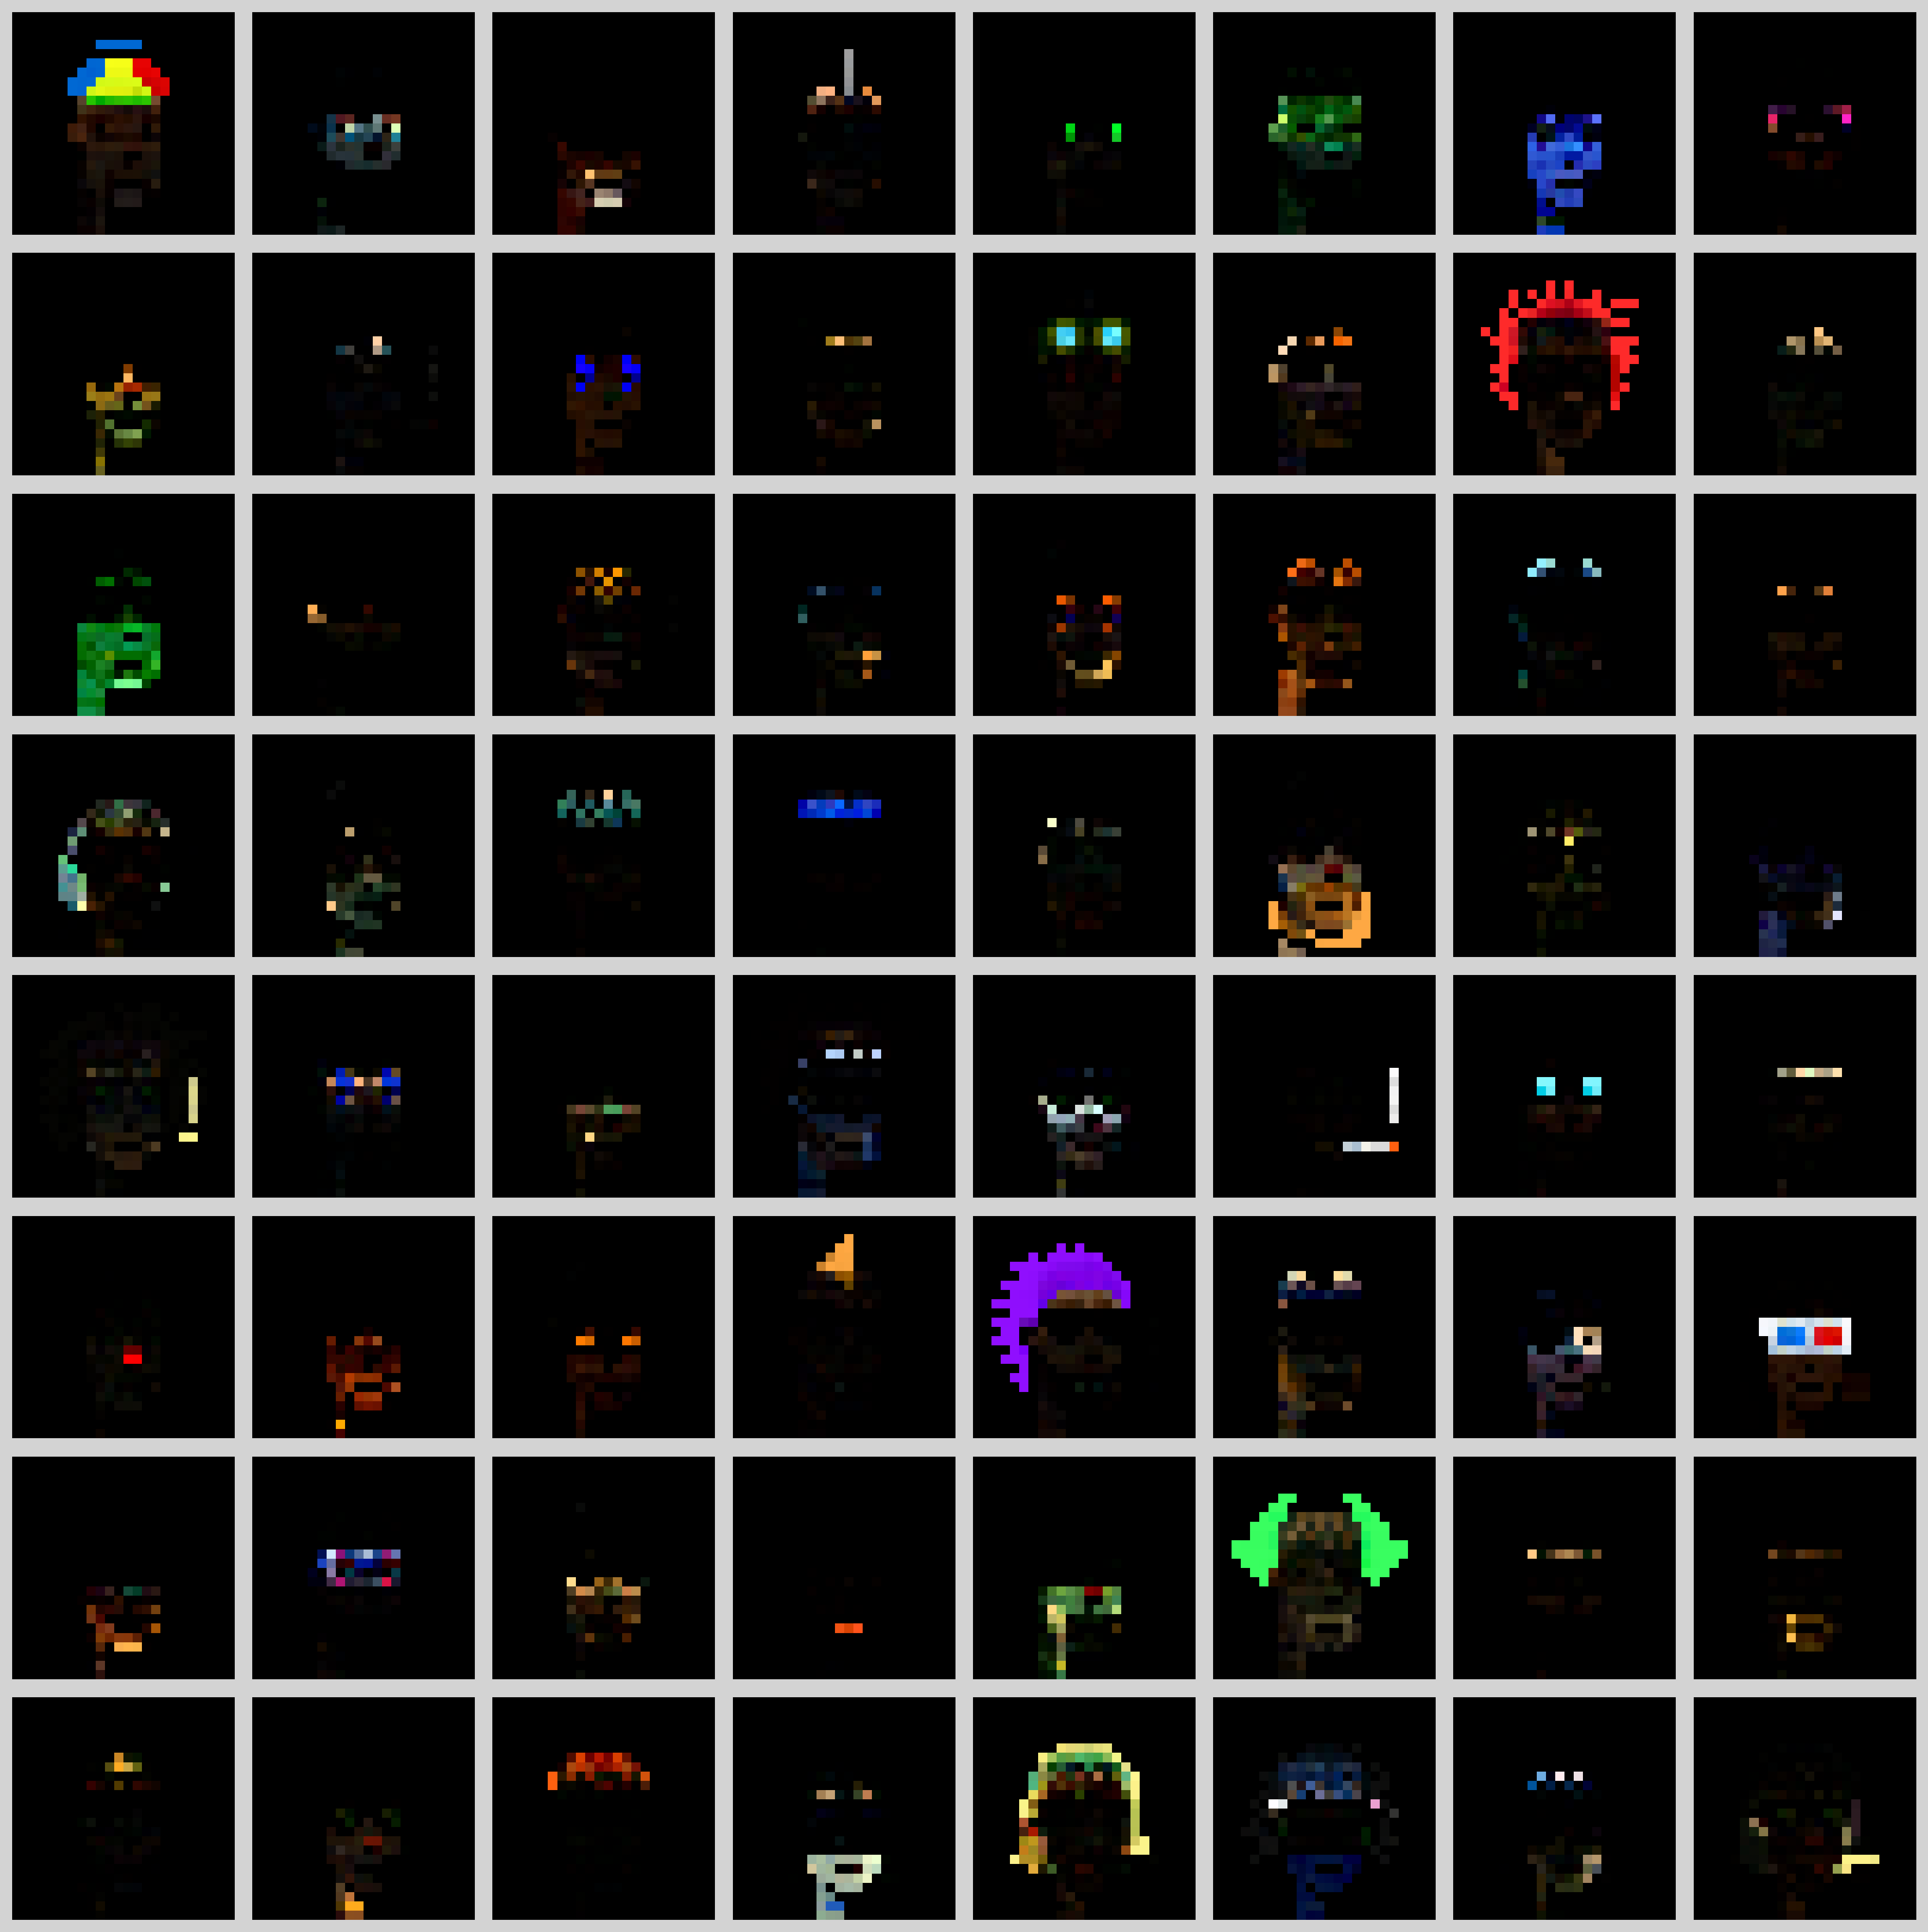

In [257]:
calculate_and_plot_features(256)

We see that using a higher `d`-value, the basis vectors capture smaller elements, such as for example just the beard of a face, instead of the entire face. From this understanding, we can customize our algorithm to be able to capture finer or coarser features based on the value that we choose for `d`.

Its also interesting to examine what happens if we choose to use fever basis vectors. At the risk of overwhelming the reader with too many plots, we show a small plot-dump of `d = [1, 2, 4, 8, 10]`, because they all provide insight into which types of features that are being emphasized. We can - because of the low number of basis vectors - expect to see the most common features being the most predominant, while more specific features not being captured.

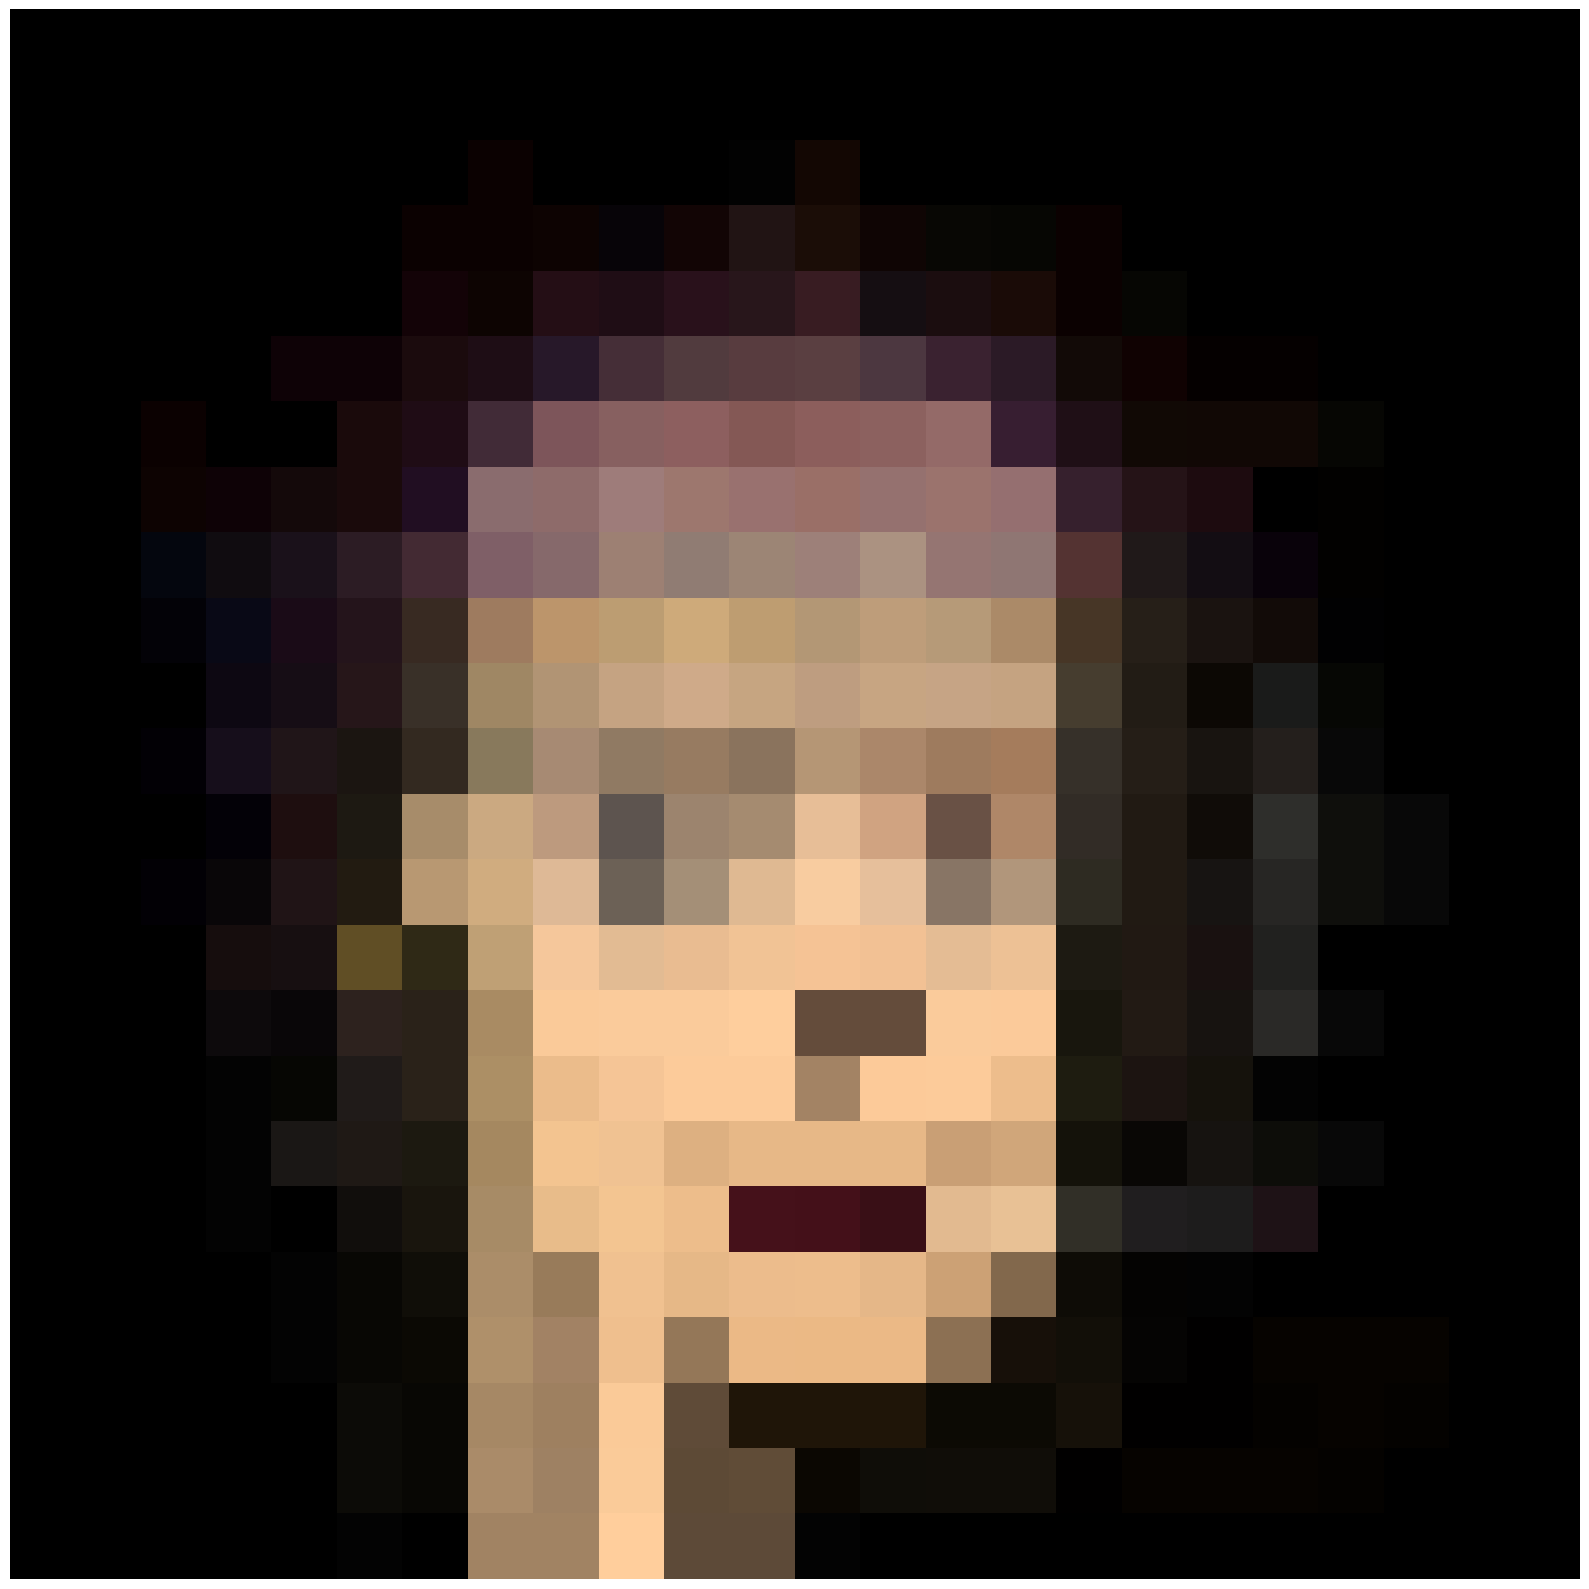

Frobenius distance between Rank 1 approximation and the mean: 4.5668


In [258]:
calculate_and_plot_features(1)

We see that with $d=1$, it makes a blurry face, reasonable enough considering that some sort of face surely would be the best way to capture the essence of all the pictures, the images are  faces after all! 

Interestingly, this face is very similar to the mean face we saw previously, but still not exact copies of one another. The NMF does not calculate the mean value like the previous algorithm did, so there are bound to be some differences. We can calculate the Frobenius distance between the two images to be $4.57$. Using a formula we will discuss later, this norm corresponds to an average colour channel deviation of $0.19$ per pixel, which is fairly low. 


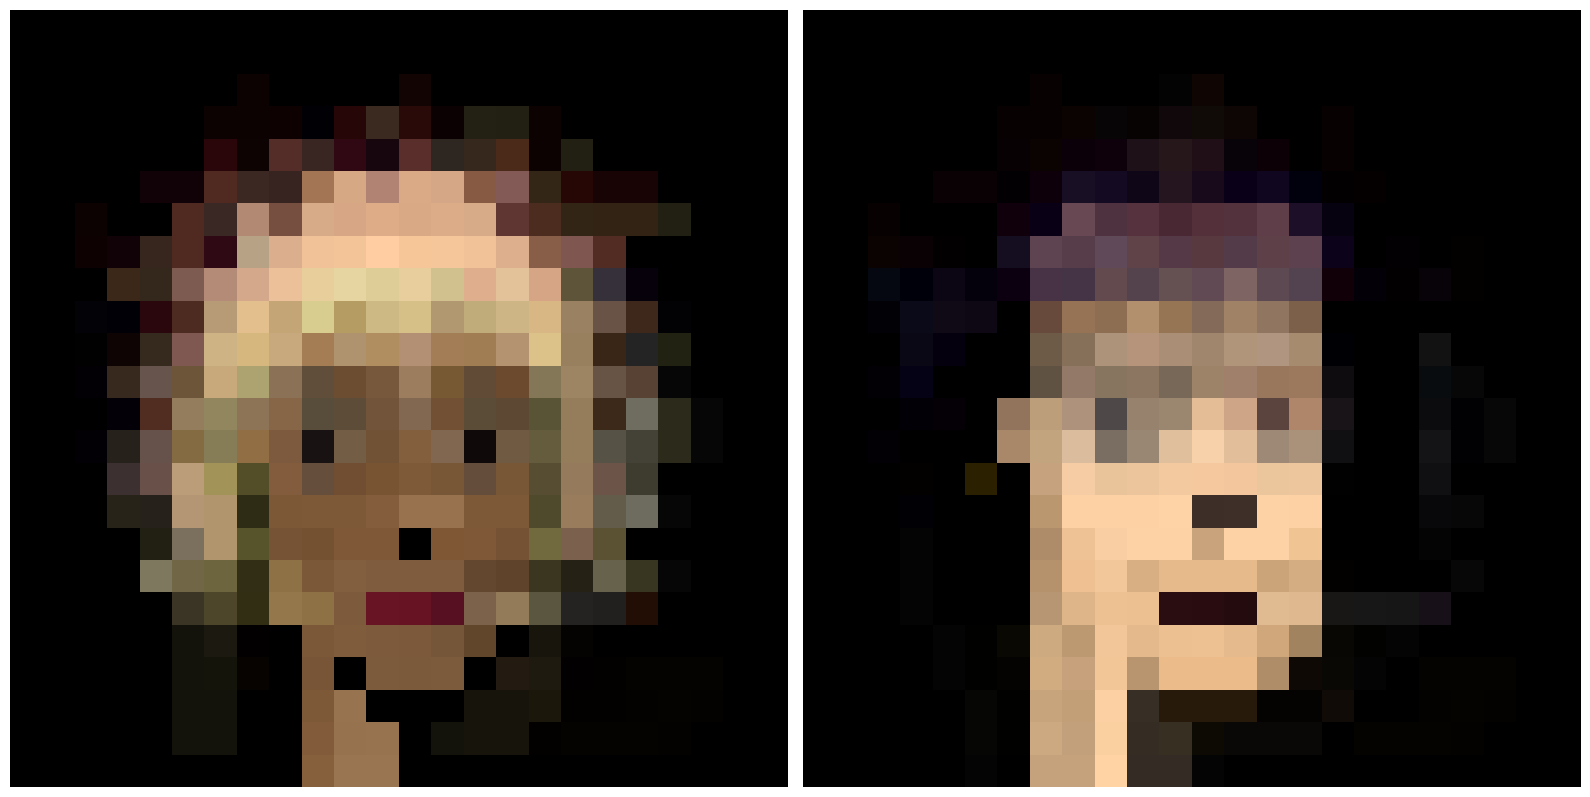

In [275]:
calculate_and_plot_features(2)


For $d=2$, we see two faces, where the first one has lots of hair, red lips, and a smaller nose. The second person one has short hair,the remains of a beard, and the contour of a cigarette
. One might be as bold as to claim that these basis vectors represent a male and female! Of course, the algorithm does not know what genders are, but it appears that since the data it was fed has some male and some female figures, the best way to reduce the norm with two basis vectors is to have one face with more masculine features, and one with more feminine features.


Basis vectors: 4


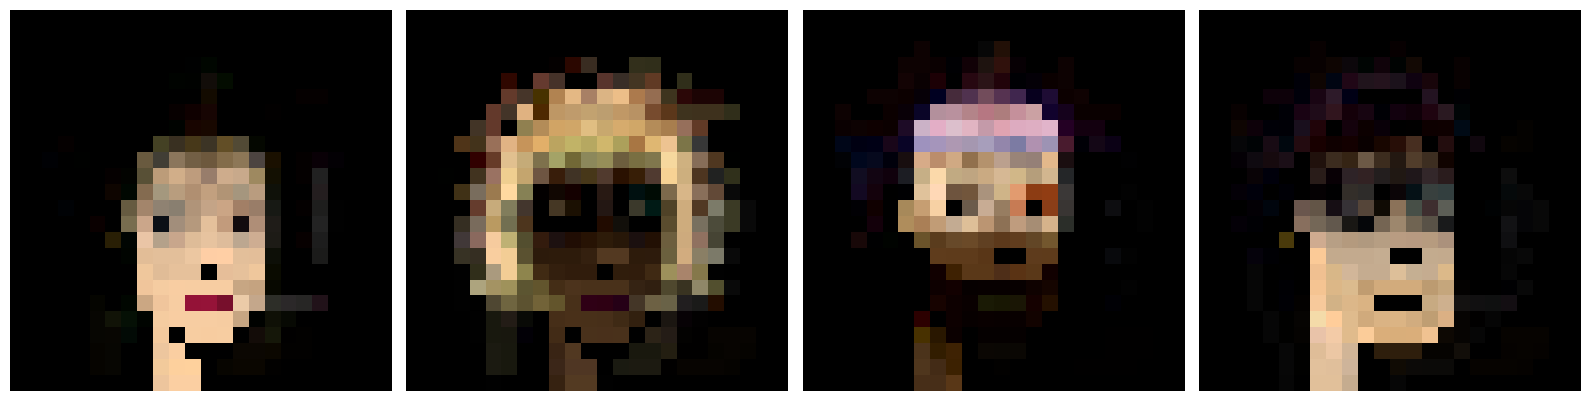

Basis vectors: 8


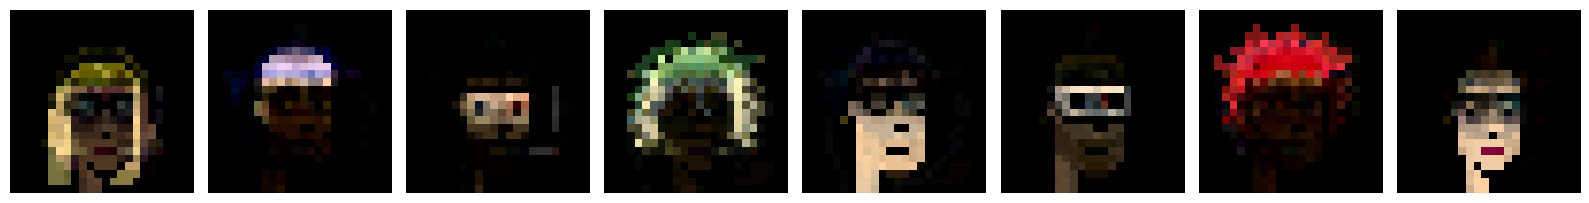

Basis vectors: 10


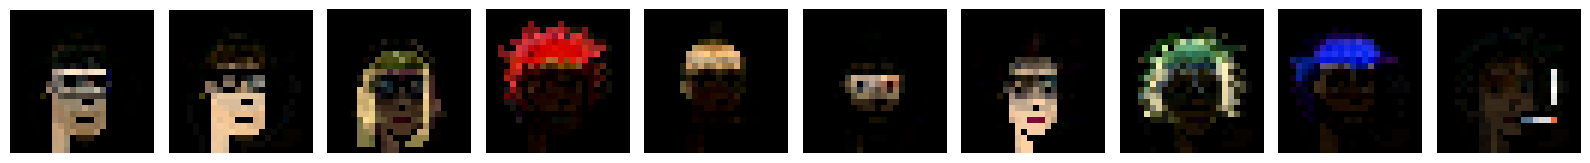

In [260]:

def plot_for_multiple_d():
    d_vals = [4,8,10]
    for d in d_vals:
        print(f"Basis vectors: {d}")
        calculate_and_plot_features(d)   
plot_for_multiple_d()


For `d = [4, 8, 10]`, all the basis vectors still include a full face with different skin colours, but they now have different hairstyles and some accessories such as a cigarette. We see that first at `d = 10` does the algorithm chose to spend entire basis vectors on accessories, such as the glasses. In fact, it's pretty interesting that already with `d = 10` basis vectors, we see multiple somewhat similar objects, multiple images appear to include a pairs of glasses. We can also see that as we increase `d`, we get more vibrant colours.



## 2.4 Facial reconstructions

Now that we have calculated $W$ and $H$ with the NMF-algorithm, the original matrix can easily be reconstructed. As we are storing a less data after the NMF that what we did for the original faces, we can expect that the reconstructed faces will not be excact copies of the originals. 




In [261]:
def get_faces_with_opacity(reconstructed_faces, faces, faces_rgb, faces_opacity):
    '''
    Calculating the reconstructed faces with the correct opacity

    Input:
        reconstructed_faces: array, the WH-matrix
        faces: array, the faces-matrix A
        faces_rgb: array, the RGB-channels of faces
        faces_opacity: array, the opacity-channel of faces
    
    Output: 
        faces_with_opacity: array, the reconstructed faces with the correct opacity
    '''
    faces_with_opacity = np.zeros(faces.shape)
    faces_with_opacity[:, :, :3, :] = reconstructed_faces.reshape(faces_rgb.shape)
    faces_with_opacity[:, :, 3, :] = faces_opacity
    return faces_with_opacity

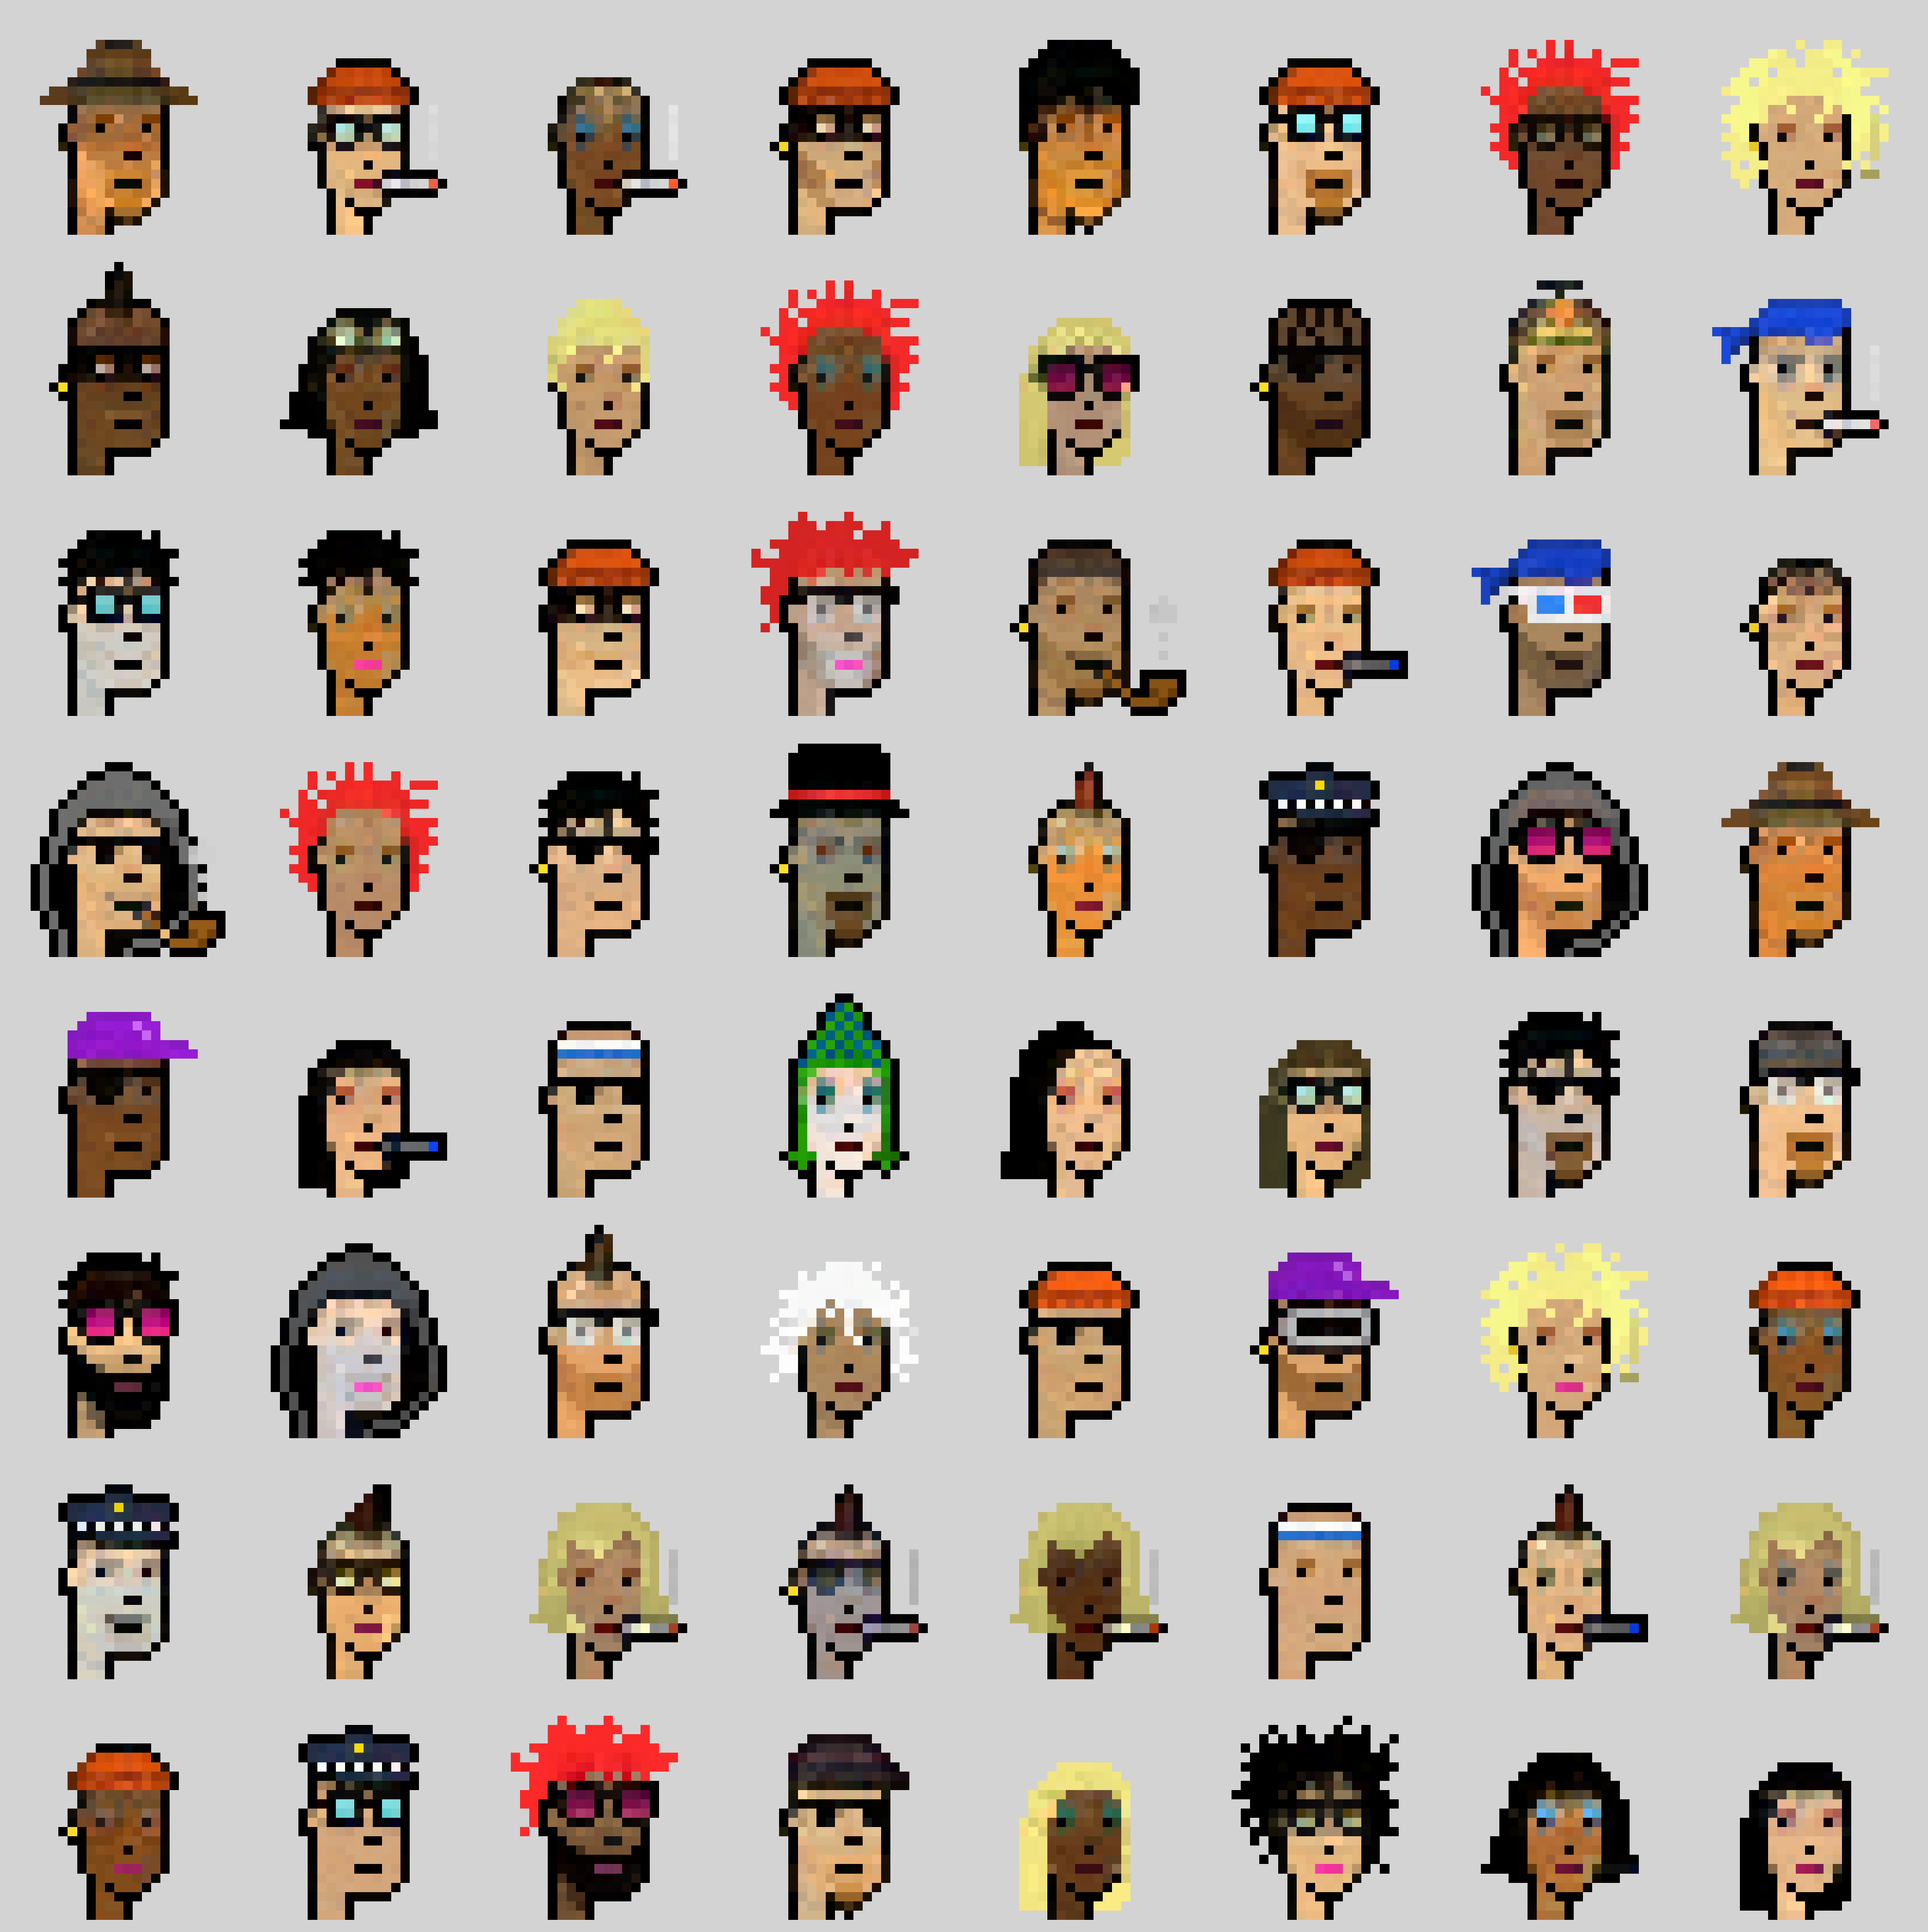

In [262]:
def plot_reconstructions():
    '''
    Calculating and plotting the reconstructions WH of the faces-matrix

    '''
    
    # Importing the faces-data
    faces_data = np.load('faces.npz')
    faces = faces_data['faces_500']
    
    d_val = 64 # the number of columns in the W-matrix
    N = 500 # the number of faces imported

    # Splittiing the faces into different channels and reshaping
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)

    # Calculating the NMF
    W, H = NMF(faces_reshaped, d_val)
    
    # Calculating the reconstructed faces with the correct opacity
    faces_with_opacity = get_faces_with_opacity(np.dot(W, H), faces, faces_rgb, faces_opacity)

    #Save first face for later use
    first_face = faces_with_opacity[:,:,:,0]
    first_face_reshaped_2 = np.reshape(first_face, (24, 24, 4, 1))   
    np.savez(
        "comparison_face_2",
        first_face_reshaped_2 = first_face_reshaped_2
    )
    # Plotting the reconstructions
    plotimgs(faces_with_opacity, nplot = 8, rescale = True, filename = None)
    
plot_reconstructions()

Overall, the reconstructions are pretty good. All the faces are similar enough for us to understand which CryptoPunk they represent.  In particular, distinct objects and features like for example hairstyles, caps and cigarettes are reconstructed very nicely. 

With that said, we observe that some more general features are a lot less cleanly reconstructed than the more specific ones. For example, whereas the skin tone is the originals mostly were just a single specific colour, the skin in the recreations is a lot less clean. The overall tone of the skin is often correct, but it commonly consists of multiple different shades of the colour. This is because the basis vectors are more likely to capture objects that occur multiple times. There are multiple CryptoPunks have the same cap, but they often have slightly different skin colour. Therefore, some information about the different skin colours is lost in the process. 

Particularly, notice that the reconstruction of the zombies are very off. This is due to the fact that the zombie CryptoPunks are very rare, so there are less zombies in the training dataset. The actual zombie skin colour is a distinct light green colour, but it's not given a large emphasis since there appears to be no other CryptoPunk types that have this colour. Therefore, the reconstructed skin colour is fairly close to the non-zombies. The red eyes of the zombie are also distinct, and as such there has not been spent an entire basis vector on them. This leads to the reconstructed zombies not having the red eyes.



## 2.5 Checking convergence in the deconstruction
The imperfect reconstructions may be a consequence of our algorithm not having converged. We can examine the difference from the reconstructed matrices and the original by calculating their distance apart with the Frobenius norm, but what does this actually describe?

<strong>The Frobeus norm</strong><br>
By the definition, we can think of this norm as a measure of the the sum of all element-wise differences between two matrices. In our case, it is the sum over each channel-wise difference for each pixel in every image of our data set. This is a mouthful, but taking a second to think about it grants an intuitive understanding of this measure. For instance, if we have the matrices $A, B$ describing data sets each containing `500` images with a `24x24`-pixel resolution and three channels on each pixel. Then a darkening by `0.1` on one pixel in every image will result in a deviation of $\Vert A-B\Vert_F = 0.1 \cdot 3 \cdot 500 = 150$.

One way to check this potential issue is by calculating the error as a function of the number of iterations, using the Frobenius norm to quantify the error. 

The following two functions will be used to calculate the Frobenius norm, and plotting this as a function of `d`.


In [263]:
def calculate_norms(faces_reshaped, original_faces_reshaped, d_vals):
    '''
    Calculate the norms related to the NMF-function. The function will both calculate the norms for every iteration of the NMF-function and the final norm after the NMF has run.

    Input:
        faces_reshaped: array, the matrix containg the data for the reconstructed faces.
        original_faces_reshaped: array, the original reshaped faces. This is for when we later want to calculate the norms of the noisy faces.
        d_val: int, the number of columns in the W-matrix.
        
    Output:
        iteration_norms_arr: array, the calculated iterations norms
        final_norms_arr: array, the calculated final norms
    '''
    
    N = 500 # The number of faces

    # Lists that will be filled with the calculated norms 
    iteration_norms_arr = []
    final_norms_arr = []
    
    # Loop that will calculate the norms
    for i in range(len(d_vals)):

        # Calculating the NMF and storing the norms for every iteration
        W, H, n = NMF(faces_reshaped, d_vals[i], delta = 1e-9, maxiter = 1000, seed = 0, store_norms = True)
        
        # Adding the iteration norms to the list
        iteration_norms_arr.append(n)

        # Calculating the final norm, and adding it to the list
        final_norms_arr.append(np.linalg.norm(original_faces_reshaped - np.dot(W, H), 'fro'))

    # Returning the lists containing the norms
    return iteration_norms_arr, final_norms_arr

In [264]:
def plot_norms(norms_arr, iteration_norms, d_vals_arr, labels_arr, title, x_label, y_label, plot_for_iterations = False):
    '''
    Plotting the two different arrays of calculated norms.

    Input:
        norms_arr: array, array containing the norms calculated after the NMF had run
        teration_norms: array, array containing the norms calculated during the NMF-algoritm
        d_vals_arr: array, array containing the number of columns in the W-matrises
        labels_arr: array, array containing the labels for the norms that will be plottet
        title: string, the title of the plot
        x_label: string, the label of the plots x-axis
        y_label: string, the label of the plots y-axis
        plot_for_iterations: bool, if the iteration norms or the final norms are going to be plotted
    '''
    
    # Checking wether the iteration norms are going to be plotted
    if plot_for_iterations == True:
        x = np.arange(0, len(iteration_norms[0]), 1) # Array with the steps from the first to the last iteration. This will be our x-axis
        # Looping through every iteration norms and plotting 
        for i in range(len(iteration_norms)):
            plt.plot(x, iteration_norms[i], label = labels_arr[i])
    else:
        # Plotting the final norms
        for i in range(len(norms_arr)):
            plt.plot(d_vals_arr[i], norms_arr[i], label = labels_arr[i])

    plt.title(title) # Adding title
    plt.xlabel(x_label) # Adding x-axis
    plt.ylabel(y_label) # Adding y-axis
    plt.legend() # Adding legend
    plt.show() # Showing the plot



We now use the functions to calculate and plot the norm for the values `d = 16, 32, 64`.


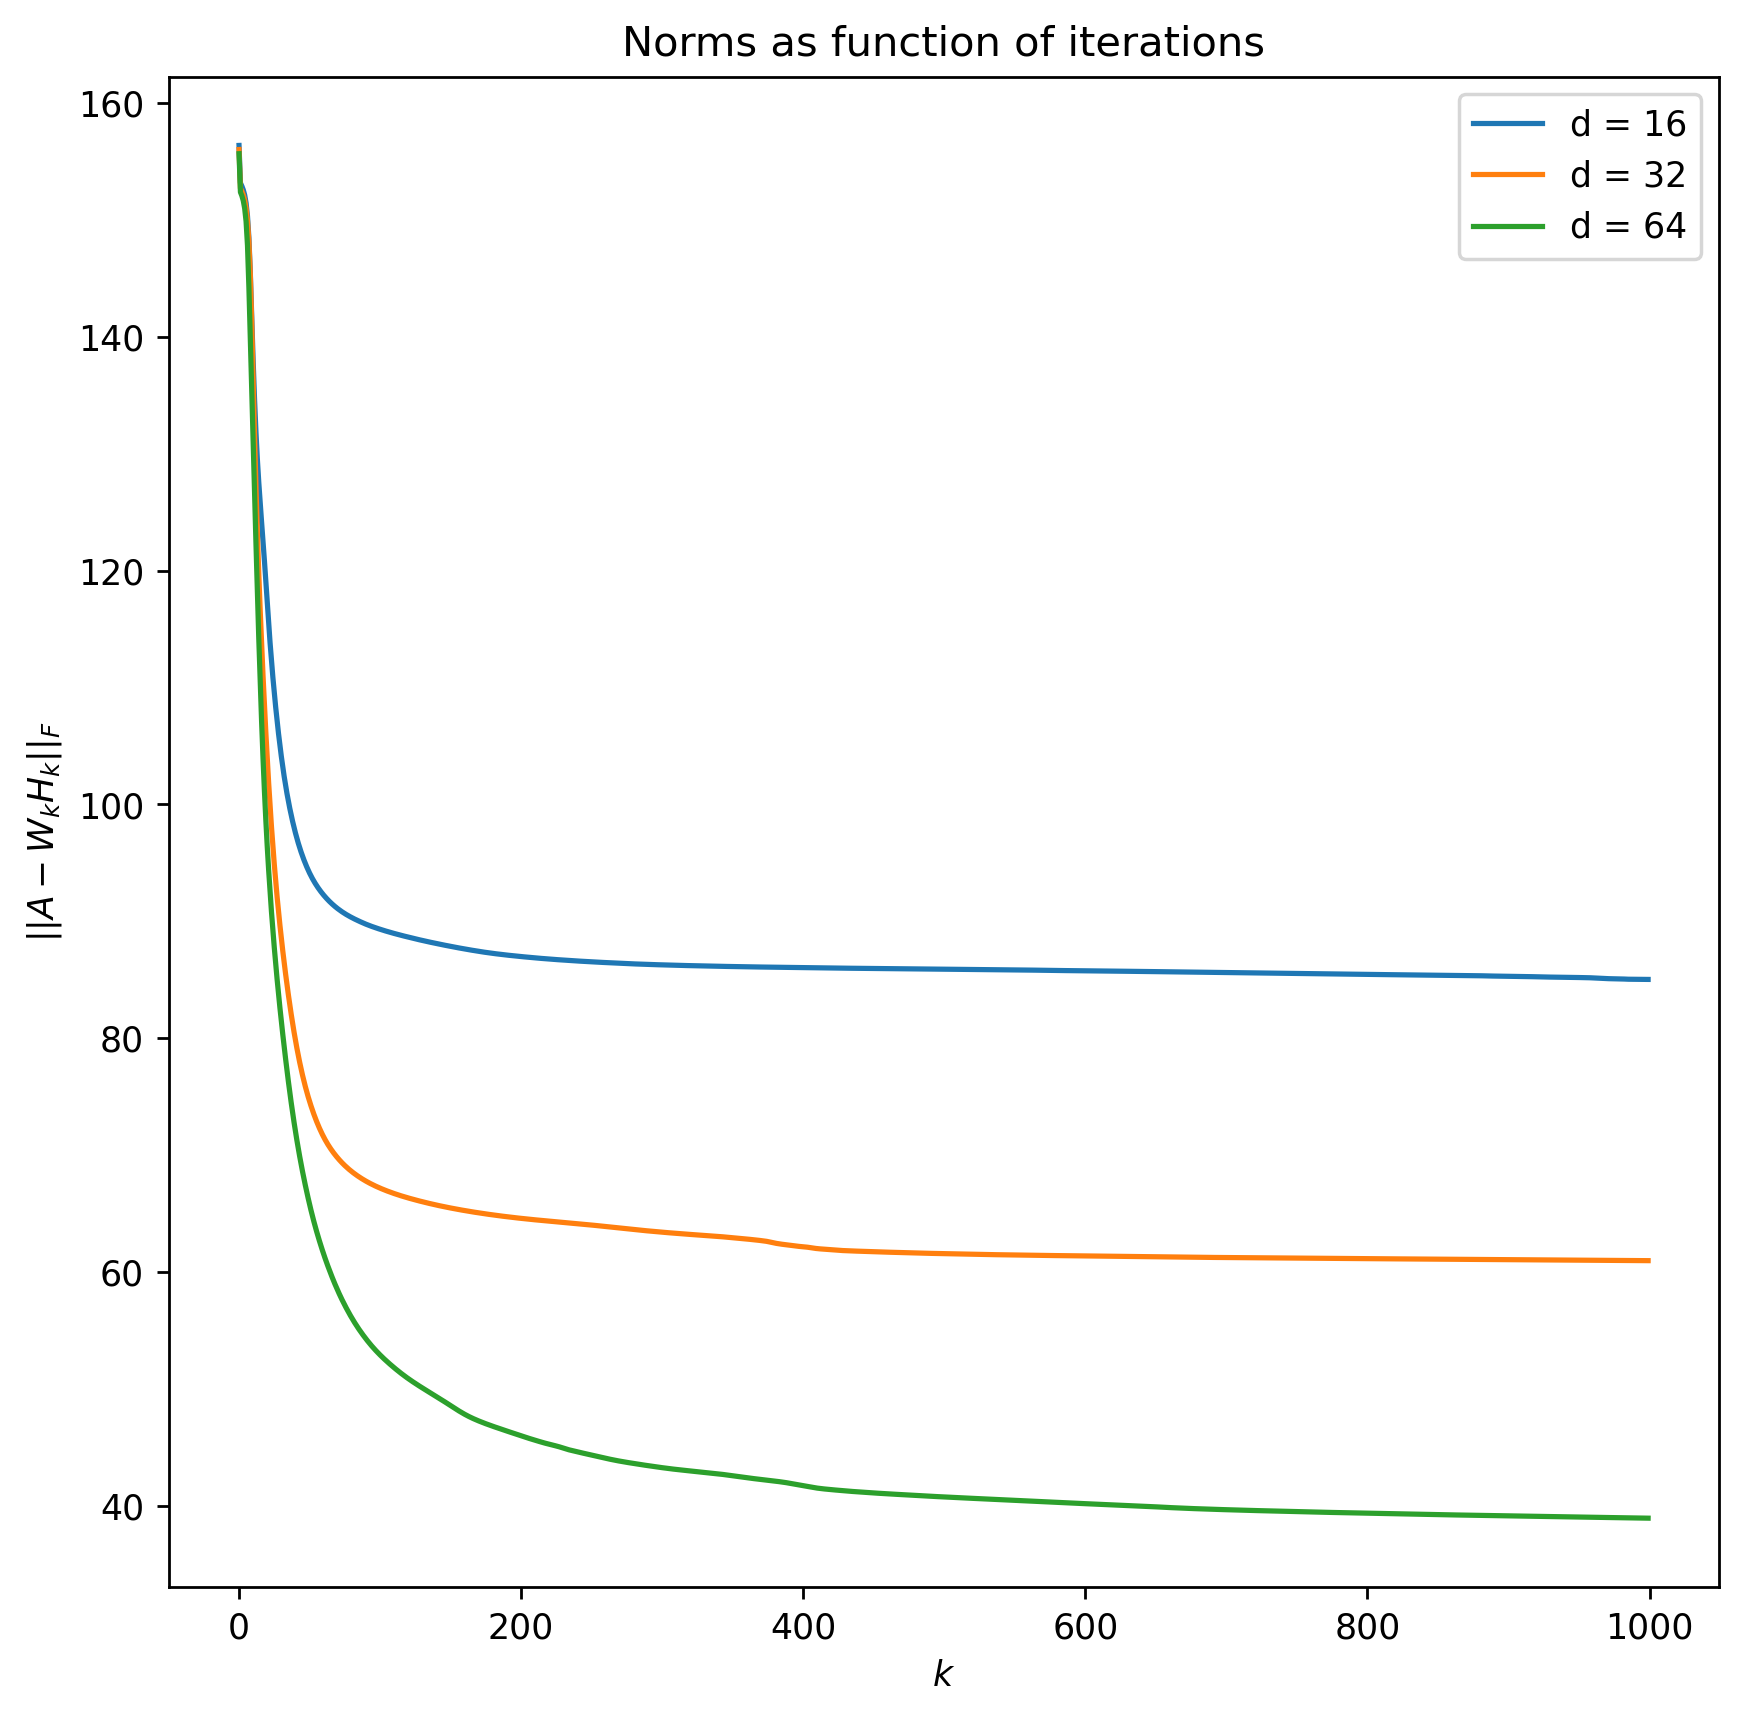

In [265]:
def iteration_norms():
    '''
    Calculating and plotting the norms for every iteration of the NMF-function
    '''

    # Importing the faces-data
    faces_data = np.load('faces.npz')
    faces = faces_data['faces_500']

    N = 500 # the number of faces imported

    # Splitting the faces into different channels and reshaping
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)

    d_vals = [16, 32, 64] # The different numbers of columns in the W-matrix

    # Calculating the iteration-norms
    iteration_norms = calculate_norms(faces_reshaped, faces_reshaped, d_vals)[0]

    # Plotting the norms
    plot_norms([], iteration_norms, [d_vals], ['d = 16', 'd = 32', 'd = 64'], "Norms as function of iterations", r'$k$', r'$\vert\vert{A-W_{k} H_{k}}\vert\vert_{F}$', plot_for_iterations = True)

iteration_norms()  


We see that for all three values of `d`, the norm is decreasing very slowly after the initial first few hundred iterations. To see how significant this slow convergence towards the end may be, we decided to let the algorithm run for `10.000` iterations, and calculate the difference in the norm for `d = 3`. The result was about `1.99` , while the runtime went from $30$ seconds to $16$ minutes (this code from this test is not present in the project). So while the algorithm has not converged, it's probably not worth spending a lot of computing power on increasing the amount of iterations since `1.99` is quite low compared to the order of magnitude along the $y$-axis.  

We can also see that the norm is lower for higher values of `d` in all cases, which is what we expect. Notice that as we double `d`, the norm also doubles.


## 2.6 The effect of varying amounts of basises
Notice how in the last plot the deviation between $A$ and $A_{NMF}$ is reduced as we increase `d`. We can show this more clearly by running the NMF with `d = [8, 16, 32, 64, 128, 256, 512]` and plotting their error after `1000` iterations as a function of `d`.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


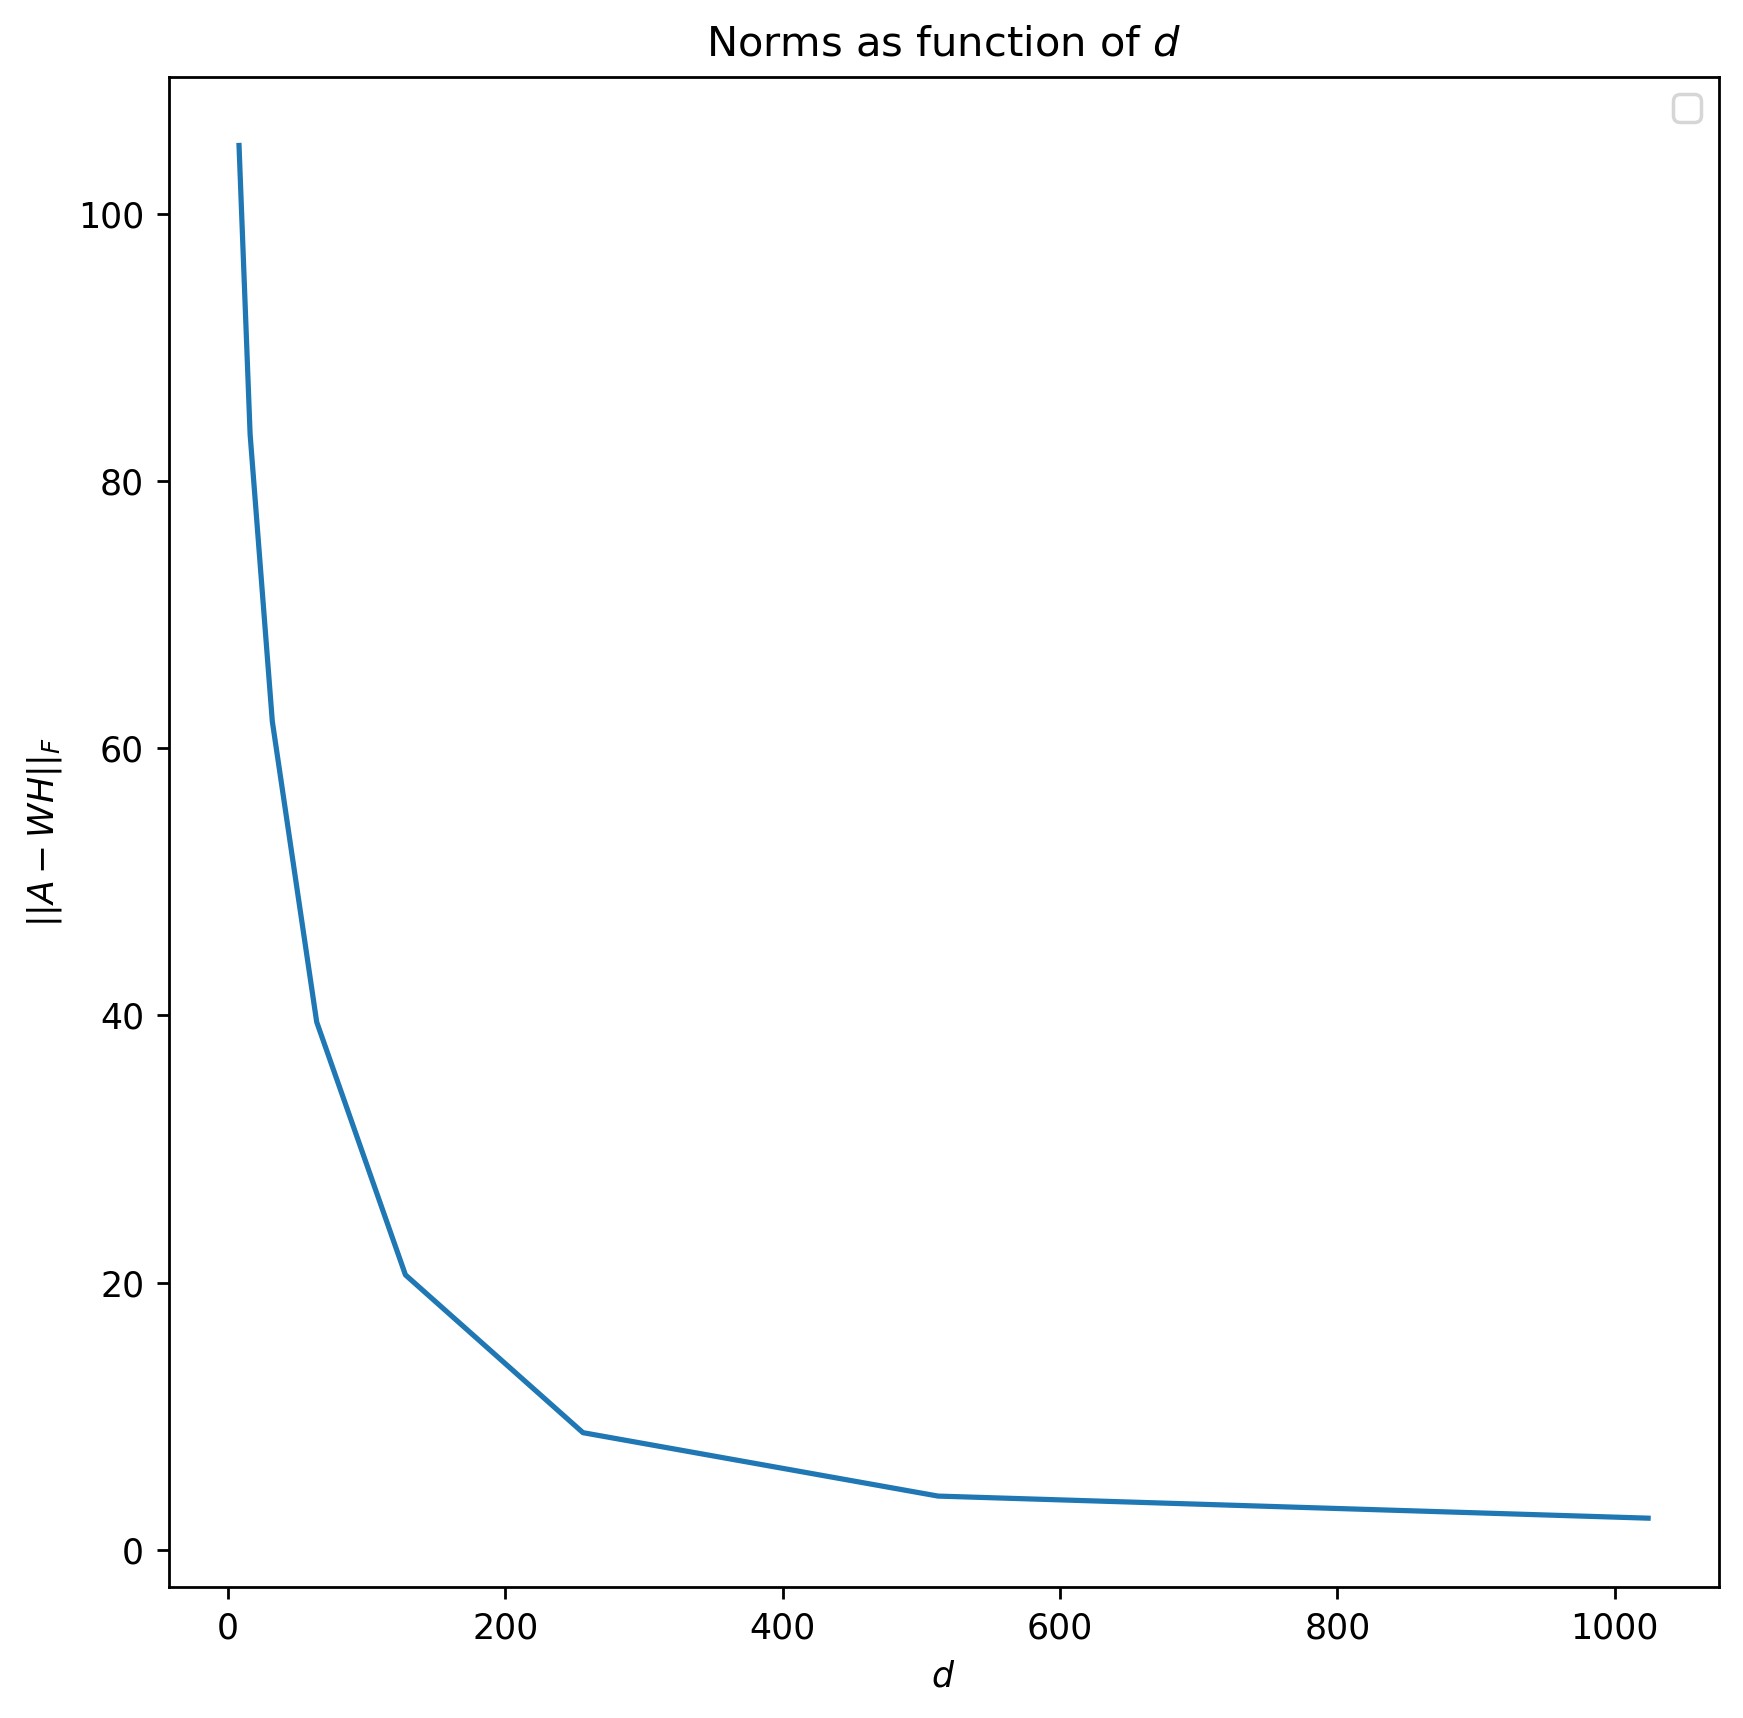

In [276]:
def final_norms():
    '''
    Calculating and plotting the final norms for every iteration of the NMF-function
    '''
    # Importing the faces-data
    faces_data = np.load('faces.npz')
    faces = faces_data['faces_500']

    N = 500 # The number of faces imported

    # Splitting the faces into different channels and reshaping 
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)

    d_vals = [8,16,32, 64, 128, 256,512,1024] # The different numbers of columns in the W-matrix

    # Calculating the norms
    norms = calculate_norms(faces_reshaped, faces_reshaped, d_vals)[1]

    # Plotting the norms
    plot_norms([norms], [], [d_vals], [''], r'Norms as function of $d$', r'$d$', r'$\vert\vert{A-WH}\vert\vert_{F}$')

final_norms()


We clearly see that the norm is reduced for larger values of `d`, which is the expected result since what the norm is comparing is the original matrix $A$, and the reconstruction with an increasing amount of basises, meaning an increased number of components to create the smallest possible norm. We see that when we have few basis vectors, doubling the amount will drastically reduce the norm. This is because the new basis vectors get to represent important features in the dataset. As we add more and more basis vectors, the effect of doubling `d` is not as impactful since the new basis vectors represent less important features, such as for example the red eyes of the zombie previously discussed.

One thing to note about the Frobenius norm is that it's not a perfect way to quantify the difference between two images. Two colours that to the human eye seem fairly similar, may have very different pixel values, and as such result in an unnaturally large norm. The opposite can also happen, with different colours having small norms. With that said, RGB is constructed in a way that most of the time, similar colours have fairly similar values.

<br>

To show this point about using the Frobenius norm on colour, we will present a small demonstration. Let $RBG$ be the space of rgb colours, and $C = (r, g, b) \in RGB$ be a colour, where $r, g, b \in [0, 1] \subseteq \Re$ are real valued scalars denoting the amount of red, green and blue respectively. Now let $C_0 = (r_0, g_0, b_0) \in RGB$ be a fixed colour, the Frobenuis distance between $C$ and $C_0$ is then defined as:
$$
    \Vert C_0 - C \Vert_F = \sqrt{|r-r_0|^2 + |g-g_0|^2 + |b-b_0|^2}
$$
This is what defines the distance between two pixel colours, and more importantly, our measuring tool for describing the difference between images. Our demonstration is to show that this choice of measure is imperfect. 

Given a colour $C_0 = (r_0, g_0, b_0) \in RGB$, we would like to visualize a range of other colours $C = (r, g, b) \in RBG$ that are equally distanced $D \in [0, 1]$ from $C_0$. For simplicity we fix $g_0 = g$. This leaves us with the equation:
$$
    \Vert C_0 - C \Vert_F = \sqrt{|r-r_0|^2 + |b-b_0|^2} = D
$$
simplified:
$$
    |b_0-b| = \sqrt{ d^2 - |r_ 0 - r|^2 }
$$

In the following example we choose `C_0 = (0.3, 0.8, 0)` and `D = 0.6`. Then using a range of evenly spaced red values, we use the equation to calculate the corresponding blue values such that the distance is constant and equal to `D`. This range is plotted as coloured points following a circle with `C_0` at the centre. 
We will also display two another, similar sets of coloured points, only this time using the Frobenuis distance `D = 0.2` and `D = 0.07`. These points will also be plotted along a circle, however with a smaller radii.


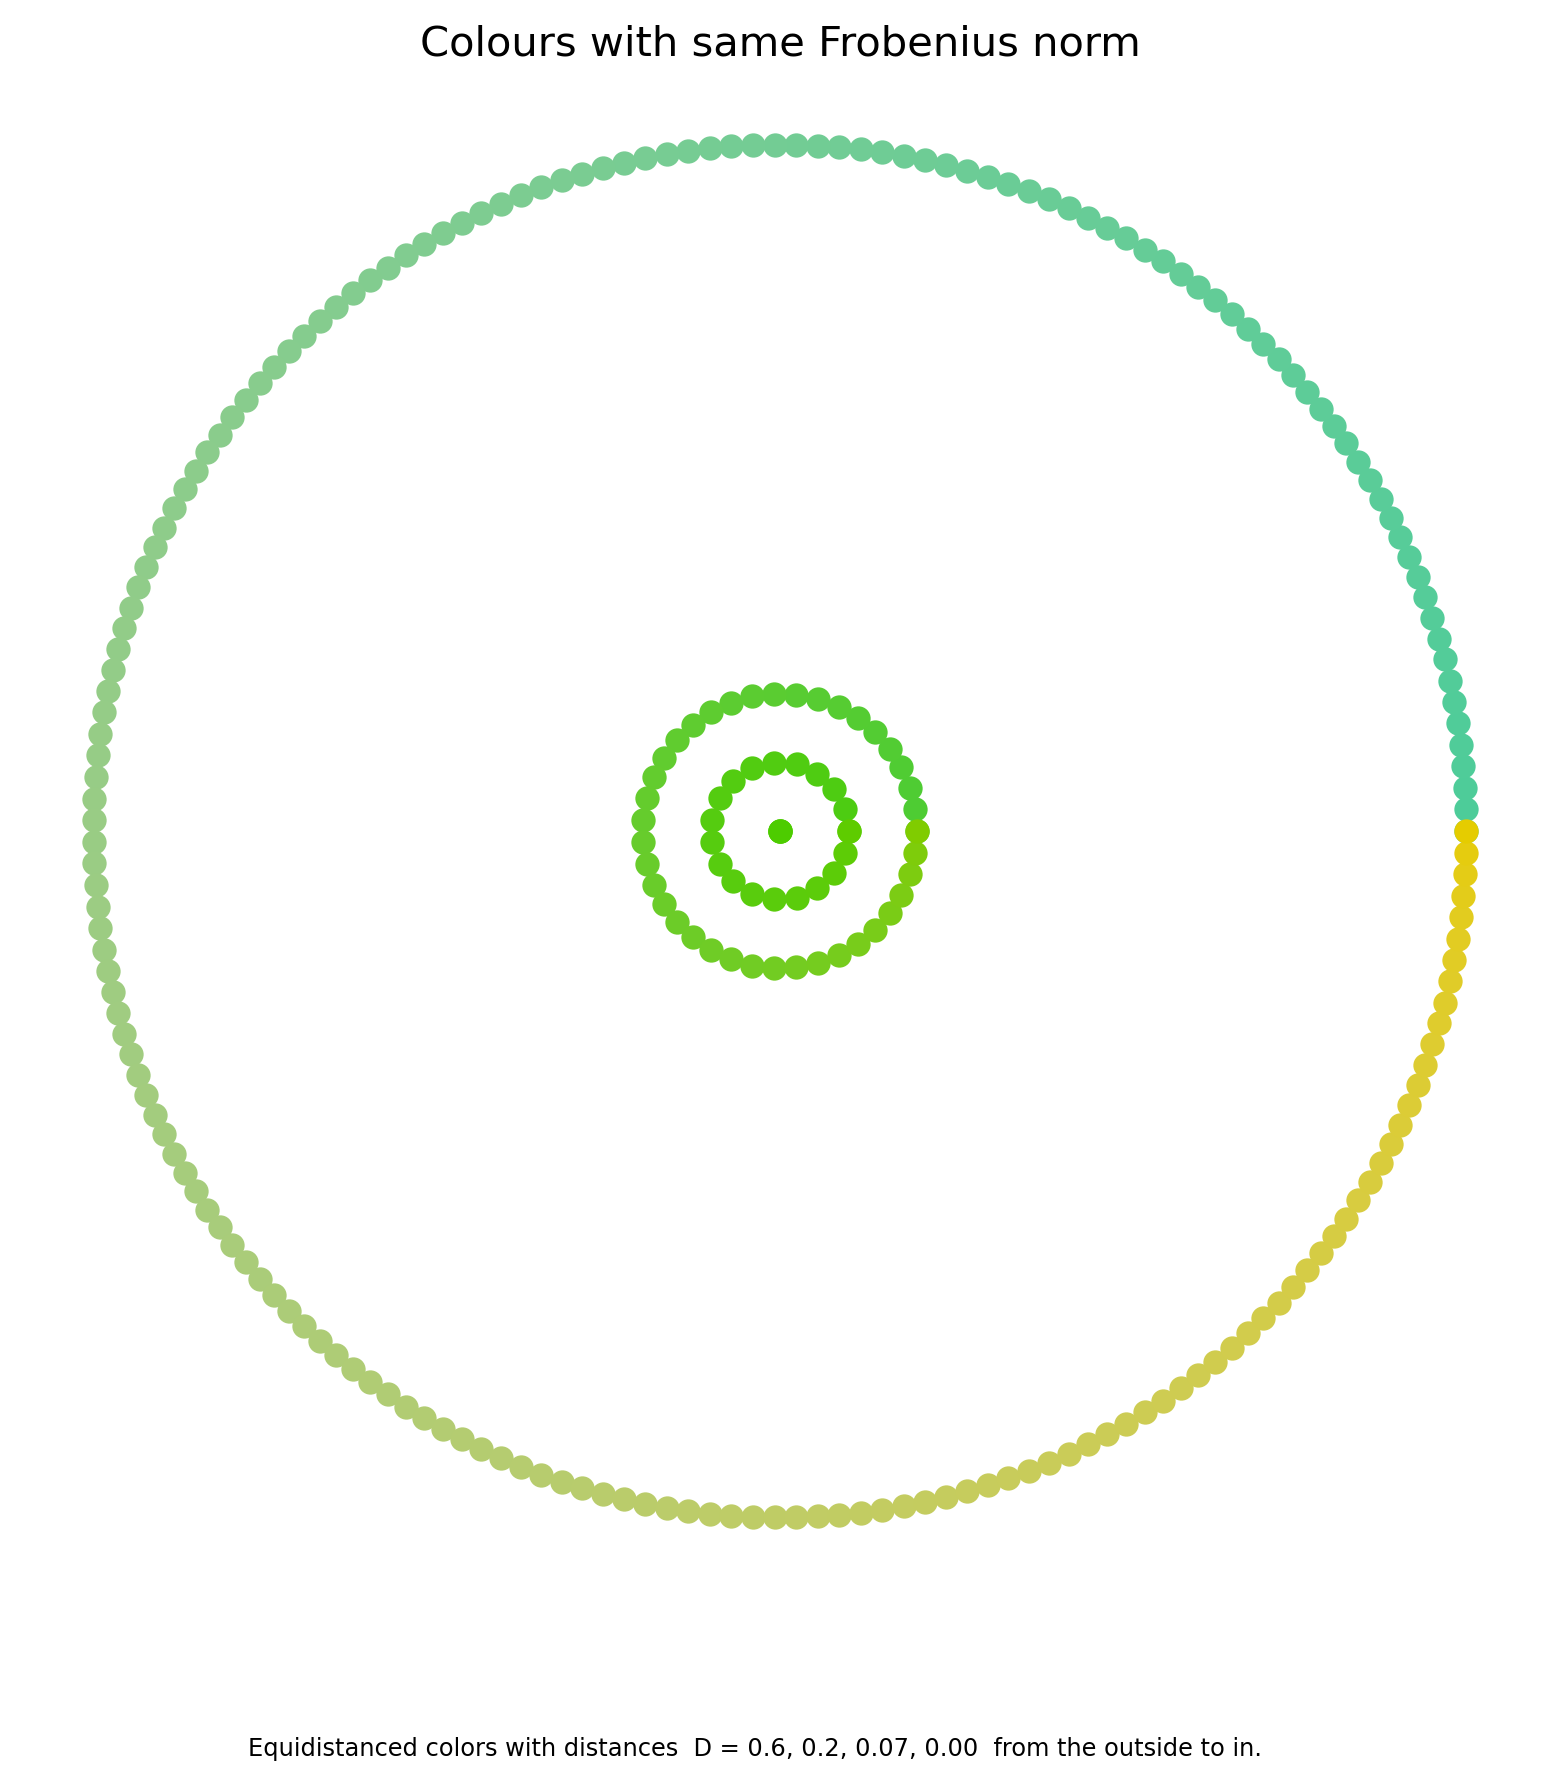

In [267]:
def colour_demonstration(n,color_dist,radius):
    
    """
    Returns neccesary data to create a circle with a RGB color corresponding to its Frobenius norm
    Input:
    n: Amount of small circles with unique colors
    color_dist: The Frobenius distance between the colours. Can be interpreted as a color radius
    radius: Actual radius for plotting.

    output:
    colors: Array of colors corresponding to the given n and color_dist.
    a,b: x and y coordinates of the circle
    """
    #Hardcoded values handpicked to give a good example
    #These values create the colour that we want to compare with colours with a distance color_dist away.
    green_strength = 0.8
    red_0 = 0.3
    blue_0 = 0

    #The greens are fixed so we get a circle instead of a ball
    greens = np.repeat(green_strength,n)

    #Array of possible red values
    reds = np.linspace(red_0,red_0+color_dist,n) 
    
    #Calculate the corresponding blue value given a specific red value a distance
    def b(r,distance):
        b1_attempt = blue_0 +(1)*(np.sqrt( (distance**2-(np.abs(r-red_0))**2).round(14)))
        if (b1_attempt>blue_0):
            return b1_attempt
        else:
            return blue_0 -(1)*(np.sqrt( (distance**2-(np.abs(r-red_0))**2).round(14)))
    
    #Create the blue values array
    blues = np.zeros(n)
    for i in range(n):
        blues[i] = b(reds[i],color_dist)
    

    
    #From the three color arrays, create RGB tuples
    colors_arr = [(i,j,k) for i,j,k in zip(reds.ravel(),greens.ravel(),blues.ravel())]

    #Make the first colour-element the comparison colour
    colors_arr = np.insert(colors_arr,0,(red_0,green_strength,blue_0),axis=0)

    #Magic from stackoverflow, there are probably easier solutions as we don't actually cycle.
    colors = itertools.cycle(colors_arr)

    #parametrize a circle
    theta = np.linspace(0, 2*np.pi, n)
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #insert the first element in the centre of the circle
    a = np.insert(a,0,0)
    b = np.insert(b,0,0)

    return colors, a, b
def plot_demonstration(): 
    colors_060, a_060, b_060 = colour_demonstration(200,0.6,10)
    colors_020, a_020, b_020 = colour_demonstration(40, 0.2, 2)
    colors_007, a_007, b_007 = colour_demonstration(20, 0.07,1)

    #plotting
    figure, axes = plt.subplots(1)

    for i in range(len(a_060)):
        plt.scatter(a_060[i], b_060[i], color=next(colors_060))

    for i in range(len(a_020)):
        plt.scatter(a_020[i], b_020[i], color=next(colors_020))

    for i in range(len(a_007)):
        plt.scatter(a_007[i], b_007[i], color=next(colors_007))

    axes.axis('off') 
    axes.set_aspect(1)

    plt.title('Colours with same Frobenius norm')

    figure.text(
        0.5,
        0.05,
        "Equidistanced colors with distances  D = 0.6, 0.2, 0.07, 0.00  from the outside to in.",
        ha="center",
        va="top",
        size="x-small"
    )
    
    
    plt.show()

plot_demonstration()

The outermost ring represents a range of colours that share the same Frobenius norm of `0.6` between them and the centre colour. We would intuitively judge the light green upper part more similar to the reference colour `C_0` in the centre, compared to the lower right quadrant of green-yellow colours.

If we tie this demonstration together with our CryptoPunk dataset, we can gain an understanding of what it really means for the deviation to be e.g. "$80$" using the Frobenius norm. Let us fix a $D$ to denote the error between two matrices $A, B$ containing CryptoPunk images. The following equation showing the element-wise difference holds:
$$
    \sum_{\lambda \in \Lambda} |a_{\lambda} - b_{\lambda}|^2 = D^2
$$
for some indexing set $\Lambda$ that covers every colour-channel, in every pixel, in every image. If we then introduce $e$ as the average element-wise error, we get
$$
  \sum_{\lambda \in \Lambda} |e|^2 = D^2.
$$
As $\Lambda$ covers all every element in the dataset we know that $\Lambda$ has $|\Lambda| = 24 \cdot 24 \cdot 3 \cdot 500 = 864\ 000$ elements, assuming every pixel in every image is utalized. We will however for the sake of the argument say that one third of this quantity is utilized, as the faces' pixels roughly cover a third of the frame's pixels. Now let $N = \frac{1}{3} \cdot 864\ 000 = 288\ 000$ be the amount of equally utilized entries in our data sets $A$ and $B$, then we can further advance the equation:
$$
    N \cdot e^2 = D^2
$$
which leaves us with
$$
  D = e\sqrt{N}
$$

The middle ring resembles a smaller Frobenius-color-distance of `e = 0.2`. Using the equation above, and the assumption that the face covers roughly one third of the image, we can calculate the difference between a data-set $A$, and another data-set $B$, where every face in $B$ has an average colour-channel deviation of `0.2`. Then this difference is $\Vert A - B \Vert_F = 0.2 \cdot \sqrt{288\ 000} \approx 107.3 $. The smallest ring uses the colour distance `e = 0.07`, and resembles a difference of $\Vert A - B \Vert_F \approx 37.6$. 

Thus these two rings are to scale with the average pixel deviations of the reconstructed matrices that were previously presented. The values are chosen such that they represent a lower and upper bound of these deviations, and can be utilized a reference when looking at our error plots.



## 2.7 Bonus: Custom faces

The columns of $W$ can be thought of as basis-vectors for our faces, i.e., each basis-vector is a characteristic of a CryptoPunk face. $H$'s columns denote "how much" of each face-characteristic a given face has. A natural thought is one exploring the possibility of creating our own CryptoPunk face, using the acquired facial properties from $W$. 

Say we wanted to create a high valued CryptoPunk, then we just need to pick the characteristics that are seen as rare and add them together. Let’s create a zombie with a cowboy hat and a cigar for example, then we just need to create a $d$ dimensional vector that contains zero-entries except for the indices of $W$ that portray a zombie, cowboy hat and cigar. These elements will be defined as scalars, which describes how much of the given property we want. We will use `3.5` for the hat, `2` for the zombie and `0.7` for the pipe.


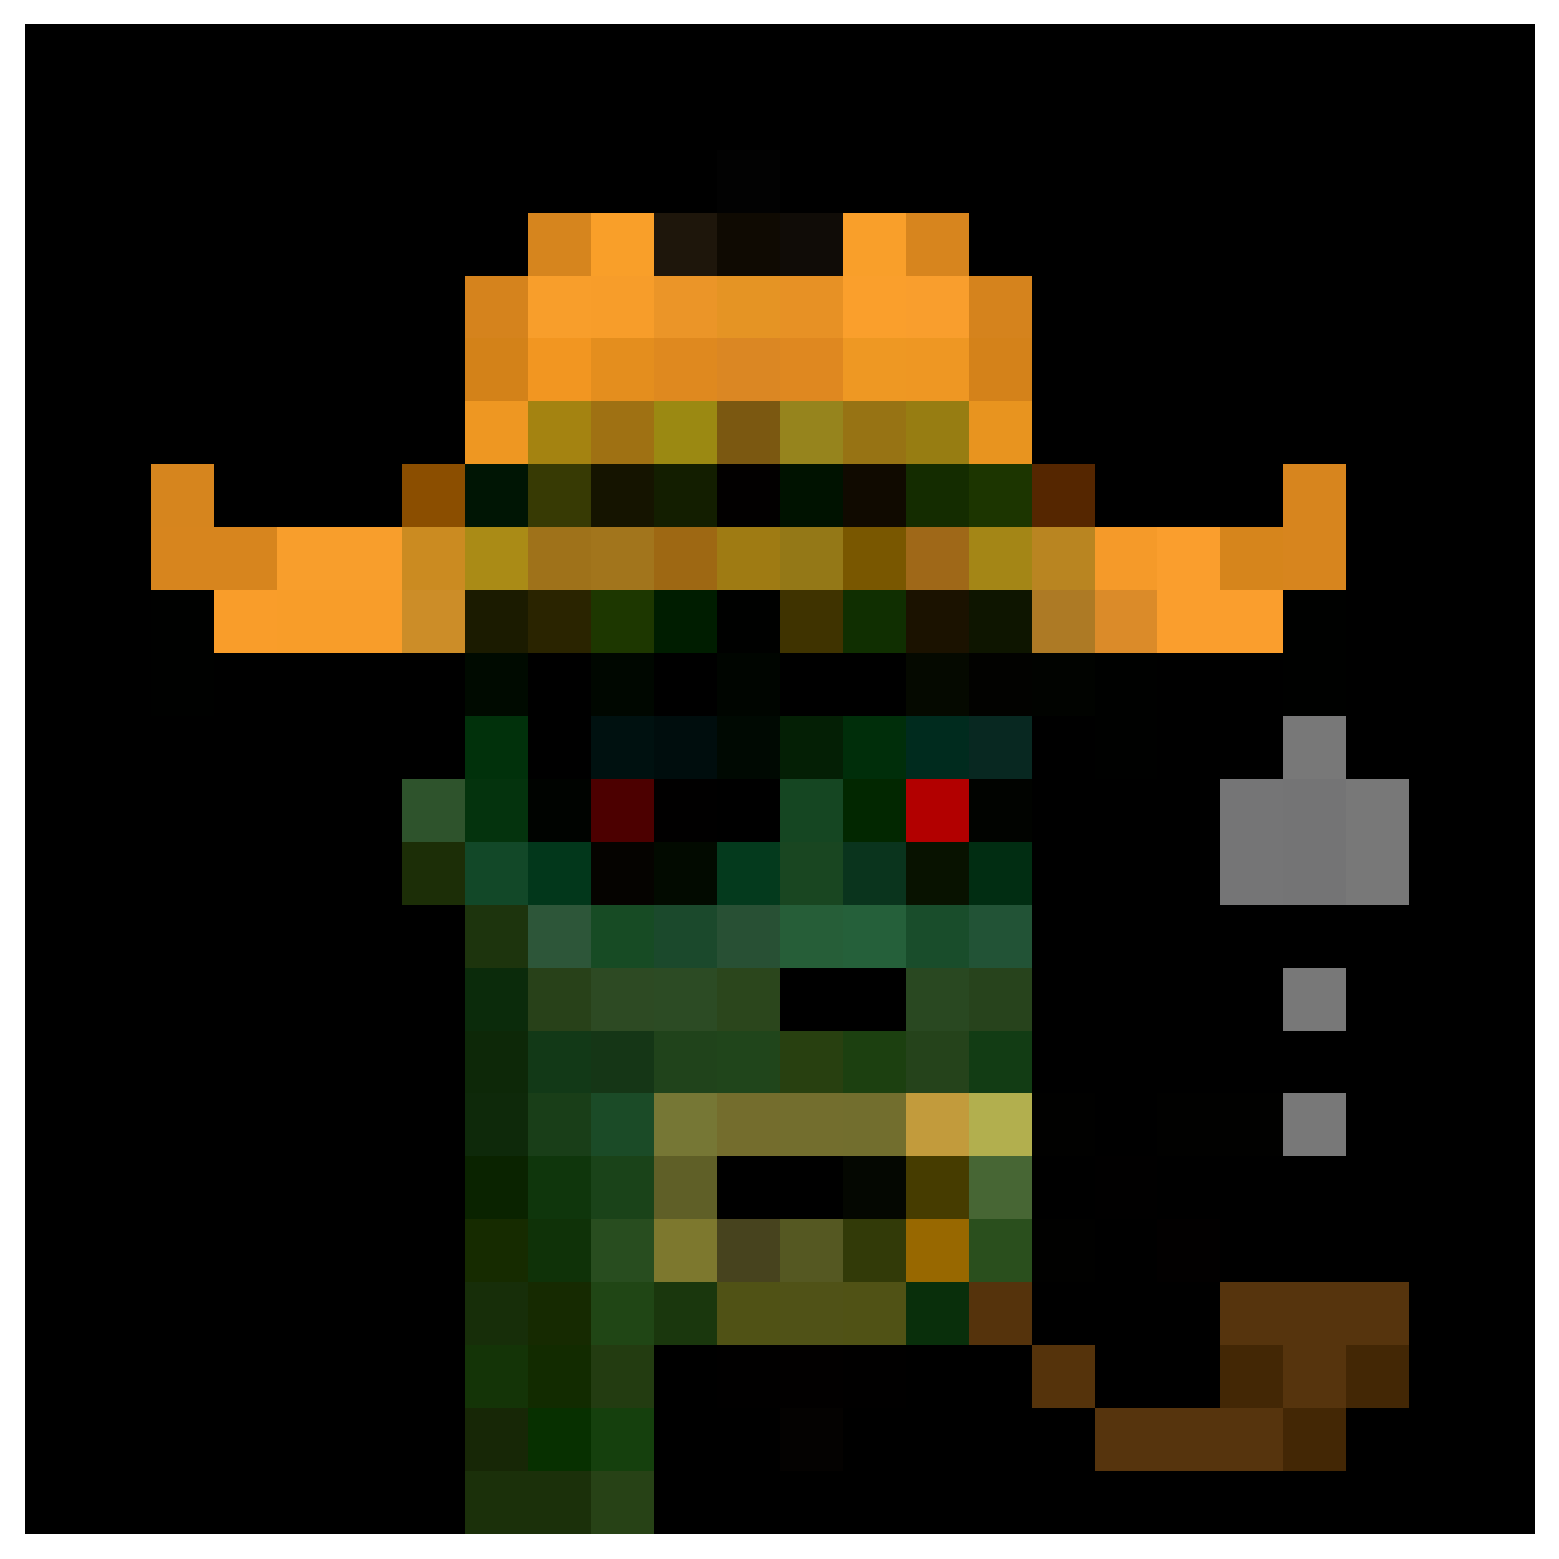

In [268]:
def custom_face():

    # Unpack the relevant data 
    matrix_data = np.load('W_and_H_128.npz')
    W, H = matrix_data['W_calculated'], matrix_data['H_calculated']

    # Find dim(W)
    d = np.shape(W)[-1]

    # Create the cunstom face vector
    custom_face = np.zeros(shape=(d, 1))
    custom_face[45] = 3.5   # Cowboy hat
    custom_face[66] = 2     # Zombie
    custom_face[84] = 0.7   # Pipe

    ##########################################################
    #   Plot a single face
    plt.imshow(np.dot(W, custom_face)[:, :, :, 0])
    plt.axis('off')
    plt.plot()
    ##########################################################
    

custom_face()

As we can see from the plotted picture, a zombie with a pipe and cowboy hat has been created. A quick web-search shows us that a figure with these characteristics combined does not exist (as of the time writing this), so this face has been generated completely from scratch. Now, one might attempt to convince someone who's not a NFT expert to buy the PNG file for millions of dollars :)


# 3.0 Denoising using NMF

Image noise is random variations of the brightness or colour information in an image. There are multiple factors that impact the amount of image noise, for example the camera-sensors and/or the amount of compression. Often it is ideal to minimize the amount of noise in an image, and there are a lot of ways one could go about reducing such noise. Here we can use the NMF, as one of its many useful applications is noise removal. Its worth noting that as the NMF is an unsupervised method, it's not as prone to overfitting as other supervised methods. This may come at the cost of the effectiveness, but it's certainly a nice option to have. 

## 3.1 Adding noise
To add noise to the CryptoPunks we will consider additive Gaussian noise:
$$
A_{noisy} = A + \sigma E
$$ 
where E is a matrix full of components normally distributed with expectation value 0 and mean equal to 1. $\sigma$ is a scaling factor for the noise level. 

This is a fairly good noise model, due to the fact that most physical noise behaves very similarly to Gaussian distributions. We can also assume that the physical noise is independent of the original image. It's worth mentioning that when you take a picture the noise should be modelled with a Poisson distribution due to the discrete nature of the photons in light which requires a discrete probability distribution, but as the amount of photons is extremely large, we can use the Central Limit Theorem which in this case states that the Poisson distribution converges to the normal (gaussian) distribution as $n \rightarrow  \infty$, where $n$ is the amount of photons. 

As we have done previously, we will continue to assume that the opacity is known, and therefore only the three colour channels are noisy. To simplify our model, we will also assume that only non-zero colour channels for a given pixel contain noise. One consequence of this is that any completely black pixels will stay black, as black has the RGB value $(0,0,0)$. After adding noise, we will clip the values to the interval $[0,1]$. This way, we can still plot the images. 

The following function adds gaussian noise to the image-matrix.


In [269]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces


We now utilize our function on the faces we already have studied!


Norm: 42.31


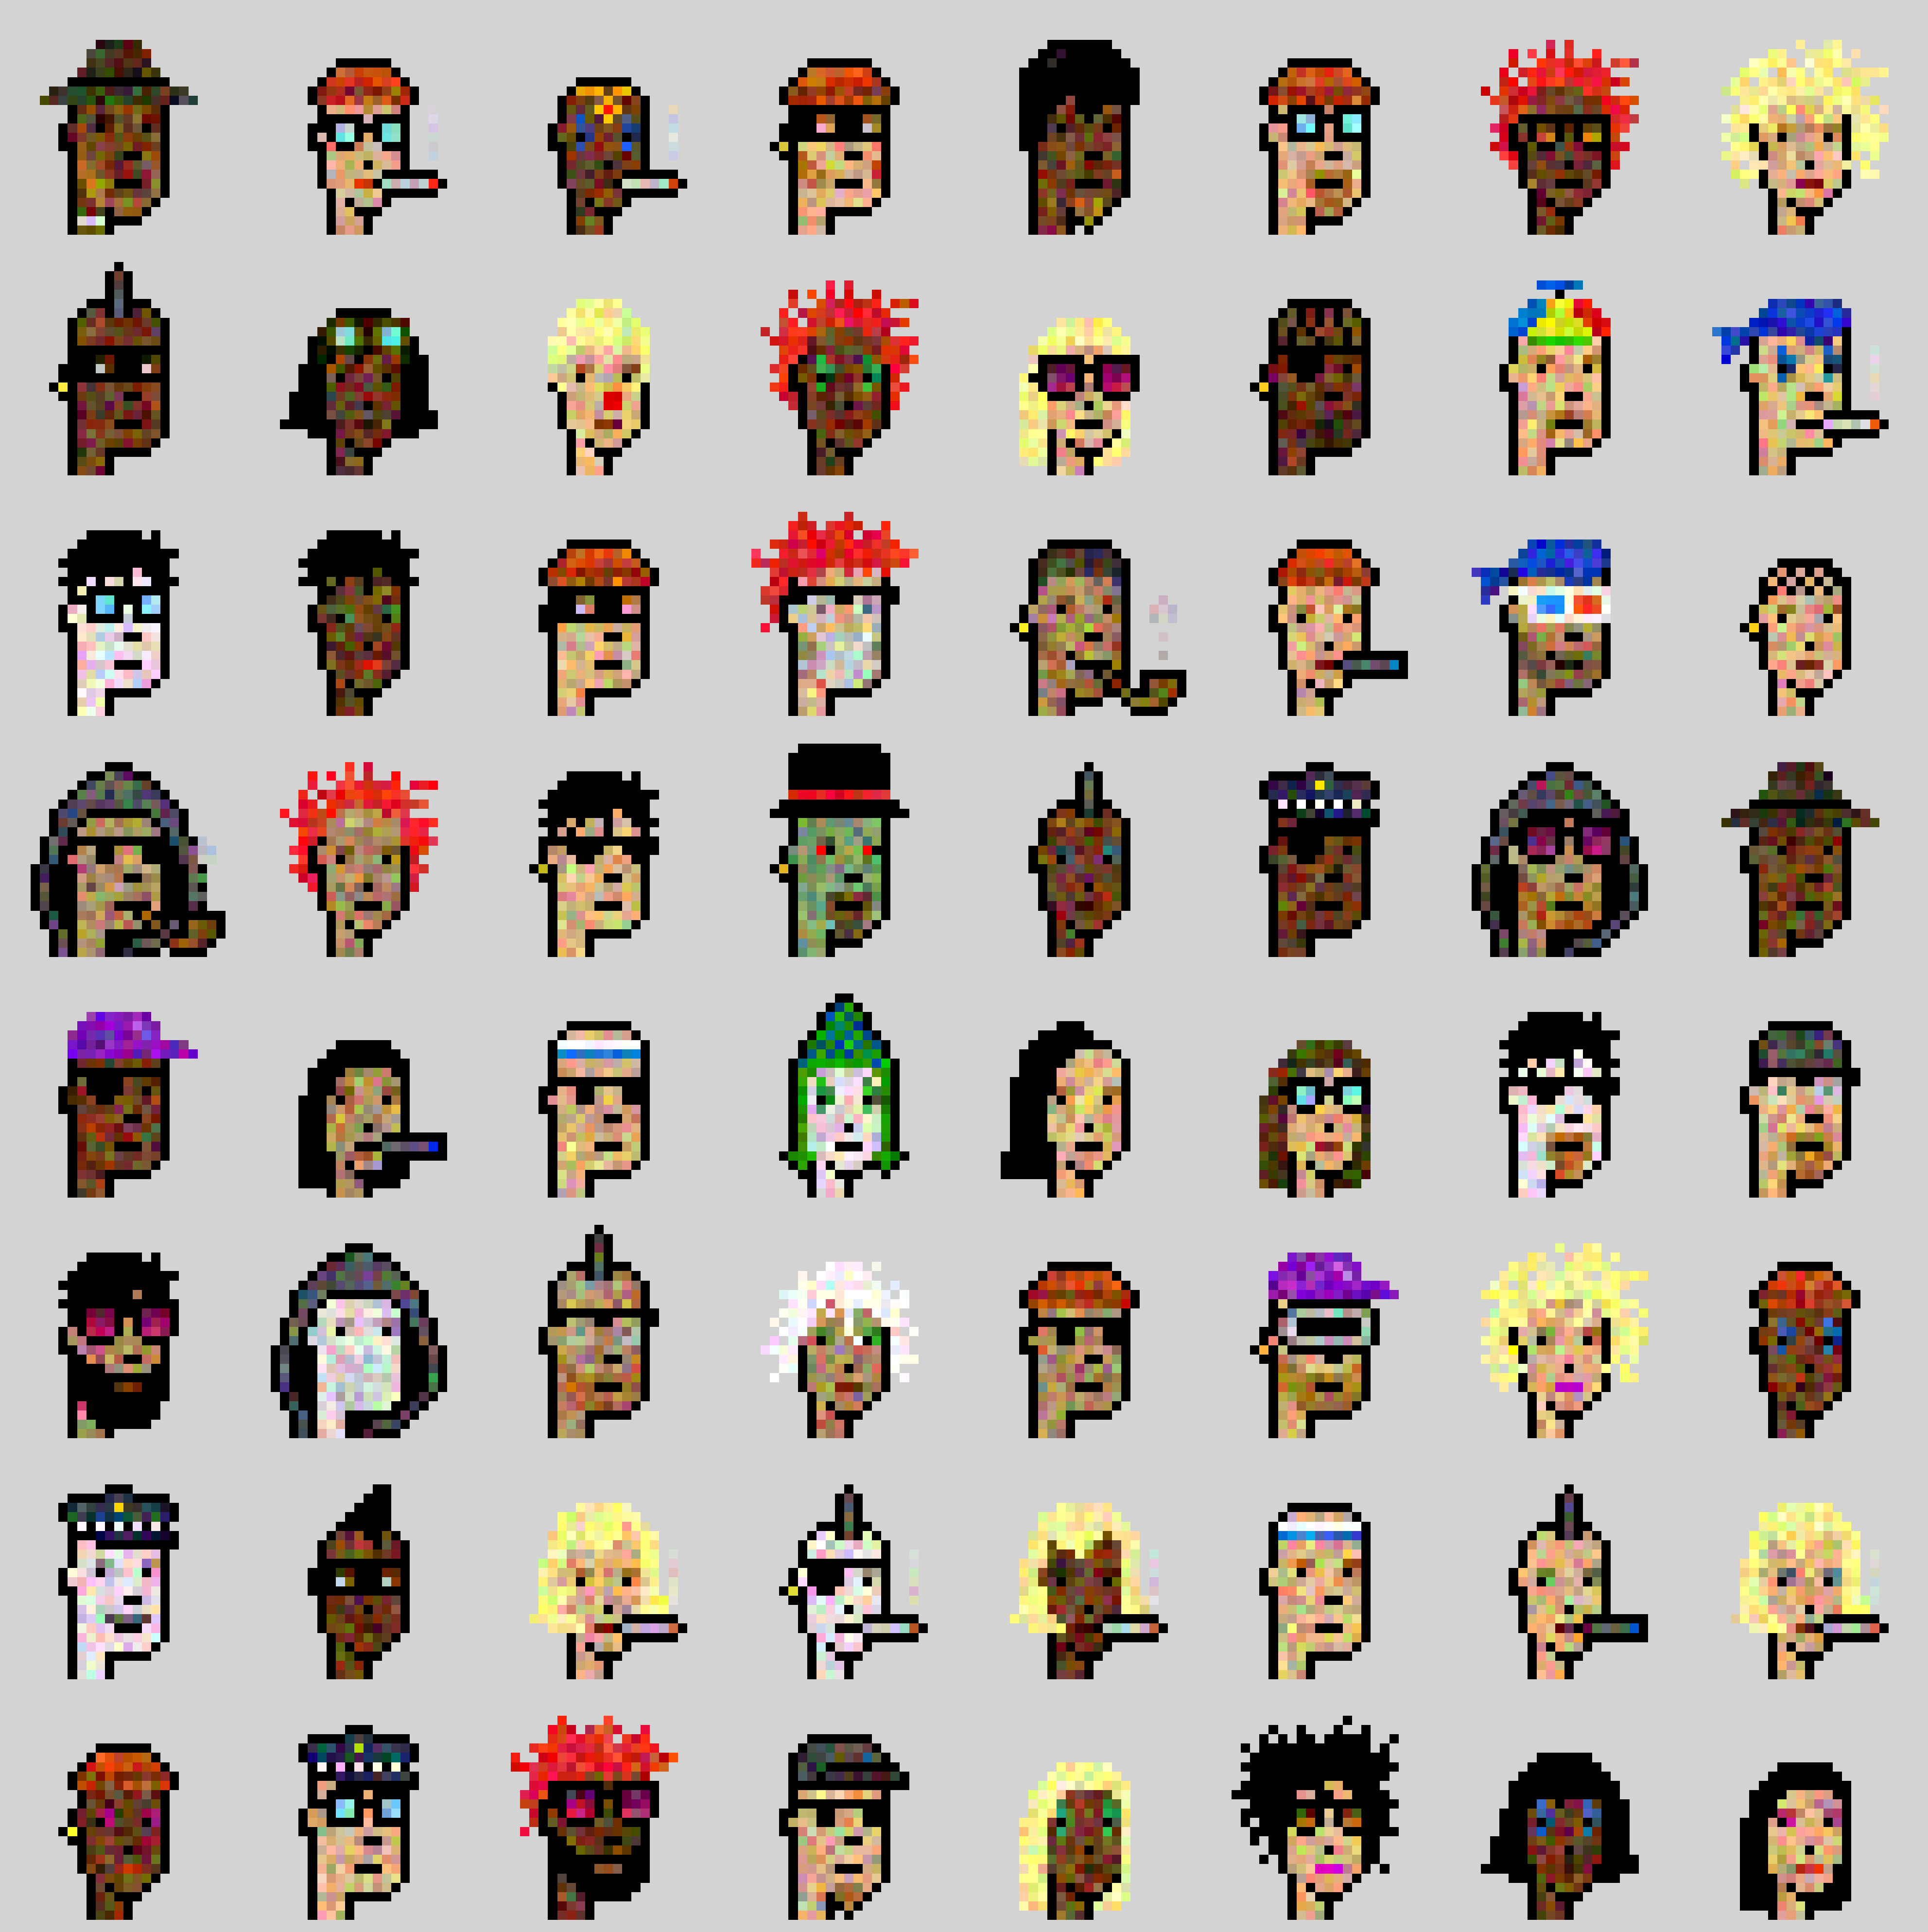

In [270]:
def add_noise_to_images():
    '''
    Funtion for adding noise to faces/images
    '''

    N = 500 # The number of faces imported

    # Importing the faces-data
    faces_data = np.load('faces.npz')
    faces = faces_data['faces_500']

    # Splitting the faces into different channels and reshaping 
    faces_rgb, faces_opacity, faces_reshaped = split_and_reshape(faces, N)

    # Adding the noise onto the faces
    noisy_faces = add_noise(faces_reshaped)

    # Saving the faces
    np.savez(
        'noisy_faces',
        faces = faces, 
        faces_rgb = faces_rgb, 
        faces_opacity = faces_opacity,
        faces_reshaped = faces_reshaped,
        noisy_faces = noisy_faces
    )
    
    # Calculate the error of the noisy images
    noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
    print(f"Norm: {round(noise_residual, 2)}")

    # For plotting noisy images we add the opacity
    noisy_faces_with_opacity = np.zeros(faces.shape)
    noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
    noisy_faces_with_opacity[:,:,3,:] = faces_opacity
    #Save first face for later use
    first_face = noisy_faces_with_opacity[:,:,:,0]
    first_face_reshaped_3 = np.reshape(first_face, (24, 24, 4, 1))   
    np.savez(
        "comparison_face_3",
        first_face_reshaped_3 = first_face_reshaped_3
    )
    plotimgs(noisy_faces_with_opacity)
    
add_noise_to_images()

Here, we have added noise to the CryptoPunk images with $\sigma = 0.1$ From the plot, we can clearly see that the pictures are not as clean as previously. We can attempt to quantify this by calculating $ \Vert A_{noisy} - A \Vert _F = 42.31 $. As expected, we can see that the black pixels are still completely black. This helps us with observing the contour of the CryptoPunks.

## 3.2 Reducing the noise 
We will now have a look at how the NMF finds $W$ and $H$ for these noisy images. What we hope is that the basis vectors are fairly similar to previously, meaning that it has managed to cut through the noise, and catch the essence of the images we feed it. 


The following function uses the NMF on the noisy images, and plots the columns of $W$ and the reconstructions.


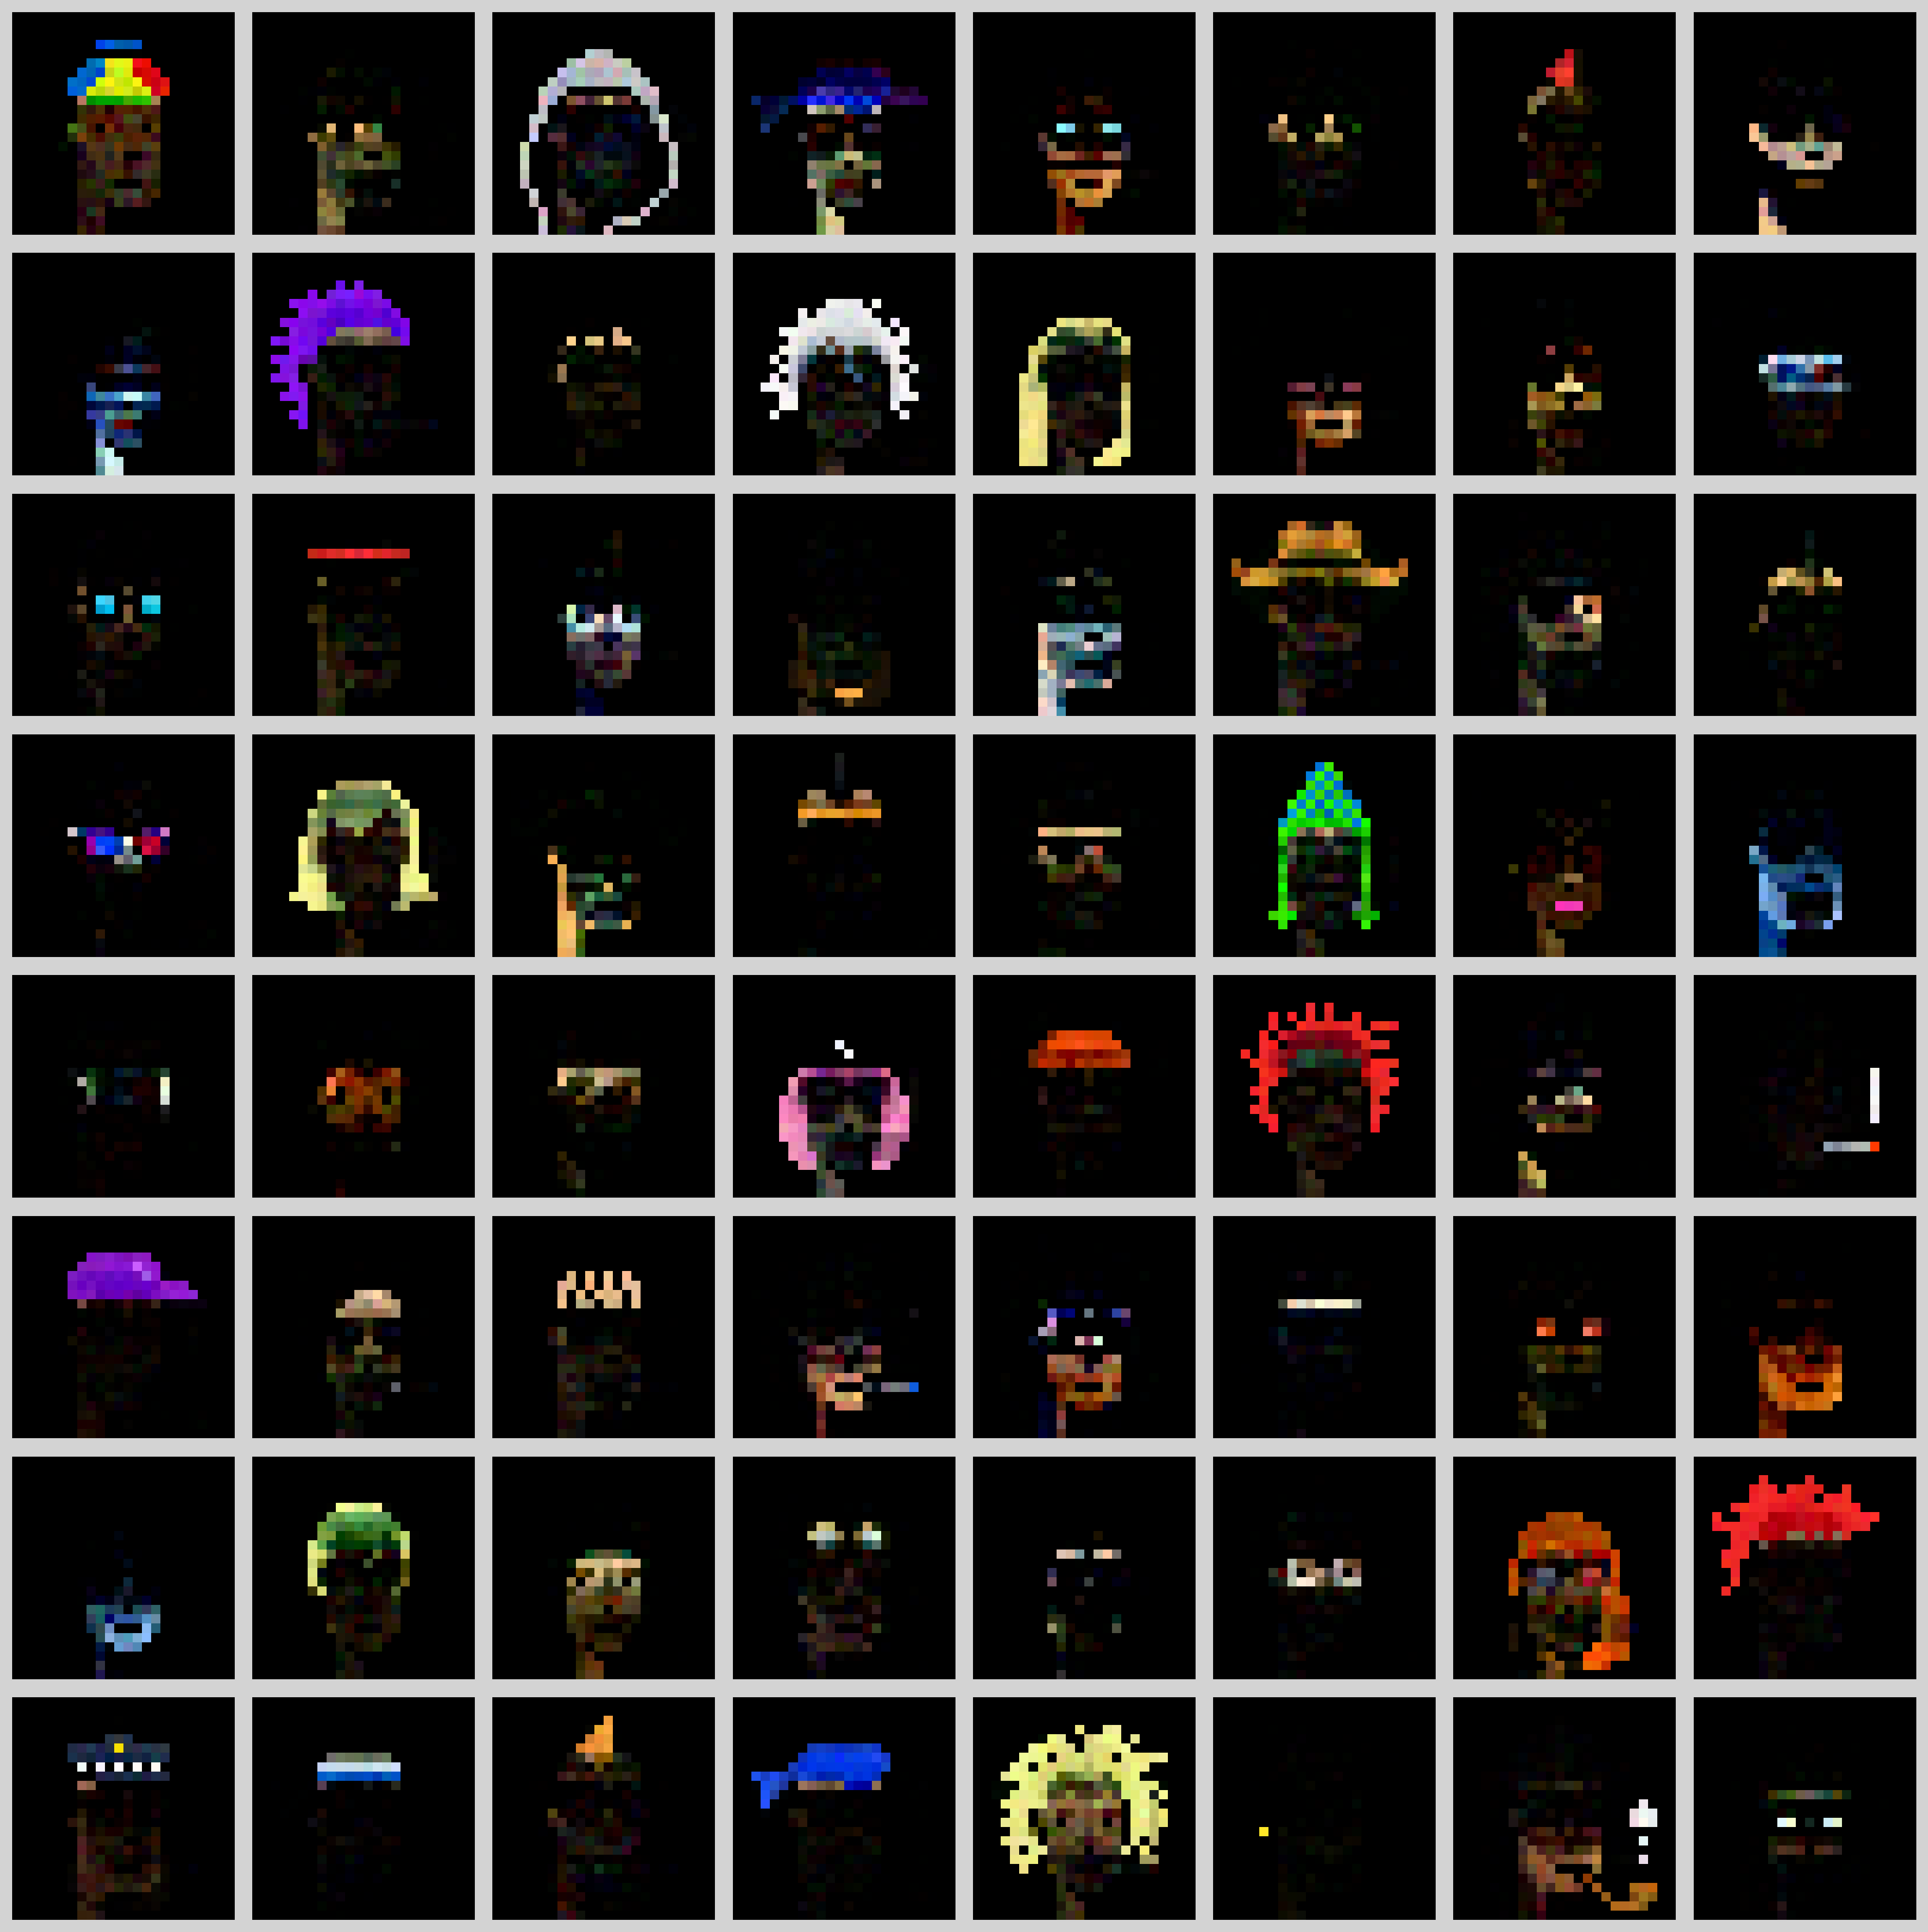

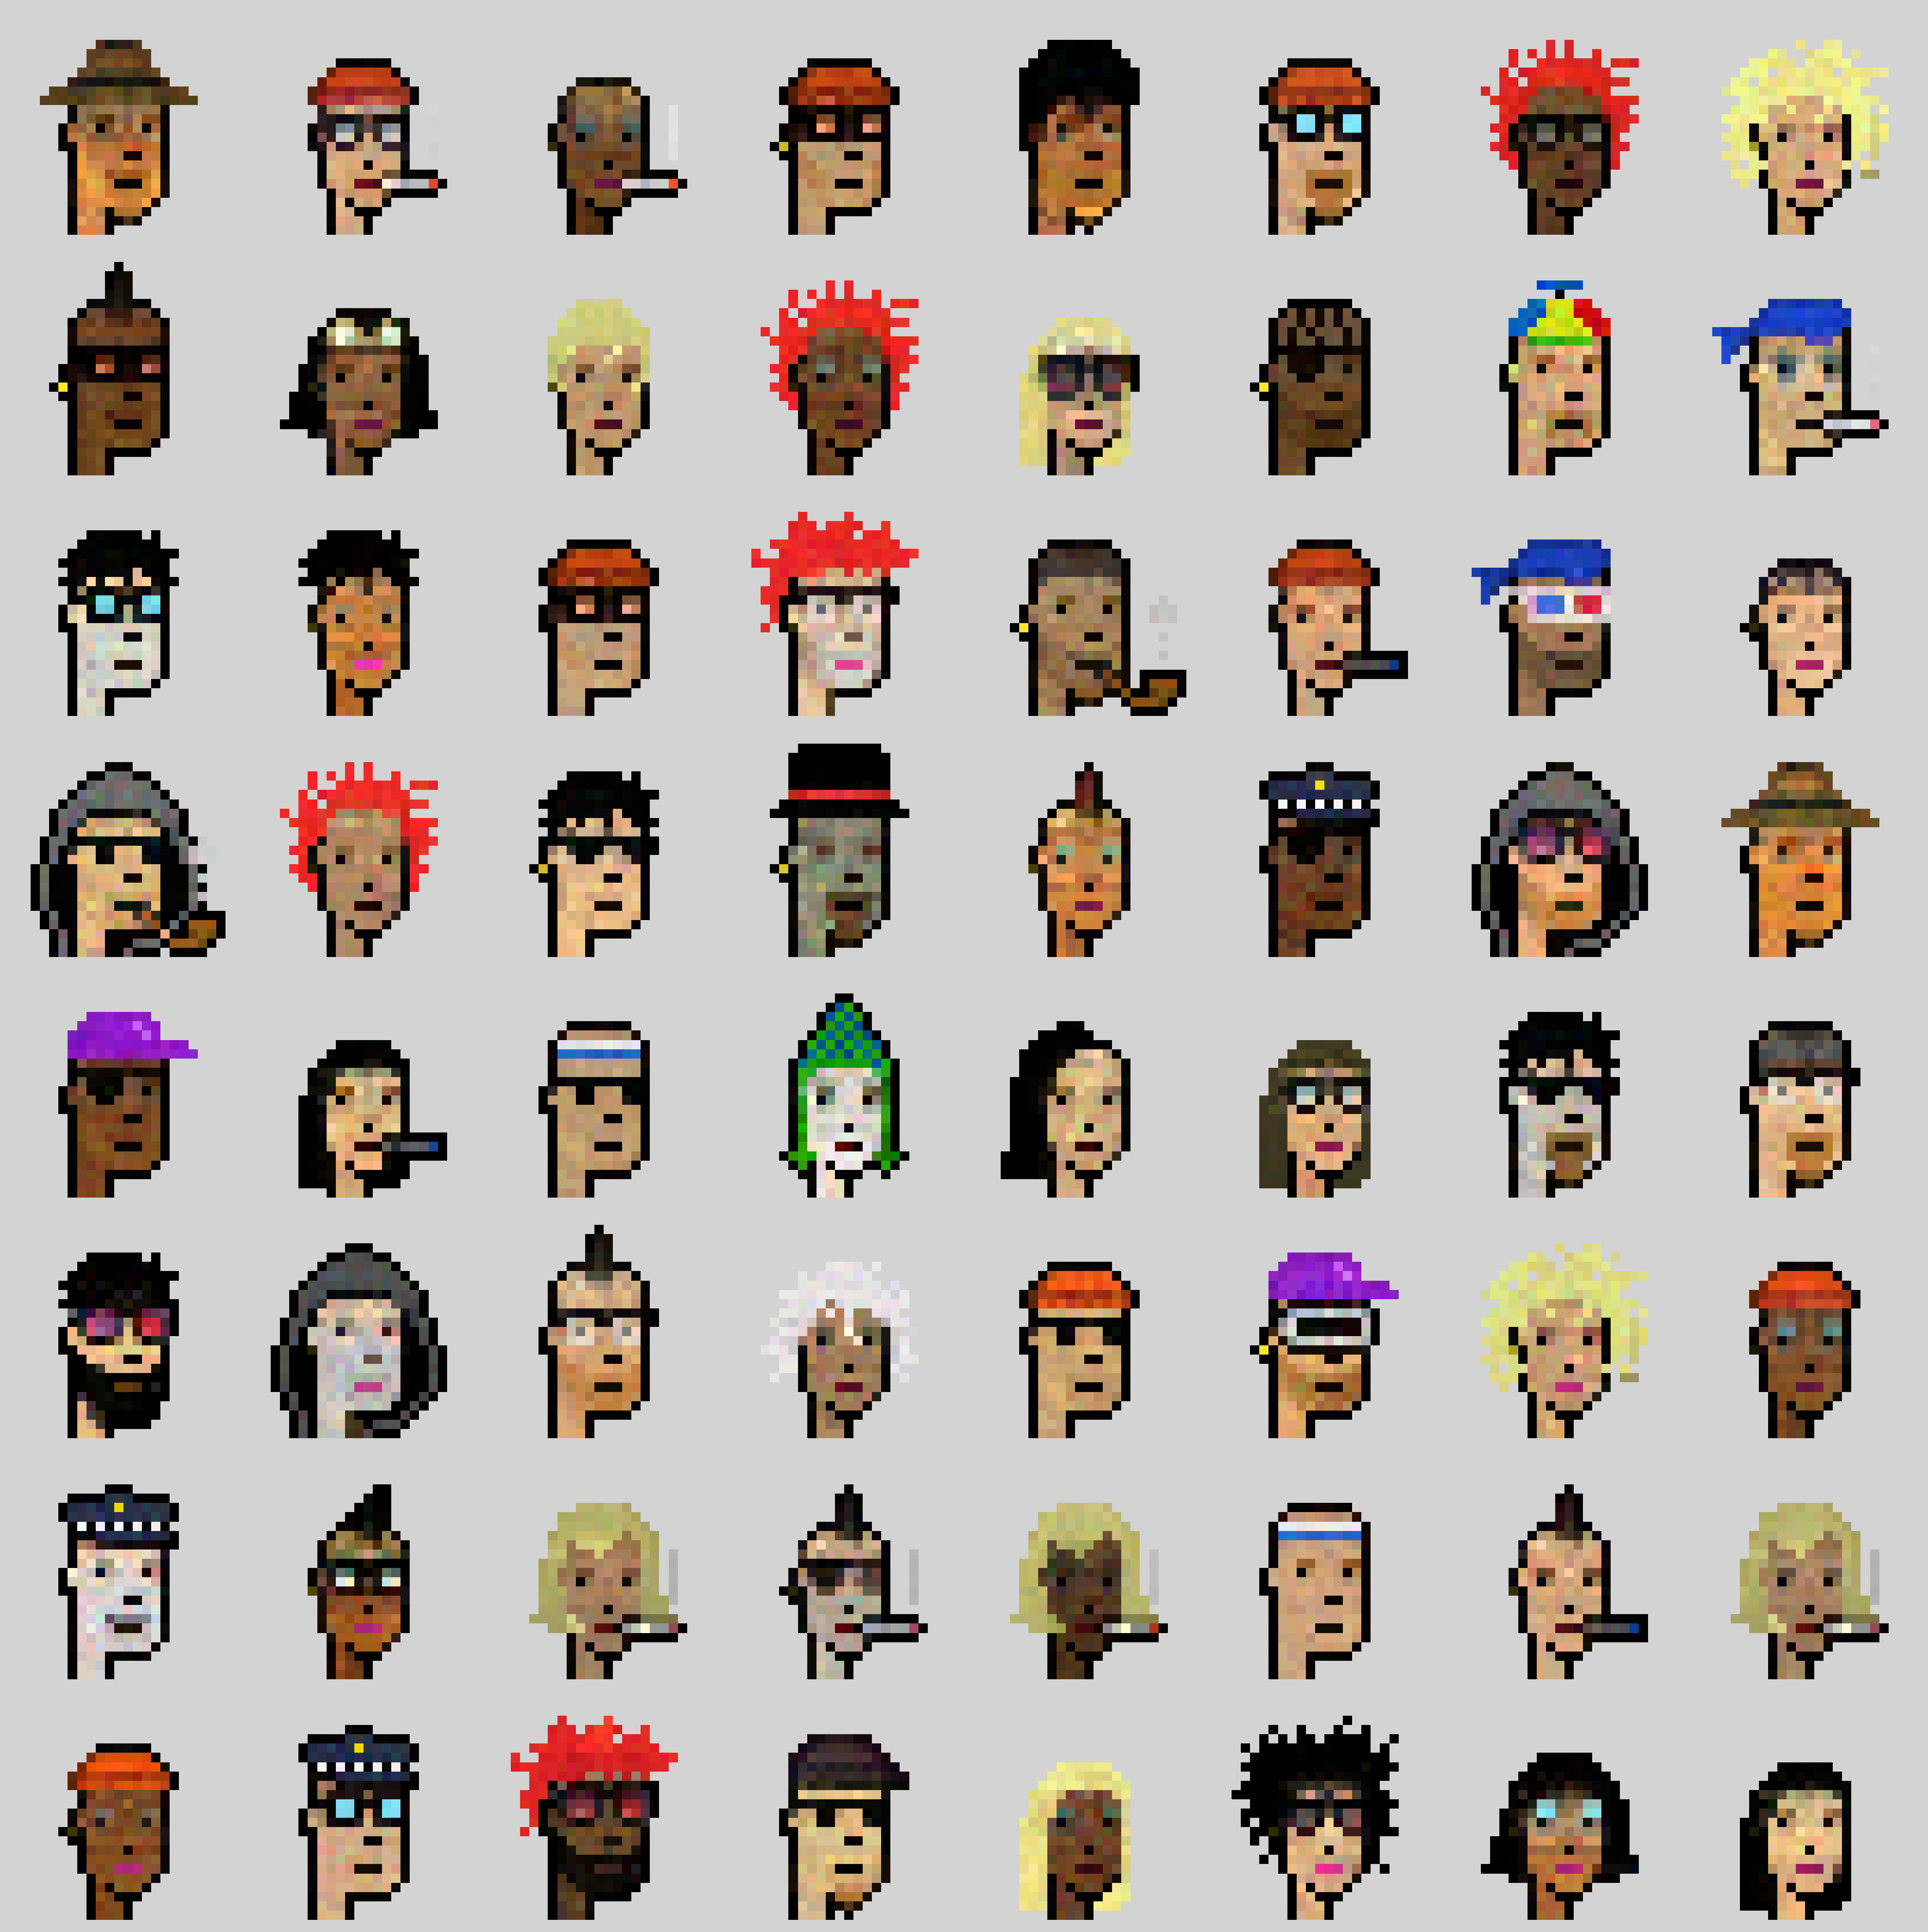

In [271]:
def remove_nosie():
    '''
    Using the NMF-function to remove noise from the noisy-images
    '''

    # Importing data
    noisy_faces_data = np.load('noisy_faces.npz')
    noisy_faces = noisy_faces_data['noisy_faces']
    faces = noisy_faces_data['faces']
    faces_rgb = noisy_faces_data['faces_rgb']
    faces_opacity = noisy_faces_data['faces_opacity']

    d_val = 64 # the number of columns in the W-matrix
    N = 500 # the number of faces imported

    # Calculating the NMF
    W, H = NMF(noisy_faces, d_val)

    # Plotting the columns of W
    plot_W_columns(W, d_val)
    
    # Generating the array for the reconstructions with opacity
    noisy_faces_with_opacity = get_faces_with_opacity(np.dot(W, H), faces, faces_rgb, faces_opacity)
    #Save first face for later use
    first_face = noisy_faces_with_opacity[:,:,:,0]
    first_face_reshaped_4 = np.reshape(first_face, (24, 24, 4, 1))   
    np.savez(
        "comparison_face_4",
        first_face_reshaped_4 = first_face_reshaped_4
    )
    # Plotting the reconstructions
    plotimgs(noisy_faces_with_opacity, nplot = 8, rescale = True, filename = None)

remove_nosie()


From the plot of the basis vectors below, we can see that the method was successful! We can still see specific hairstyles and other distinct objects in the basis vectors.



We can see that the noise removal had a clear effect, and that it was successful in reducing the amount of noise! 

For the columns of $W$, the algorithm is much like before still able to pick out the important features that commonly reoccur throughout the faces. For example, we can still see specific hairstyles, headgear, glasses and so on. Compared to the columns we got when we ran the NMF for the noiseless faces, mostly the same features are being emphasized, but these features are here a bit noisier.


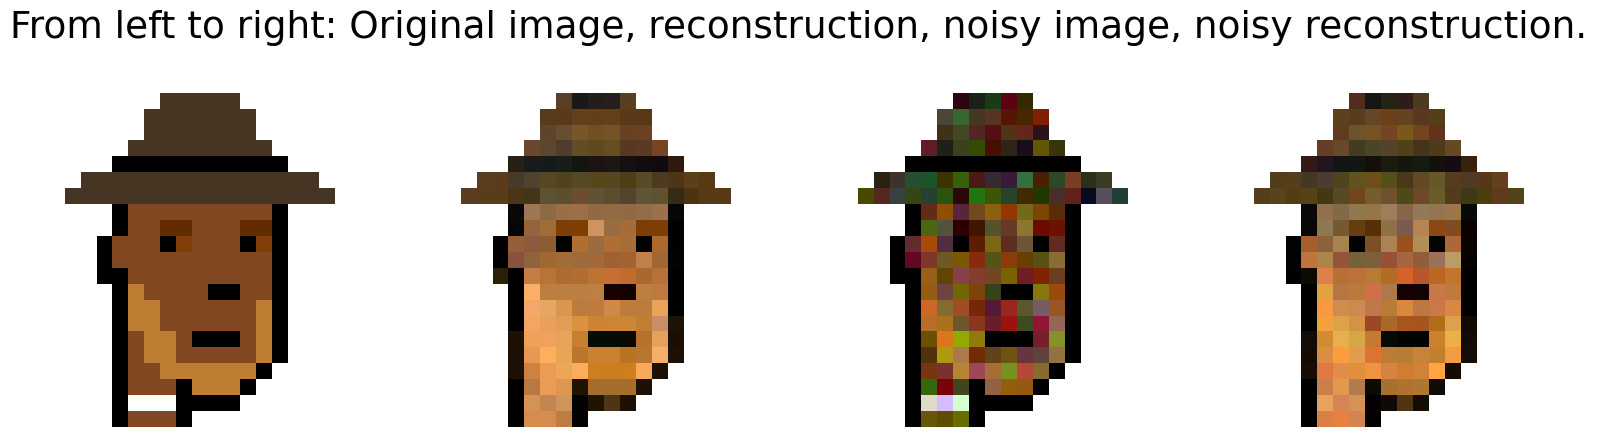

In [272]:
def plot_comparisons():
    #Get the saved data
    face1_file = np.load('comparison_face_1.npz')
    face2_file = np.load('comparison_face_2.npz')
    face3_file = np.load('comparison_face_3.npz')
    face4_file = np.load('comparison_face_4.npz')
    face1 = face1_file['first_face_reshaped']
    face2 = face2_file['first_face_reshaped_2']
    face3 = face3_file['first_face_reshaped_3']
    face4 = face4_file['first_face_reshaped_4']
    
    #Create array to loop through
    face_arr = np.append(face1,face2,axis=-1)
    face_arr = np.append(face_arr,face3,axis=-1)
    face_arr = np.append(face_arr,face4,axis=-1)

    #plotting
    fig, axes = plt.subplots(1,4,figsize=(16,16),dpi=100)

    for i in range(4):
        #rescaling
        scaled_img = np.copy(face_arr[:,:,:,i])
        scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
        axes[i].imshow(scaled_img)

        axes[i].axis('off')
        plt.tight_layout()
    plt.title("From left to right: Original image, reconstruction, noisy image, noisy reconstruction.",fontsize=27, loc = "right")
    plt.show()
   
plot_comparisons()



For the reconstructions, we observe that that the reconstructed faces are cleaner than the faces from before we applied the NMF. The skin is less chaotic, and distinct objects such as caps and hairstyles are clear. Notice that the while the shape of the blue cap is intact, it has more shades of blue, and the shading is less systematic than previously where it was mostly around the edges. Interestingly, when we applied the NMF to the noiseless faces earlier, we observed that there was introduced some noise in the reconstructions. Here the opposite happens, when we apply the NMF to noisy faces the reconstructions are less noisy than the originals!


## 3.3 Overfitting and underfitting
Now that we have noise, we can discuss a very important concept in machine learning: overfitting and underfitting of a given dataset. To aid our discussion, we will plot the end-result deviation for `d = [8,16,32,64, 128, 256, 512,1024]`, both for noiseless data as discussed previously, and for our new data with added noise.


In [273]:
def calculate_norms_for_noisy_faces():
    '''
    Calculating the norms for the noisy and noiseless faces
    '''

    # Importing the faces-data
    noisy_faces_data = np.load('noisy_faces.npz')
    noisy_faces = noisy_faces_data['noisy_faces']
    faces_reshaped = noisy_faces_data['faces_reshaped']

    
    d_vals = [8,16,32,64, 128, 256, 512,1024] # The different numbers of columns in the W-matrix
            
    # Calculating the norms    
    norms_without_noise = calculate_norms(faces_reshaped, faces_reshaped, d_vals)[1] # Noiseless norms
    norms_with_noise = calculate_norms(noisy_faces, faces_reshaped, d_vals)[1] # Noise norms

    
    # Saving the data
    np.savez(
        'noisy_norms',
        d_vals = d_vals,
        norms_without_noise = norms_without_noise,
        norms_with_noise = norms_with_noise
    )
#calculate_norms_for_noisy_faces()

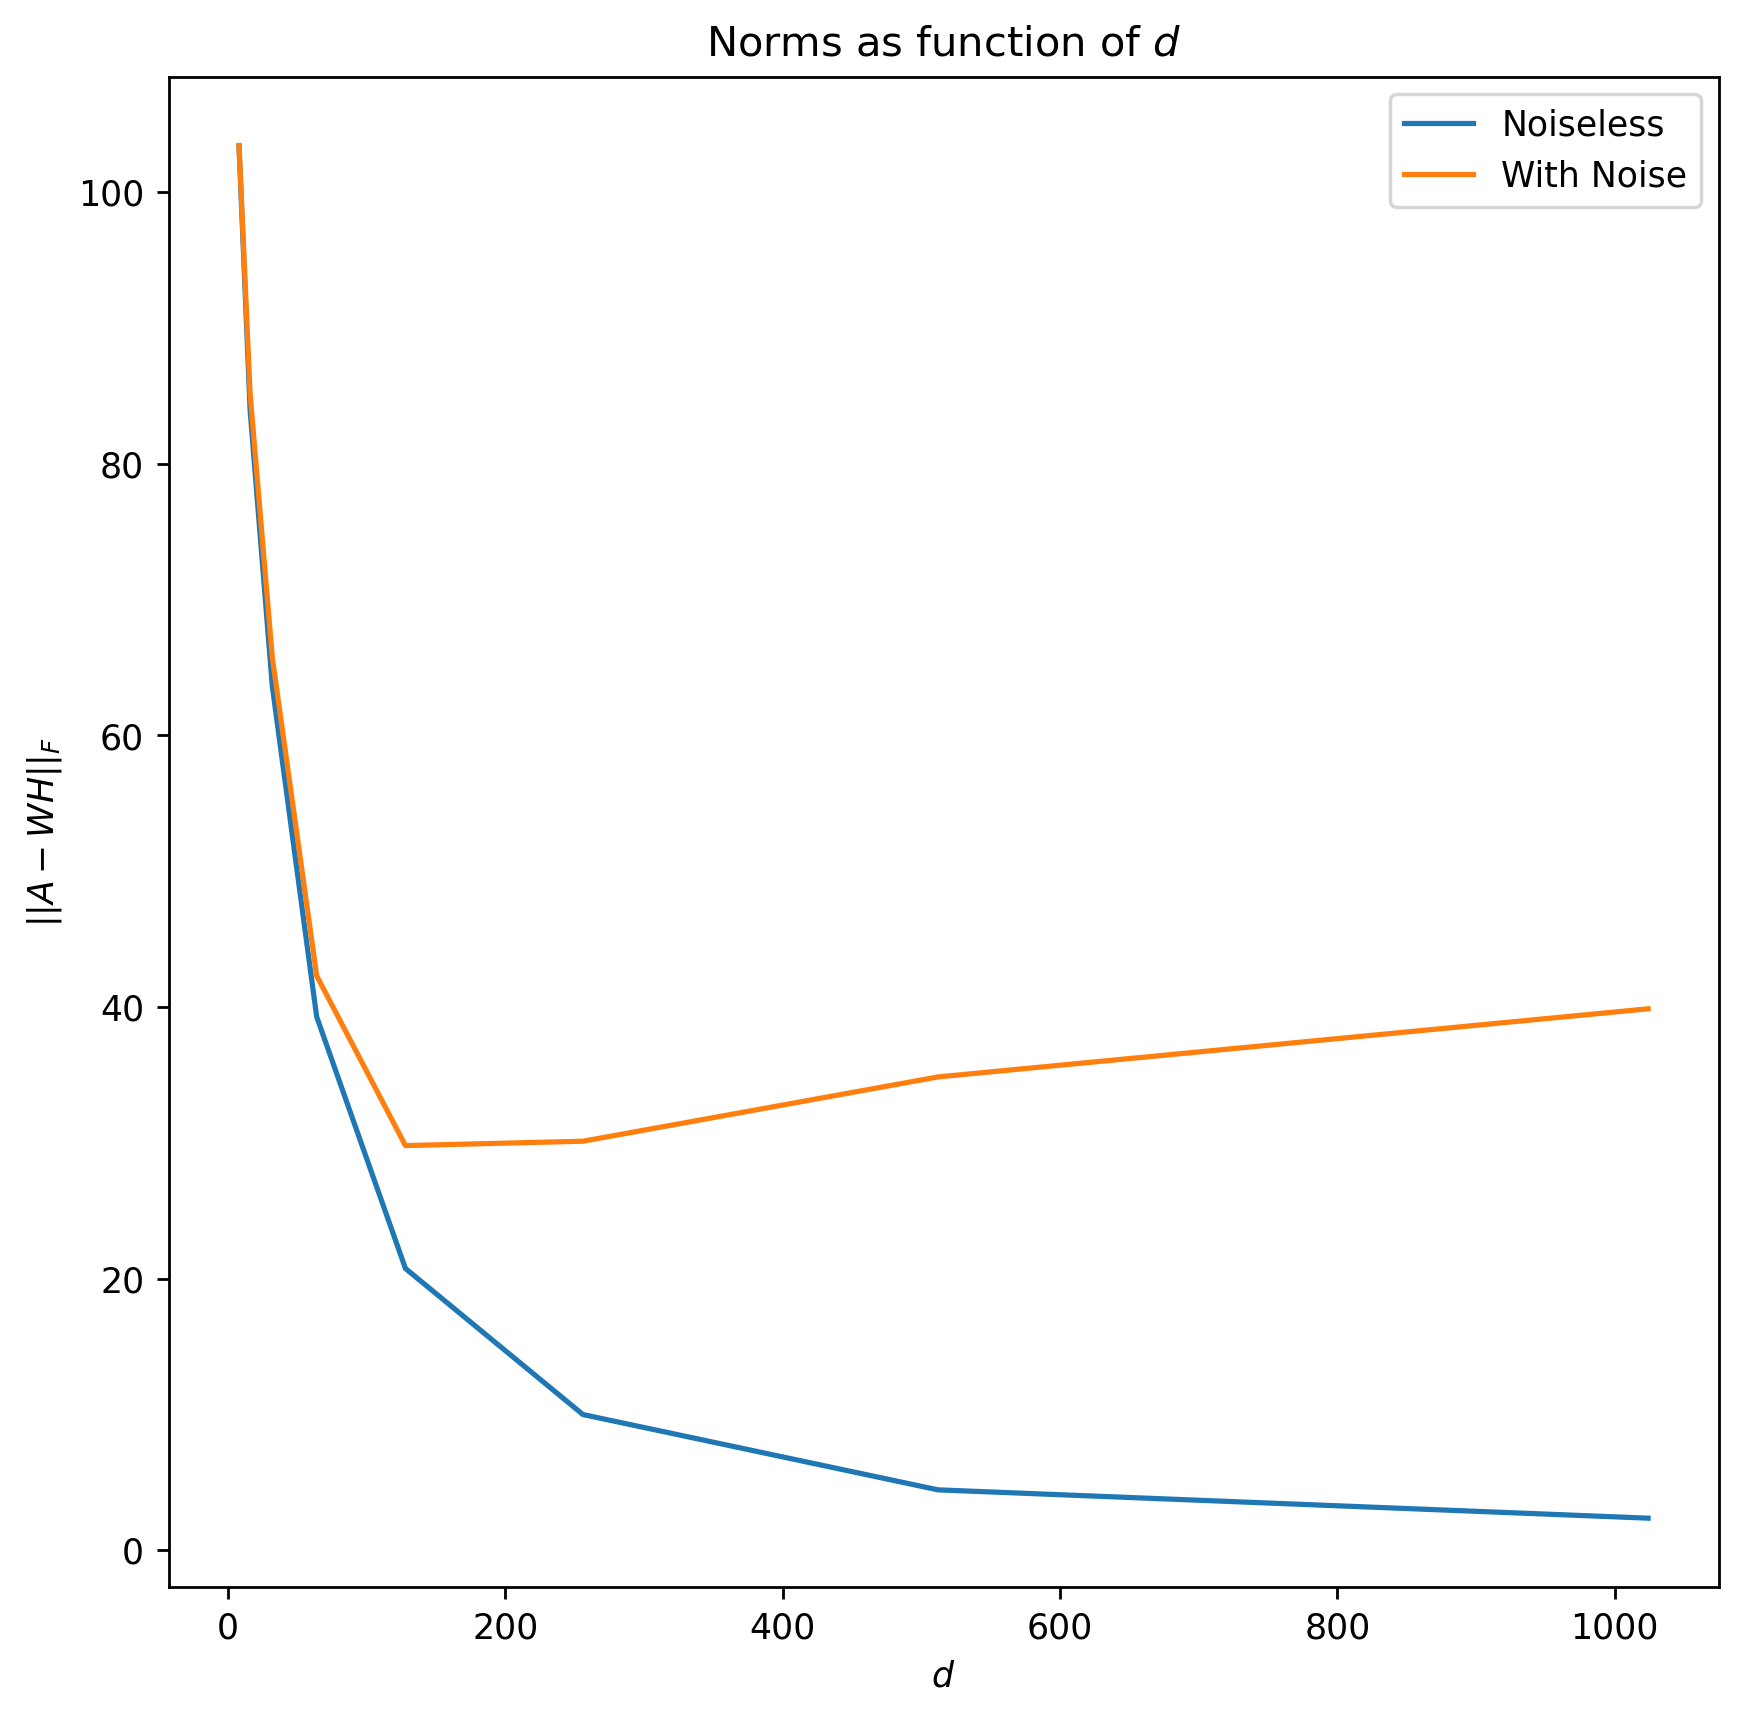

In [274]:
def plot_norms_for_noisy_faces():
    '''
    Plotting the norms for the noisy and noiseless faces
    '''

    # Importing the data
    noisy_faces_data = np.load('noisy_norms.npz')
    norms_without_noise = noisy_faces_data['norms_without_noise']
    norms_with_noise = noisy_faces_data['norms_with_noise']
    d_vals = noisy_faces_data['d_vals']

    # Plotting the two norms in the same figure
    plot_norms([norms_without_noise, norms_with_noise], [], [d_vals, d_vals], ['Noiseless', 'With Noise'], r'Norms as function of $d$', r'$d$', r'$\vert\vert{A-WH}\vert\vert_{F}$')

plot_norms_for_noisy_faces()


Comparing the error of the noisy and noiseless reconstructed faces, we observe that an increasing number of bias vectors reduces the error for noiseless data. This is because the reduced matrix is introduced more components to work with. The resulting plot resembles an 'L'-shape.

On the other hand, with added noise, it's no longer beneficial to blindly increase `d`. This is because some of the basis vectors will eventually start to represent noisy pixels, in the pursuit of recreating the original noisy data set. This phenomenon is called overfitting of the training data, which is undesired, as our goals are to discover and recreate the original noiseless data set. Hence, a need for exploring the rougher, underlying features of the noisy set. Overfitting the data corresponds to an increasing deviation from the noiseless image for large values of d. Since the recreated matrix strays further away from the noiseless image. 
We will not benefit from a too small d however, as the algorithm won’t be able to reconstruct the faces in a good manner, which we call underfitting.

We can observe the under- and overfitting from the plot for the noisy faces. Ideally, its desirable to choose an optimal value for `d` that lies in the lowest point of the dip before the deviation starts to increase.  From the plot, we see that the middle ground appears to be somewhere in the range between $128$ and $250$ basis vectors. Therefore a `d`-value in this range would provide the best fit. It would also have been possible to narrow this range even further by calculating the reconstruction errors for more d`-values between the outliers, but we decided that for our purpose this was not needed.



# 4.0 Conclusion

In this paper, we have implemented a method of dimensionality reduction called Non-negative matrix factorization, via Lee and Seung’s multiplicative rule. Then, using images from the CryptoPunk dataset, we applied the NMF in order to reduce the images by creating matrices with fewer total components than in the original dataset. As a result of the NMF, we also discovered that plotting the columns of the W-matrix would reveal interesting insights into some of the central attributes of the CryptoPunks' appearance.

The CryptoPunk dataset works very nicely for the NMF due to the fact that the faces are perfectly centred, so reoccurring features of the images appear on the same pixels. The NMF is a good fit for this project since pixels are inherently non-negative, and therefore we avoid potential overfitting compared to for example using the SVD method. This is useful for denoising, as it guarantees that the basis vectors in $W$ are images. A disadvantage of NMF is that we are only guaranteed a local minima, and the convergence may be slow. As an unsupervised machine learning method, it's again less prone to overfitting, but at the potential cost of efficiency. Additionally, $W$ and $H$ are not unique, but none of these potential issues were problematic for our project.

When reconstructing the faces, they became noisier than before, but the overall shapes and important features were still present, while we managed to reduce the amount of data drastically. On the other hand, if we calculated the NMF for faces that had been made noisy using gaussian noise, the reconstructions would be less noisy than the faces before the NMF. This is because the algorithm manages to cut through the noise and find the important features, which is given more weight in the reconstruction. 

Lastly, we explored how over- and underfitting impacted the NMF. For noiseless data, increasing the basis vectors would always lead to more and more accurate reconstructions of the original data. On the other hand, for denoising, it is not the case that increasing `d` results in more noise reduction. Therefore, choosing a `d`-value that avoids under- and overfitting is crucial. If we choose the best possible value, we will get the best balance between having enough features to recreate the data, but still not including too much noise.


Overall, this project has given an interesting insight into how one can use abstract mathematical concepts in real world applications. It has been useful to examine how advanced technologies like machine learning can be derived from concepts such as the NMF. In addition, to the first-hand experience of how different fields like computer science and mathematics can be combined will be very relevant for further applications.
